# **Домашнее задание 7: Fraud Detection Competition**

Добро пожаловать на финальное домашнее задание курса! Домашнее задание направлено на систематизацию всех знаний, полученных в процессе учебы.

В нём Вы потренируетесь применять навыки построения пайплайнов машинного обучения, приобретенные в курсе от точки разведочного анализа данных до построения и валидации моделей машинного обучения.

## **Задача**
**Вы будете решать задачу определения фрода:**

https://www.kaggle.com/competitions/fraud-detection-24

**Вам нужно будет:**
- в jupyter notebook провести исследование данных;
- в нём же построить модели и оценить их качество;
- отправить посылку на Kaggle.

Более подробное описание шагов - в ноутбуке ниже.

## **Оценивание и баллы**
- В EDA и во всей работе будут оцениваться полнота и **выводы**;
- При обучении моделей старайтесь обоснованно подходить к их выбору, избегая простого перебора;

**Максимальный балл** - 10 (+ бонусы за Kaggle, см. ниже).


Мягкий дедлайн (окончание соревнования на Kaggle): **15 марта 23:59**


# **Базовое решение и пример формирования файла под submission**


Дропбокс блочит юзеров, когда много обращаются к одним и тем же файлам, так что загрузим вручную наши данные.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import zipfile

drive.mount('/content/drive')

zip_path = "/content/drive/My Drive/data_fraud.zip"

extract_path = "/content/data_fraud"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Mounted at /content/drive


In [2]:
data_path = "/content/data_fraud/data_fraud"

files = os.listdir(data_path)
print("Файлы в папке:", files)

Файлы в папке: ['test_transaction.csv', 'sample_submission.csv', 'test_identity.csv', 'train_transaction.csv', 'train_identity.csv']


In [3]:
train_transaction = pd.read_csv(os.path.join(data_path, "train_transaction.csv"))
train_identity = pd.read_csv(os.path.join(data_path, "train_identity.csv"))
test_transaction = pd.read_csv(os.path.join(data_path, "test_transaction.csv"))
test_identity = pd.read_csv(os.path.join(data_path, "test_identity.csv"))
sample_submission = pd.read_csv(os.path.join(data_path, "sample_submission.csv"))

In [4]:
train_transaction.shape, train_identity.shape, test_transaction.shape, test_identity.shape, sample_submission.shape

((417559, 394), (110666, 41), (172981, 393), (33567, 41), (172981, 2))

In [5]:
!pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.1 MB/s eta 0:00:00


In [6]:
!pip install category_encoders -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.3 MB/s eta 0:00:00


In [7]:
import numpy as np
from catboost import CatBoostClassifier
from tqdm import tqdm
from category_encoders.target_encoder import TargetEncoder
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [8]:
df_train = train_transaction.merge(train_identity, how='left', on='TransactionID')
df_test = test_transaction.merge(test_identity, how='left', on='TransactionID')

In [9]:
df_train.shape, df_test.shape

((417559, 434), (172981, 433))

In [10]:
df_train.TransactionID.isna().sum()

0

In [11]:
df_train.TransactionDT.isna().sum()

0

In [12]:
df_train.TransactionID.head(2)

0    2987000
1    2987001
Name: TransactionID, dtype: int64

In [13]:
df_train.TransactionDT.head(2)

0    86400
1    86401
Name: TransactionDT, dtype: int64

In [14]:
df_train.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417559 entries, 0 to 417558
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.4+ GB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172981 entries, 0 to 172980
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(3), object(31)
memory usage: 571.4+ MB


(None, None)

In [15]:
def reduce_mem_usage(df):
    NAlist = []
    for col in tqdm(df.columns):
        if df[col].dtype != object:

            if not np.isfinite(df[col]).all():
                NAlist.append(col)
                df[col] = df[col].fillna(df[col].min() - 1)

            col_as_int = df[col].fillna(0).astype(np.int64)
            diff = (df[col] - col_as_int).sum()
            IsInt = np.abs(diff) < 0.01

            col_min_value = df[col].min()
            col_max_value = df[col].max()

            if IsInt:
                if col_min_value >= 0:
                    if col_max_value < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif col_max_value < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif col_max_value < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if col_min_value > np.iinfo(np.int8).min and col_max_value < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif col_min_value > np.iinfo(np.int16).min and col_max_value < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif col_min_value > np.iinfo(np.int32).min and col_max_value < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    else:
                        df[col] = df[col].astype(np.int64)
            else:
                df[col] = df[col].astype(np.float32)

    return df, NAlist

Фкнкция выше обрабатывает трейн и тест по-разному (колонки разных типов получаются), поэтому объединим датасеты, обработаем функцией, а потом разъединим

In [16]:
df_train["dataset"] = "train"
df_test["dataset"] = "test"

df_test["isFraud"] = np.nan
df_combined = pd.concat([df_train, df_test], axis=0, ignore_index=True)

df_combined, NAlist = reduce_mem_usage(df_combined)

df_train = df_combined[df_combined["dataset"] == "train"].drop(columns=["dataset"])
df_test = df_combined[df_combined["dataset"] == "test"].drop(columns=["dataset", "isFraud"])

100%|██████████| 435/435 [00:14<00:00, 30.13it/s]


In [17]:
df_train.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 417559 entries, 0 to 417558
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float32(80), int16(53), int8(230), object(31), uint16(22), uint32(3), uint8(15)
memory usage: 391.4+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 172981 entries, 417559 to 590539
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: float32(80), int16(53), int8(229), object(31), uint16(22), uint32(3), uint8(15)
memory usage: 162.0+ MB


(None, None)

О. Все ок.

In [18]:
object_cols = []
for idx, col in tqdm(enumerate(df_train.columns.drop('isFraud'))):
    if df_train[col].dtype == 'O':
      object_cols.append(idx)

433it [00:00, 83354.77it/s]


In [19]:
X_train = df_train.drop('isFraud', axis=1)
X_train = X_train.fillna('')
y_train = df_train['isFraud'].values

cb = CatBoostClassifier(iterations=3)
cb.fit(X_train, y_train, object_cols, )

Learning rate set to 0.5
0:	learn: 0.2079797	total: 2.69s	remaining: 5.38s
1:	learn: 0.1355248	total: 5s	remaining: 2.5s
2:	learn: 0.1164226	total: 8.53s	remaining: 0us


In [20]:
predictions = cb.predict_proba(df_test.fillna(''))

In [21]:
sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': predictions[:, 0]})
sub.head()

TransactionID   isFraud
0        3404559  0.981823
1        3404560  0.934178
2        3404561  0.951703
3        3404562  0.981823
4        3404563  0.934178

In [22]:
# Сохранение submission
sub.to_csv('submission_baseline.csv', index=False)

In [23]:
del cb

### **Примечания:**

**1. Оценка качества и Submission File**
- Ответом является число от 0 до 1, метрикой качества - AUC-ROC.
- Структура Submission File:
 - для каждого значения *TransactionID* в тестовых данных вы должны предсказать **вероятность** для столбца *isFraud*.
 - в файле у вас должно быть две колонки: `TransactionID` и`isFraud`  **для каждой транзакции в датасете**.

**2. Объем данных**

Поскольку набор данных объемный, могут быть проблемы с переполнением памяти в Collab. Для решения проблемы можете использовать функцию из [этого ноутбука](https://colab.research.google.com/drive/18u75eyFGEoyeWJ_MbsLkcPa6gv2tNI8G#scrollTo=V2L1Nl5CTMMl), разобравшись, что она делает с данными.

# **Задание 1 (2 балла)**

Проведите EDA (разведочный анализ данных):
* проанализируйте признаки, их особенности и связь с целевой переменной
* проанализируйте целевую переменную
* оцените степень попарной взаимосвязи признаков, а также связи признаков и целевой переменной
* по результатам исследований сделайте необходимую обработку данных (удаление дублей, работа с пропусками, с категориальными столбцами (если они есть), работа с аномалиями, другие преобразования признаков)

Важно, что EDA всегда сопровождается выводами - не забудьте об этом.

In [24]:
df_train.shape, df_test.shape

((417559, 434), (172981, 433))

In [25]:
pd.set_option('display.max_columns', None)

In [26]:
df_train.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5   card6  addr1  addr2  dist1  dist2  \
0     99    150    discover    142  credit    315     87     19     -1   
1    404    150  mastercard    102  credit    325     87     -1     -1   
2    490    150        visa    166   debit    330     87    287     -1   
3    567    150  mastercard    117   debit    476     87     -1     -1   
4    514    150  mastercard    102  credit    420     87     -1     -1   

  P_emaildomain R_emaildomain  C1  C2  C3  C4  C5  C6  C7  C8  C9  C10  C11  \
0           NaN           NaN   1   1   0   0   0   1   0   0   1    0    2   
1     gmail.com           NaN   1   1   0   0   0   1   0   0   0    0    1   
2   outlook.com           NaN   1   1   0   0   0   1   0   0   1    0    1   
3     yahoo.com           NaN   2   5   0   0   0   4   0   0   1    0    1   
4     gmail.com           NaN   1   1   0   0   0   1   0   1   0    1    1   

   C12  C13  C14   D1   D2  D3   D4  D5  D6  D7   D8   D9  D10  D11  D12  D13  \
0    0    1    1   14   -1  13 -123  -1 -84  -1 -1.0 -1.0   13   13  -84   -1   
1    0    1    1    0   -1  -1    0  -1 -84  -1 -1.0 -1.0    0  -54  -84   -1   
2    0    1    1    0   -1  -1    0  -1 -84  -1 -1.0 -1.0    0  315  -84   -1   
3    0   25    1  112  112   0   94   0 -84  -1 -1.0 -1.0   84  -54  -84   -1   
4    0    1    1    0   -1  -1 -123  -1 -84  -1 -1.0 -1.0   -1  -54  -84   -1   

   D14  D15   M1   M2   M3   M4   M5   M6   M7   M8   M9  V1  V2  V3  V4  V5  \
0 -194    0    T    T    T   M2    F    T  NaN  NaN  NaN   1   1   1   1   1   
1 -194    0  NaN  NaN  NaN   M0    T    T  NaN  NaN  NaN  -1  -1  -1  -1  -1   
2 -194  315    T    T    T   M0    F    F    F    F    F   1   1   1   1   1   
3 -194  111  NaN  NaN  NaN   M0    T    F  NaN  NaN  NaN  -1  -1  -1  -1  -1   
4 -194  -84  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  -1  -1  -1  -1  -1   

   V6  V7  V8  V9  V10  V11  V12  V13  V14  V15  V16  V17  V18  V19  V20  V21  \
0   1   1   1   1    0    0    1    1    1    0    0    0    0    1    1    0   
1  -1  -1  -1  -1   -1   -1    0    0    1    0    0    0    0    1    1    0   
2   1   1   1   1    0    0    1    1    1    0    0    0    0    1    1    0   
3  -1  -1  -1  -1   -1   -1    1    1    1    0    0    0    0    1    1    0   
4  -1  -1  -1  -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   

   V22  V23  V24  V25  V26  V27  V28  V29  V30  V31  V32  V33  V34  V35  V36  \
0    0    1    1    1    1    0    0    0    0    0    0    0    0   -1   -1   
1    0    1    1    1    1    0    0    0    0    0    0    0    0    0    0   
2    0    1    1    1    1    0    0    0    0    0    0    0    0    1    1   
3    0    1    1    1    1    0    0    0    0    0    0    0    0    1    1   
4   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   

   V37  V38  V39  V40  V41  V42  V43  V44  V45  V46  V47  V48  V49  V50  V51  \
0   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   
1    1    1    0    0    1    0    0    1    1    1    1    0    0    0    0   
2    1    1    0    0    1    0    0    1    1    1    1    0    0    0    0   
3    1    1    0    0    1    0    0    1    1    1    1    0    0    0    0   
4   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   

   V52  V53  V54  V55  V56  V57  V58  V59  V60  V61  V62  V63  V64  V65  V66  \
0   -1    1    1    1    1    0    0    0    0    1    1    0    0    1    1   
1    0    0    0    1    1    0    0    0  

In [27]:
df_train.describe()

TransactionID        isFraud  TransactionDT  TransactionAmt  \
count   4.175590e+05  417559.000000   4.175590e+05   417559.000000   
mean    3.195779e+06       0.035255   4.976936e+06      134.666550   
std     1.205390e+05       0.184424   3.099220e+06      238.153122   
min     2.987000e+06       0.000000   8.640000e+04        0.251000   
25%     3.091390e+06       0.000000   2.072820e+06       42.950001   
50%     3.195779e+06       0.000000   4.822648e+06       68.949997   
75%     3.300168e+06       0.000000   7.786364e+06      125.000000   
max     3.404558e+06       1.000000   1.054080e+07    31937.390625   

               card1          card2          card3          card5  \
count  417559.000000  417559.000000  417559.000000  417559.000000   
mean     9865.320371     359.317368     153.241005     198.968620   
std      4900.674210     160.310192      11.802931      41.511924   
min      1000.000000      99.000000      99.000000      99.000000   
25%      6019.000000     204.000000     150.000000     166.000000   
50%      9633.000000     360.000000     150.000000     226.000000   
75%     14128.000000     512.000000     150.000000     226.000000   
max     18396.000000     600.000000     231.000000     237.000000   

               addr1          addr2          dist1          dist2  \
count  417559.000000  417559.000000  417559.000000  417559.000000   
mean      268.443841      77.828582      47.042083      15.891117   
std       113.616972      24.950455     243.736838     155.256550   
min        99.000000       9.000000      -1.000000      -1.000000   
25%       184.000000      87.000000      -1.000000      -1.000000   
50%       269.000000      87.000000      -1.000000      -1.000000   
75%       327.000000      87.000000       5.000000      -1.000000   
max       540.000000     102.000000   10286.000000   11623.000000   

                  C1             C2             C3             C4  \
count  417559.000000  417559.000000  417559.000000  417559.000000   
mean       15.878633      17.381448       0.005697       5.053604   
std       154.581684     179.413789       0.152001      78.368275   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       1.000000       0.000000       0.000000   
50%         1.000000       1.000000       0.000000       0.000000   
75%         3.000000       3.000000       0.000000       1.000000   
max      4685.000000    5691.000000      24.000000    2253.000000   

                  C5             C6             C7             C8  \
count  417559.000000  417559.000000  417559.000000  417559.000000   
mean        5.305645       9.918934       3.889443       6.703632   
std        24.868068      80.627847      73.345155     112.656796   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       1.000000       0.000000       0.000000   
50%         0.000000       1.000000       0.000000       0.000000   
75%         1.000000       2.000000       0.000000       1.000000   
max       349.000000    2253.000000    2255.000000    3331.000000   

                  C9            C10            C11            C12  \
count  417559.000000  417559.000000  417559.000000  417559.000000   
mean        4.233138       6.842801      11.512876       5.514311   
std        16.184631     112.988469     108.556643     102.952404   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       1.000000       0.000000   
50%         1.000000       0.000000       1.000000       0.000000   
75%         2.000000       1.000000       2.000000       0.000000   
max       210.000000    3257.000000    3188.000000    3188.000000   

                 C13            C14             D1             D2  \
count  417559.000000  417559.000000  417559.000000  417559.000000   
mean       32.560172       8.768236      87.857191      82.471718   
std       137.584341      54.828081     150.291227     146.

In [28]:
df_train.describe().shape

(8, 403)

403 числовых признака, множество из которых анонимизированы.

In [29]:
df_train.describe(include=['object', 'category'])

ProductCD   card4   card6 P_emaildomain R_emaildomain      M1      M2  \
count     417559  416730  416733        352649        103820  194116  194116   
unique         5       4       4            59            60       2       2   
top            W    visa   debit     gmail.com     gmail.com       T       T   
freq      301297  272753  306554        160974         43010  194098  173868   

            M3      M4      M5      M6      M7      M8      M9     id_12  \
count   194116  215646  165564  288001  139491  139495  139495    110666   
unique       2       3       2       2       2       2       2         2   
top          T      M0       F       F       F       F       T  NotFound   
freq    152682  136257   91343  155687  120729   88400  117695     96010   

         id_15     id_16                 id_23  id_27   id_28   id_29  \
count   108273     99590                  3954   3954  108273  108273   
unique       3         2                     3      2       2       2   
top      Found  NotFound  IP_PROXY:TRANSPARENT  Found   Found   Found   
freq     50788     50090                  2635   3945   57753   56554   

             id_30        id_31      id_33           id_34   id_35   id_36  \
count        62096       107961      57819           62168  108273  108273   
unique          71          110        183               4       2       2   
top     Windows 10  chrome 63.0  1920x1080  match_status:2       T       F   
freq         16078        21821      13466           46931   62152  102536   

         id_37   id_38 DeviceType DeviceInfo  
count   108273  108273     108124      91959  
unique       2       2          2       1551  
top          T       T    desktop    Windows  
freq     84398   57779      66324      36841

In [30]:
df_train.describe(include=['object', 'category']).shape

(4, 31)

31 категориальный признак. Анонимизированных тоже моного.

Теперь построим для ключевых признаков (список я возьму из baseline соревнования на kaggle) гистограммы и boxplot-ы. То есть из топ-15 признаков проанализируем все числовые.

In [31]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 417559 entries, 0 to 417558
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float32(80), int16(53), int8(230), object(31), uint16(22), uint32(3), uint8(15)
memory usage: 391.4+ MB


In [32]:
top_15_features = ['card1', 'card2', 'TransactionAmt', 'addr1', 'id_31',
                   'C13', 'DeviceInfo', 'D15', 'P_emaildomain', 'D1',
                   'card5', 'D10', 'D4', 'id_02', 'id_20']

numeric_features = [feature for feature in top_15_features if df_train[feature].dtype not in ['object']]
len(numeric_features)

12

In [33]:
df_sample = df_train.sample(min(10000, len(df_train)), random_state=777)

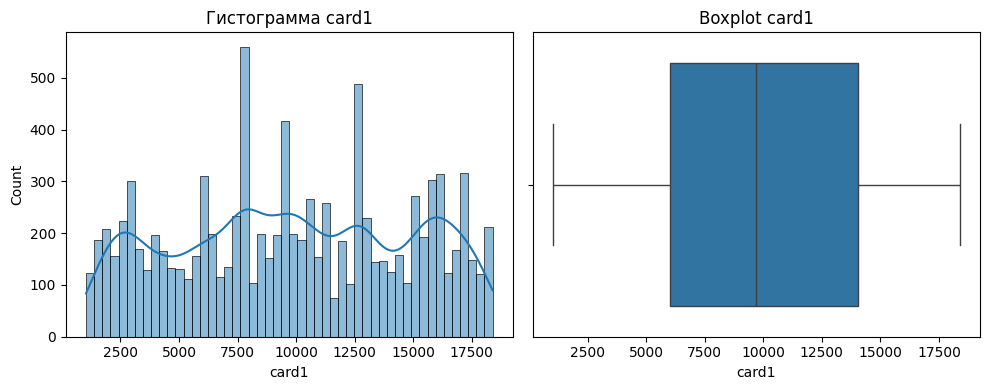

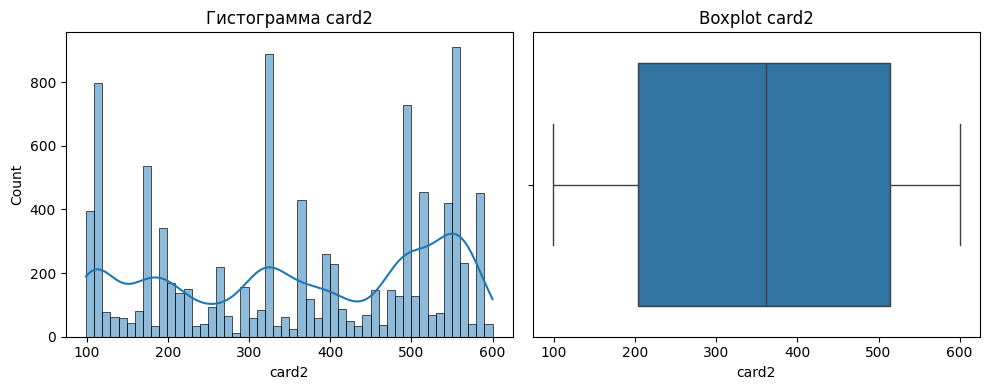

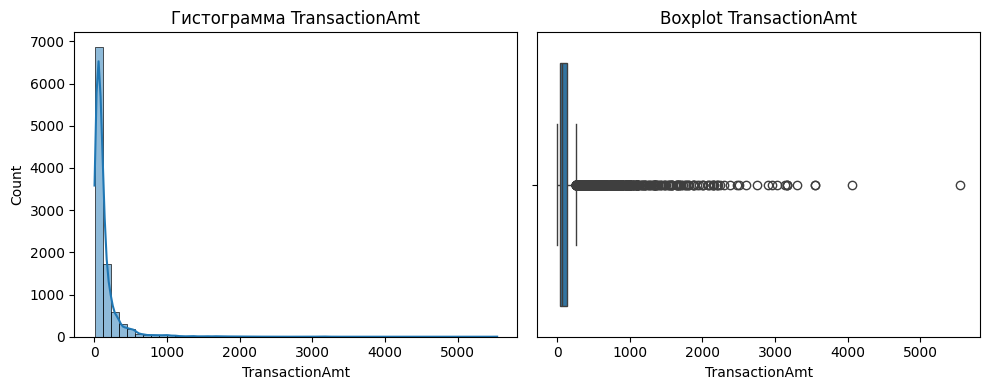

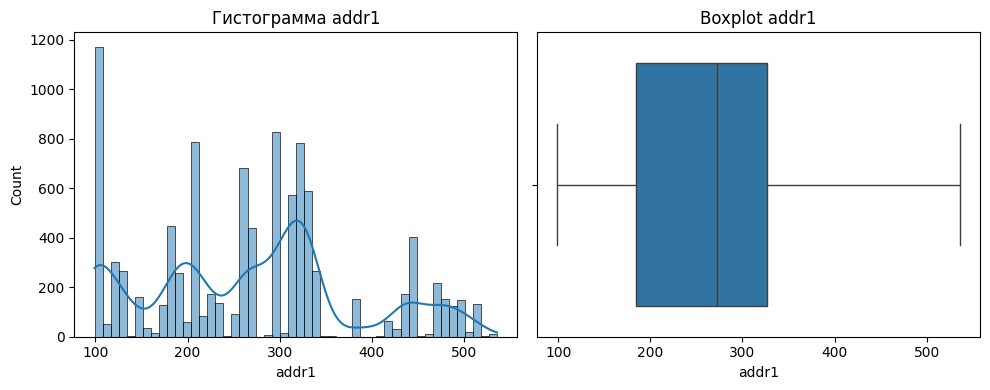

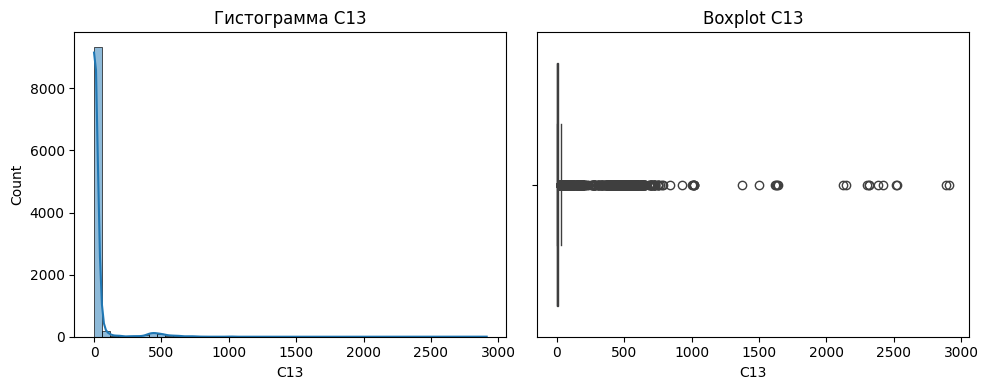

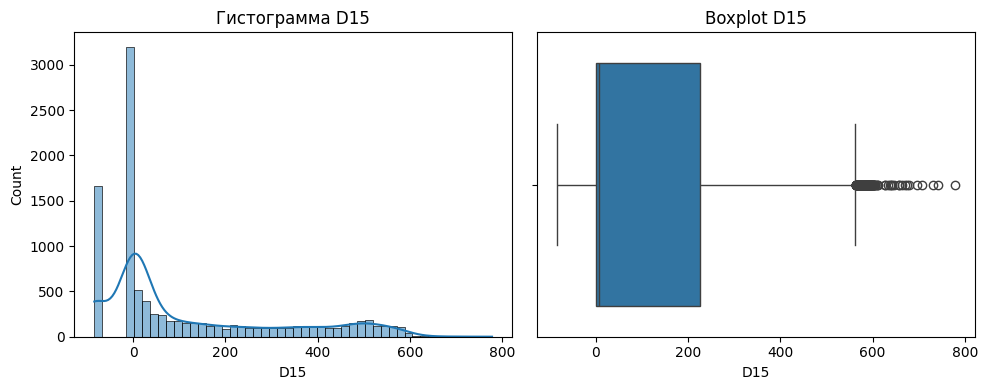

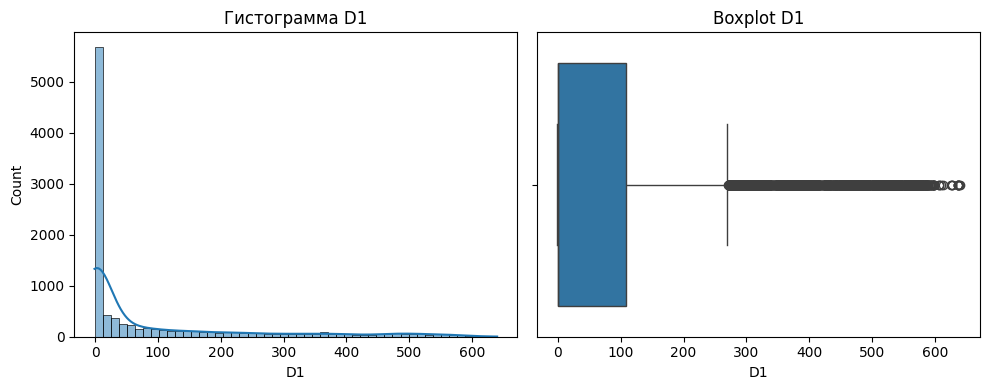

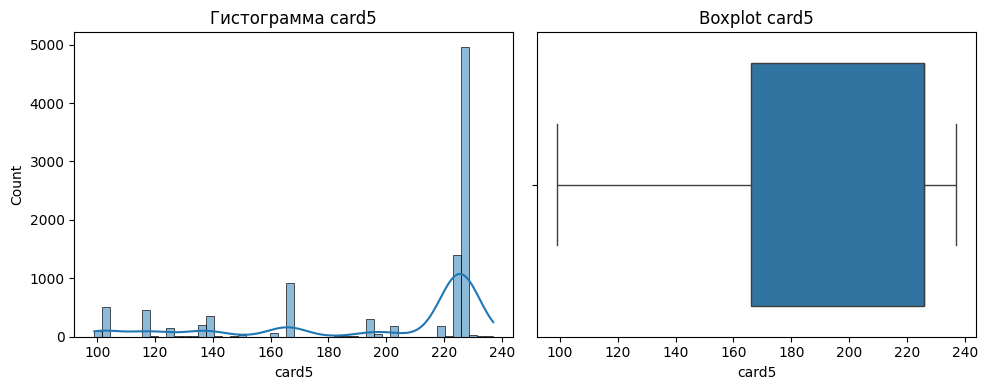

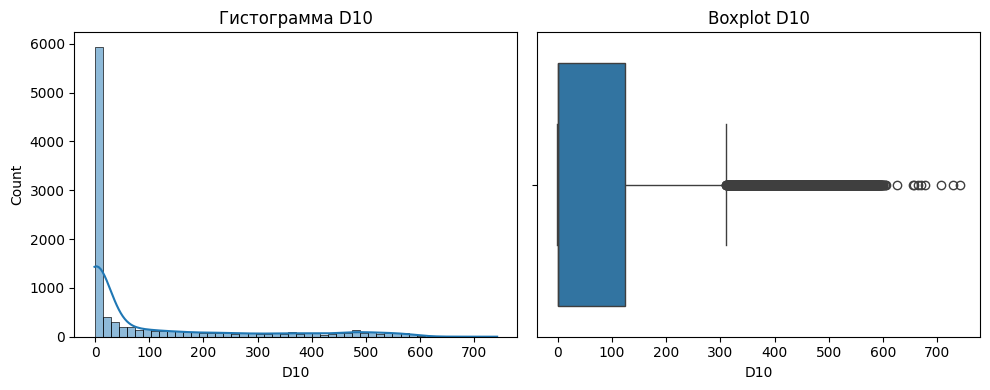

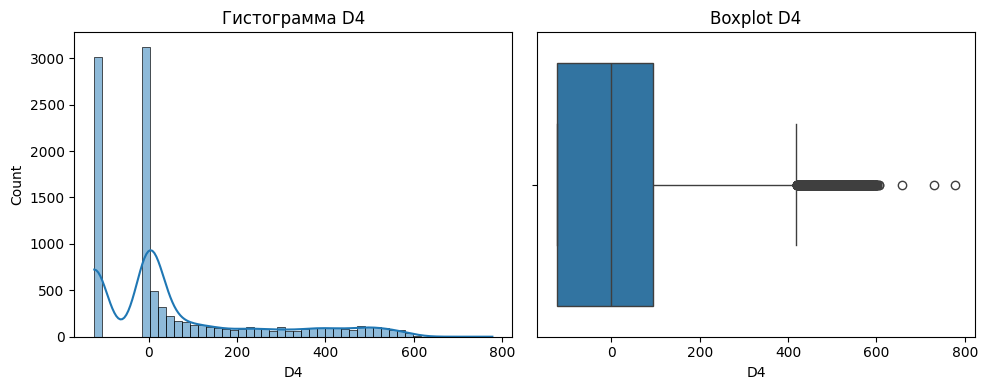

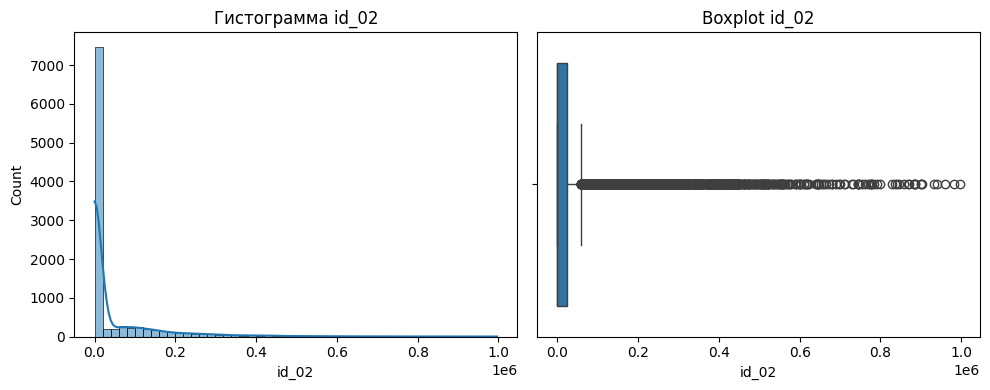

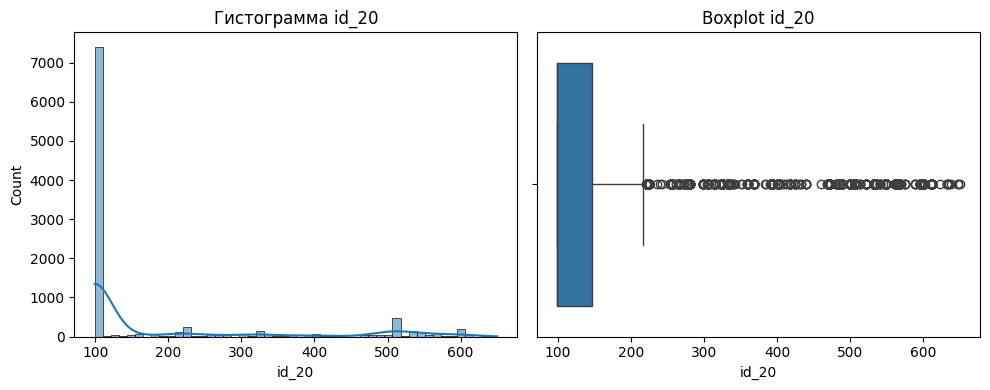

In [34]:
for feature in numeric_features:
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(df_sample[feature].dropna(), bins=50, kde=True)
    plt.title(f'Гистограмма {feature}')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_sample[feature].dropna())
    plt.title(f'Boxplot {feature}')

    plt.tight_layout()
    plt.show()

У признаков TransactionAmt, C13, D15, D1, D10, D4, id_02, id_20 есть много выбросов. Но убирать мы их не будем, так как скорее всего эти выбросы так или иначе указывают на фрод, что и является аномалией.

In [35]:
df_train['isFraud'].value_counts()

isFraud
0    402838
1     14721
Name: count, dtype: int64

In [36]:
df_train['isFraud'].value_counts(normalize=True)

isFraud
0    0.964745
1    0.035255
Name: proportion, dtype: float64

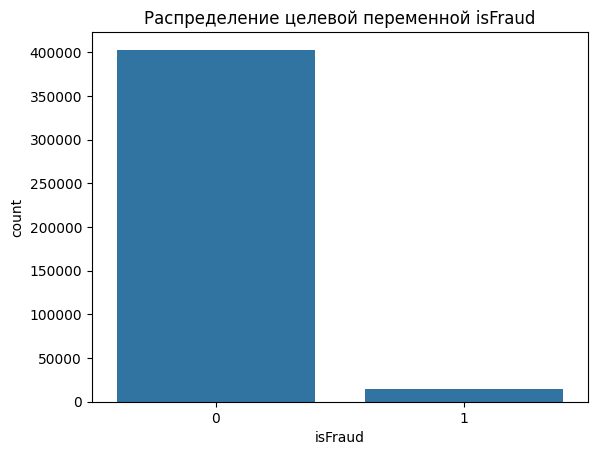

In [37]:
sns.countplot(x='isFraud', data=df_train)
plt.title("Распределение целевой переменной isFraud")
plt.show()

Дисбаланс классов очень большой. Но это норма для поиска аномалий.

In [ ]:
df_numeric = df_train.select_dtypes(include=['number'])
corr_matrix = df_numeric.corr()
target_corr = corr_matrix['isFraud'].sort_values(ascending=False)
print(target_corr)

isFraud    1.000000
V233       0.242233
V257       0.237378
V201       0.234609
V232       0.230089
             ...   
V29       -0.087860
V70       -0.095499
V69       -0.096320
addr2     -0.153369
V107            NaN
Name: isFraud, Length: 403, dtype: float64


In [ ]:
target_corr[:11]

isFraud    1.000000
V233       0.242233
V257       0.237378
V201       0.234609
V232       0.230089
V231       0.227987
V217       0.225890
V200       0.225011
V246       0.214599
V171       0.214517
V258       0.213525
Name: isFraud, dtype: float64

Теперь посмотрим на попарную корреляцию этих топ-10 признаков, коррелирующих с isFraud

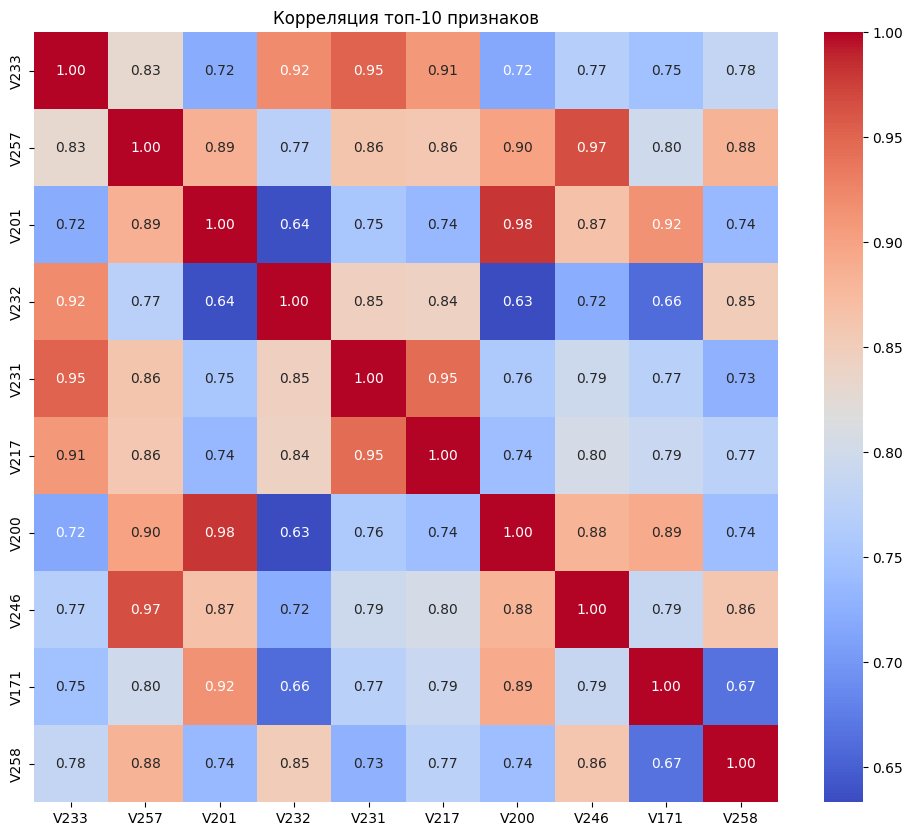

In [ ]:
top_features = target_corr[1:11].index
plt.figure(figsize=(12, 10))
sns.heatmap(df_train[top_features].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Корреляция топ-10 признаков")
plt.show()

Интересно. Они между собой сильно и положительно коррелируют.

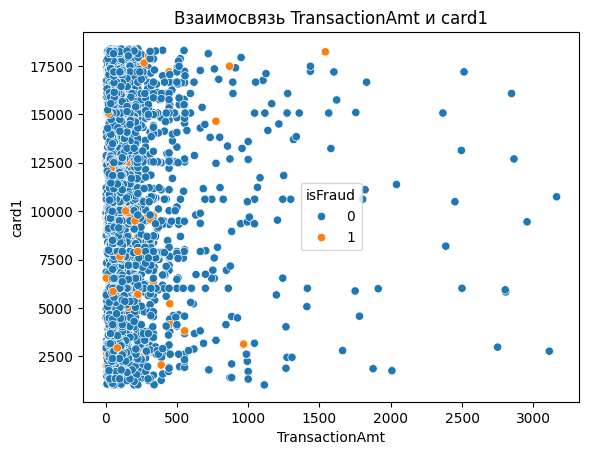

In [ ]:
sns.scatterplot(x='TransactionAmt', y='card1', hue='isFraud', data=df_train.sample(5000))
plt.title("Взаимосвязь TransactionAmt и card1")
plt.show()

А тут особо и нечего сказать, разве то, что при более 1000 транзакций почти нет фрода.
Теперь посмотрим на дубликаты в трейне.

In [38]:
num_duplicates = df_train.duplicated().sum()
print(f"Количество дубликатов: {num_duplicates}")

Количество дубликатов: 0


Посмотрим на пропуски

In [39]:
df_train.isnull().sum().sort_values(ascending=False)

id_27    413605
id_23    413605
id_33    359740
id_30    355463
id_34    355391
          ...  
V96           0
V95           0
V94           0
V93           0
V163          0
Length: 434, dtype: int64

In [40]:
df_train.shape, df_test.shape

((417559, 434), (172981, 433))

In [41]:
set(df_train.columns) - set(df_test.columns)

{'isFraud'}

In [42]:
set(df_test.columns) - set(df_train.columns)

set()

Заполним пропуски чуть попозже! Ниже устно опишу эксперименты с пропусками.

Числовые колонки пробовал заполнять медианными значениями, с заполнением Елены на -1 разницы в локальной и лидербордовой валидации не заметил.

А теперь сделаем Feature Engeneering из ноутбука с соревнования перед тем, как обучать ML модели, он там топовый!

Посмотрим на распределение значений числового признака 'TransactionAmt' в обучающей выборке:

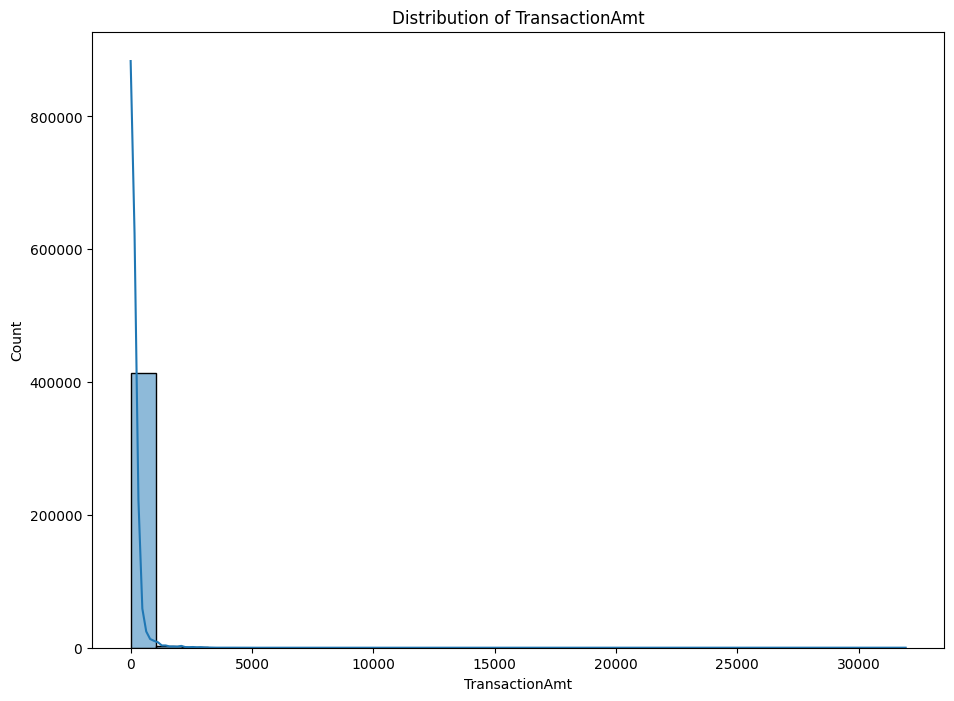

In [43]:
plt.figure(figsize=(11, 8))
sns.histplot(df_train['TransactionAmt'], bins=30, kde=True)
plt.xlabel('TransactionAmt')
plt.ylabel('Count')
plt.title('Distribution of TransactionAmt')
plt.show()

Как видно, распределение очень сильно смещено. Прологарифмируем признак и добавим результат в данные как новый:

In [44]:
df_train = df_train.copy()
df_test = df_test.copy()
df_train['TransactionAmt_log'] = np.log1p(df_train['TransactionAmt'])
df_test['TransactionAmt_log'] = np.log1p(df_test['TransactionAmt'])

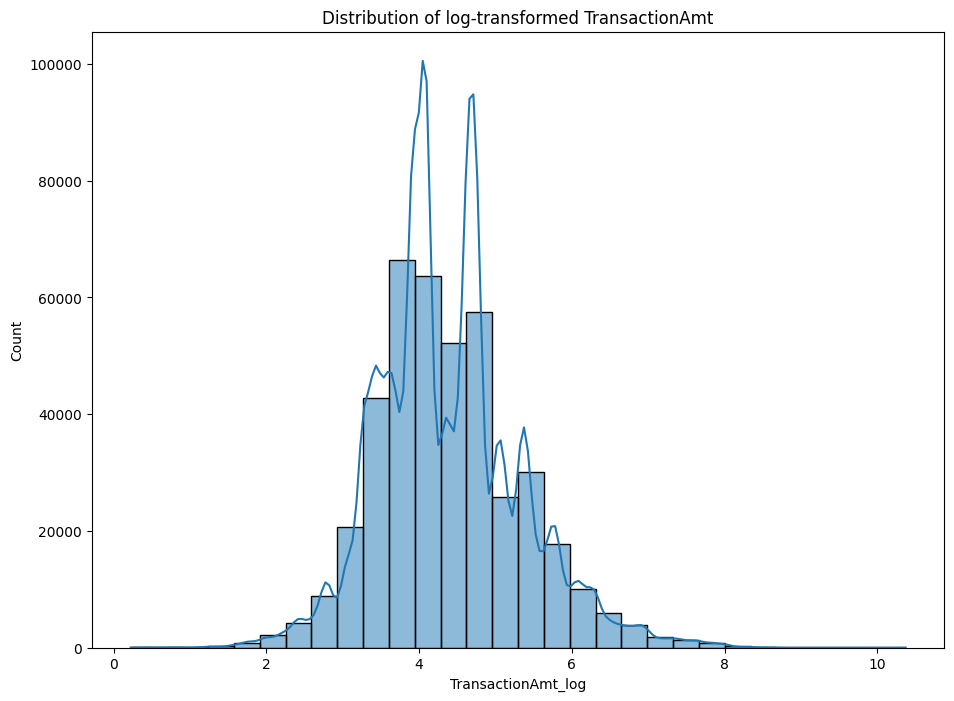

In [45]:
plt.figure(figsize=(11, 8))
sns.histplot(df_train['TransactionAmt_log'], bins=30, kde=True)
plt.xlabel('TransactionAmt_log')
plt.ylabel('Count')
plt.title('Distribution of log-transformed TransactionAmt')
plt.show()

Итак, распределение мы выровняли.
Заметим, что отнюдь не все суммы транзакций (в долларах) - целочисленные:

In [46]:
df_train['TransactionAmt'].value_counts()[:15]

<ipython-input-46-2dec1e3c2485>:1: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  df_train['TransactionAmt'].value_counts()[:15]


TransactionAmt
59.000000     20509
117.000000    19544
100.000000    16685
107.949997    15869
57.950001     15615
50.000000     14270
49.000000     10725
226.000000     7966
39.000000      7490
29.000000      7177
150.000000     6700
47.950001      6448
25.000000      6166
35.950001      5888
171.000000     5245
34.000000      5209
200.000000     5183
30.950001      5082
77.000000      4974
25.950001      4905
75.000000      4109
209.949997     4099
335.000000     3900
67.949997      3533
159.949997     3176
97.000000      3163
92.000000      2887
30.000000      2842
250.000000     2781
58.950001      2455
40.000000      2412
108.500000     2316
108.949997     2288
15.000000      2200
Name: count, dtype: int64

Это означает, что можно рассмотреть признак "количество центов" (вдруг мошенничество чаще совершается в случае "нецелых" транзакций?). Добавим его в данные и построим два его распределения: для мошеннических и обычных транзакций.

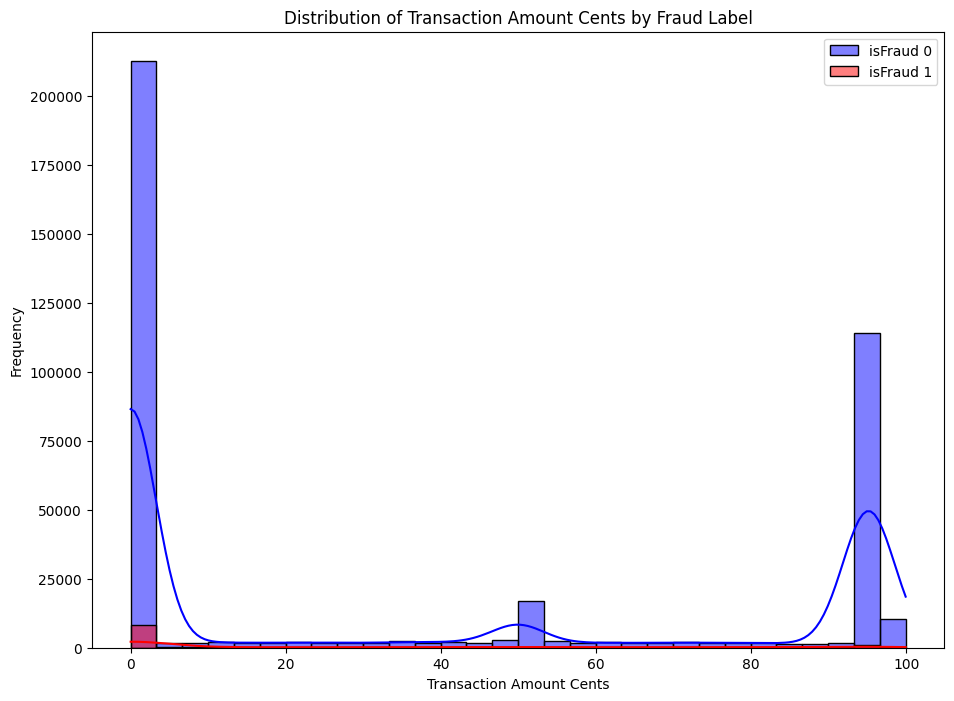

In [47]:
df_train['TransactionAmt_Cents'] = (df_train['TransactionAmt'] % 1) * 100
df_test['TransactionAmt_Cents'] = (df_test['TransactionAmt'] % 1) * 100

plt.figure(figsize=(11, 8))
sns.histplot(df_train[df_train['isFraud'] == 0]['TransactionAmt_Cents'], bins=30, kde=True, label='isFraud 0', color='blue')
sns.histplot(df_train[df_train['isFraud'] == 1]['TransactionAmt_Cents'], bins=30, kde=True, label='isFraud 1', color='red')
plt.legend(loc='best')
plt.xlabel('Transaction Amount Cents')
plt.ylabel('Frequency')
plt.title('Distribution of Transaction Amount Cents by Fraud Label')
plt.show()

Из имеющихся признаков можно извлекать новые. Многие признаки анонимизированы, однако есть достаточно понятные - скажем, почта или OS устройства, с которого совершалась транзакция. Извлечем новый признак - окончание почты, который может нести в себе какую-нибудь информацию - например, информацию о стране (если название домена заканчивается на .fr).

In [48]:
df_train.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5   card6  addr1  addr2  dist1  dist2  \
0     99    150    discover    142  credit    315     87     19     -1   
1    404    150  mastercard    102  credit    325     87     -1     -1   
2    490    150        visa    166   debit    330     87    287     -1   
3    567    150  mastercard    117   debit    476     87     -1     -1   
4    514    150  mastercard    102  credit    420     87     -1     -1   

  P_emaildomain R_emaildomain  C1  C2  C3  C4  C5  C6  C7  C8  C9  C10  C11  \
0           NaN           NaN   1   1   0   0   0   1   0   0   1    0    2   
1     gmail.com           NaN   1   1   0   0   0   1   0   0   0    0    1   
2   outlook.com           NaN   1   1   0   0   0   1   0   0   1    0    1   
3     yahoo.com           NaN   2   5   0   0   0   4   0   0   1    0    1   
4     gmail.com           NaN   1   1   0   0   0   1   0   1   0    1    1   

   C12  C13  C14   D1   D2  D3   D4  D5  D6  D7   D8   D9  D10  D11  D12  D13  \
0    0    1    1   14   -1  13 -123  -1 -84  -1 -1.0 -1.0   13   13  -84   -1   
1    0    1    1    0   -1  -1    0  -1 -84  -1 -1.0 -1.0    0  -54  -84   -1   
2    0    1    1    0   -1  -1    0  -1 -84  -1 -1.0 -1.0    0  315  -84   -1   
3    0   25    1  112  112   0   94   0 -84  -1 -1.0 -1.0   84  -54  -84   -1   
4    0    1    1    0   -1  -1 -123  -1 -84  -1 -1.0 -1.0   -1  -54  -84   -1   

   D14  D15   M1   M2   M3   M4   M5   M6   M7   M8   M9  V1  V2  V3  V4  V5  \
0 -194    0    T    T    T   M2    F    T  NaN  NaN  NaN   1   1   1   1   1   
1 -194    0  NaN  NaN  NaN   M0    T    T  NaN  NaN  NaN  -1  -1  -1  -1  -1   
2 -194  315    T    T    T   M0    F    F    F    F    F   1   1   1   1   1   
3 -194  111  NaN  NaN  NaN   M0    T    F  NaN  NaN  NaN  -1  -1  -1  -1  -1   
4 -194  -84  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  -1  -1  -1  -1  -1   

   V6  V7  V8  V9  V10  V11  V12  V13  V14  V15  V16  V17  V18  V19  V20  V21  \
0   1   1   1   1    0    0    1    1    1    0    0    0    0    1    1    0   
1  -1  -1  -1  -1   -1   -1    0    0    1    0    0    0    0    1    1    0   
2   1   1   1   1    0    0    1    1    1    0    0    0    0    1    1    0   
3  -1  -1  -1  -1   -1   -1    1    1    1    0    0    0    0    1    1    0   
4  -1  -1  -1  -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   

   V22  V23  V24  V25  V26  V27  V28  V29  V30  V31  V32  V33  V34  V35  V36  \
0    0    1    1    1    1    0    0    0    0    0    0    0    0   -1   -1   
1    0    1    1    1    1    0    0    0    0    0    0    0    0    0    0   
2    0    1    1    1    1    0    0    0    0    0    0    0    0    1    1   
3    0    1    1    1    1    0    0    0    0    0    0    0    0    1    1   
4   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   

   V37  V38  V39  V40  V41  V42  V43  V44  V45  V46  V47  V48  V49  V50  V51  \
0   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   
1    1    1    0    0    1    0    0    1    1    1    1    0    0    0    0   
2    1    1    0    0    1    0    0    1    1    1    1    0    0    0    0   
3    1    1    0    0    1    0    0    1    1    1    1    0    0    0    0   
4   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   

   V52  V53  V54  V55  V56  V57  V58  V59  V60  V61  V62  V63  V64  V65  V66  \
0   -1    1    1    1    1    0    0    0    0    1    1    0    0    1    1   
1    0    0    0    1    1    0    0    0  

In [49]:
for col in ['P_emaildomain', 'R_emaildomain']:
    df_train[col + '_suffix'] = df_train[col].map(lambda x: str(x).split('.')[-1])
    df_test[col + '_suffix'] = df_test[col].map(lambda x: str(x).split('.')[-1])

df_train[['P_emaildomain', 'P_emaildomain_suffix', 'R_emaildomain', 'R_emaildomain_suffix']].tail(10)

P_emaildomain P_emaildomain_suffix R_emaildomain R_emaildomain_suffix
417549      gmail.com                  com           NaN                  nan
417550      gmail.com                  com           NaN                  nan
417551        att.net                  net           NaN                  nan
417552  anonymous.com                  com           NaN                  nan
417553      yahoo.com                  com           NaN                  nan
417554      gmail.com                  com           NaN                  nan
417555      gmail.com                  com           NaN                  nan
417556    hotmail.com                  com   hotmail.com                  com
417557      gmail.com                  com           NaN                  nan
417558      gmail.com                  com           NaN                  nan

Новые признаки можно извлекать на основании сочетаний некоторых имеющихся. Например, добавим в данные признак, отвечающий за то, совпадают ли домены покупателя и получателя - вдруг это что-то даст.

In [50]:
df_train['same_emaildomain'] = (df_train['P_emaildomain'] == df_train['R_emaildomain']).astype('uint8')
df_test['same_emaildomain'] = (df_test['P_emaildomain'] == df_test['R_emaildomain']).astype('uint8')
df_train[['P_emaildomain', 'R_emaildomain', 'same_emaildomain']].tail()

P_emaildomain R_emaildomain  same_emaildomain
417554     gmail.com           NaN                 0
417555     gmail.com           NaN                 0
417556   hotmail.com   hotmail.com                 1
417557     gmail.com           NaN                 0
417558     gmail.com           NaN                 0

Можно комбинировать признаки - производить арифметические операции между числовыми признаками, использовать сочетания категориальных. Такие комбинации иногда позволяют породить мощные признаки. Например, если какие-то из признаков 'card1'-'card6' и 'addr1'-'addr2' содержат важную информацию о клиенте, то объединение некоторых из них может помочь лучше идентифицировать клиента и факт мошенничества в транзакции. Главное не переусердствовать - если признаки содержат очень много категорий, то их объединение скорее всего приведет к появлению признака с колоссальным количеством категорий, что в свою очередь может привести к ухудшению качества. Из полученного признака тогда можно извлечь какую-то информацию с помощью группировки и агрегирования, но оставлять его просто так, скорее всего, опасно. Чтобы понять, о чем речь, попробуйте объединить признаки 'card1' и 'card2' - это два самых важных признака для модели из бейзлайна.

В данном случае скомбинируем признаки 'card3' и 'card5' - они входят в топ-50 важных признаков для модели из бейзлайна.

In [51]:
df_train['card3_card5'] = df_train['card3'].astype(str) + '_' + df_train['card5'].astype(str)
df_test['card3_card5'] = df_test['card3'].astype(str) + '_' + df_test['card5'].astype(str)
df_train[['card3', 'card5', 'card3_card5']].head(10)

card3  card5 card3_card5
0    150    142     150_142
1    150    102     150_102
2    150    166     150_166
3    150    117     150_117
4    150    102     150_102
5    150    226     150_226
6    150    166     150_166
7    150    226     150_226
8    150    226     150_226
9    150    224     150_224

In [52]:
for col in ['card3', 'card5', 'card3_card5']:
    print('Number of categories in train for {}: {}'.format(col, df_train[col].nunique()))

Number of categories in train for card3: 106
Number of categories in train for card5: 111
Number of categories in train for card3_card5: 553


Можно также закодировать категориальные признаки, исходя из их частоты встречаемости в выборке.

In [53]:
for col in ['card1', 'card2']:
    card_freq = df_train[col].value_counts().to_dict()
    df_train['{}_cnt'.format(col)] = df_train[col].map(card_freq)
    df_test['{}_cnt'.format(col)] = df_test[col].map(card_freq)
df_train[['card1', 'card1_cnt', 'card2', 'card2_cnt']].head(10)

card1  card1_cnt  card2  card2_cnt
0  13926         29     99       6563
1   2755        526    404       2371
2   4663        778    490      26366
3  18132       2970    567       4329
4   4497          9    514      10587
5   5937          6    555      29919
6  12308        163    360      10518
7  12695       4837    490      26366
8   2803       4291    100       5372
9  17399       1293    111      31710

Наконец, можно использовать агрегирование и группировку. Например, наряду с 'card1' и 'card2', одним из важнейших признаков для модели в бейзлайне является 'TransactionAmt'. Давайте добавим в данные признаки, отвечающие за среднюю, медианную, максимальную и минимальную суммы покупок для каждой категории в 'card1' и 'card2'.

In [54]:
new_cols = []
for col in ['card1', 'card2']:
    for agg_type in ['mean', 'median', 'min', 'max']:
        agg_col_name = 'TransactionAmt_{}_{}'.format(col, agg_type)
        card_agg = df_train.groupby(col)['TransactionAmt'].agg([agg_type]).rename({agg_type: agg_col_name}, axis=1)
        df_train = df_train.merge(card_agg, how='left', on=col)
        df_test = df_test.merge(card_agg, how='left', on=col)
        new_cols.append(agg_col_name)
df_train[['TransactionAmt', 'card1'] + new_cols[:4] + ['card2'] + new_cols[4:]].head(10)

TransactionAmt  card1  TransactionAmt_card1_mean  \
0            68.5  13926                 368.656219   
1            29.0   2755                 243.561661   
2            59.0   4663                  96.343185   
3            50.0  18132                 122.751434   
4            50.0   4497                 105.083336   
5            49.0   5937                 148.250000   
6           159.0  12308                 107.105888   
7           422.5  12695                 143.267792   
8            15.0   2803                 145.065323   
9           117.0  17399                 127.806297   

   TransactionAmt_card1_median  TransactionAmt_card1_min  \
0                   150.000000                     40.00   
1                   108.949997                     10.00   
2                    59.000000                     12.50   
3                    67.949997                      6.00   
4                   108.949997                     30.00   
5                   144.000000                     49.00   
6                    59.000000                     12.50   
7                    85.000000                      7.97   
8                    77.000000                      5.00   
9                    67.949997                     10.95   

   TransactionAmt_card1_max  card2  TransactionAmt_card2_mean  \
0               1343.140015     99                 177.598236   
1               6085.229980    404                 229.298630   
2                994.000000    490                 132.193436   
3               3190.000000    567                 131.370300   
4                200.000000    514                 217.431381   
5                317.500000    555                 125.474602   
6               2161.000000    360                  98.937828   
7               3162.949951    490                 132.193436   
8               3511.949951    100                 172.210480   
9               2775.000000    111                 148.041199   

   TransactionAmt_card2_median  TransactionAmt_card2_min  \
0                    78.500000                     5.000   
1                   108.949997                     5.000   
2                    77.000000                     0.424   
3                    77.949997                     6.000   
4                   102.000000                     5.000   
5                    68.094002                     0.272   
6                    58.950001                     5.000   
7                    77.000000                     0.424   
8                    92.000000                     5.000   
9                    87.949997                     3.500   

   TransactionAmt_card2_max  
0               3069.250000  
1               6085.229980  
2               6450.970215  
3               3190.000000  
4              31937.390625  
5               3594.949951  
6               3472.949951  
7               6450.970215  
8               5543.229980  
9               4301.950195

Напоследок отметим, что можно проводить также и отбор признаков - дело в том, что если в данных много неинформативных признаков, они могут лишь создать помехи при обучении. Способов отбора много, начиная от ручного и заканчивая специально разработанными для этого методами. В данном случае мы оставим все как есть.

После всех операций с признаками удалим столбец 'TransactionAmt', раз он уже есть у нас в логарифмированном виде - чтобы модель на него не отвлекалась.

In [55]:
df_train.drop('TransactionAmt', axis=1, inplace=True)
df_test.drop('TransactionAmt', axis=1, inplace=True)

In [56]:
df_train.head()

TransactionID  isFraud  TransactionDT ProductCD  card1  card2  card3  \
0        2987000        0          86400         W  13926     99    150   
1        2987001        0          86401         W   2755    404    150   
2        2987002        0          86469         W   4663    490    150   
3        2987003        0          86499         W  18132    567    150   
4        2987004        0          86506         H   4497    514    150   

        card4  card5   card6  addr1  addr2  dist1  dist2 P_emaildomain  \
0    discover    142  credit    315     87     19     -1           NaN   
1  mastercard    102  credit    325     87     -1     -1     gmail.com   
2        visa    166   debit    330     87    287     -1   outlook.com   
3  mastercard    117   debit    476     87     -1     -1     yahoo.com   
4  mastercard    102  credit    420     87     -1     -1     gmail.com   

  R_emaildomain  C1  C2  C3  C4  C5  C6  C7  C8  C9  C10  C11  C12  C13  C14  \
0           NaN   1   1   0   0   0   1   0   0   1    0    2    0    1    1   
1           NaN   1   1   0   0   0   1   0   0   0    0    1    0    1    1   
2           NaN   1   1   0   0   0   1   0   0   1    0    1    0    1    1   
3           NaN   2   5   0   0   0   4   0   0   1    0    1    0   25    1   
4           NaN   1   1   0   0   0   1   0   1   0    1    1    0    1    1   

    D1   D2  D3   D4  D5  D6  D7   D8   D9  D10  D11  D12  D13  D14  D15   M1  \
0   14   -1  13 -123  -1 -84  -1 -1.0 -1.0   13   13  -84   -1 -194    0    T   
1    0   -1  -1    0  -1 -84  -1 -1.0 -1.0    0  -54  -84   -1 -194    0  NaN   
2    0   -1  -1    0  -1 -84  -1 -1.0 -1.0    0  315  -84   -1 -194  315    T   
3  112  112   0   94   0 -84  -1 -1.0 -1.0   84  -54  -84   -1 -194  111  NaN   
4    0   -1  -1 -123  -1 -84  -1 -1.0 -1.0   -1  -54  -84   -1 -194  -84  NaN   

    M2   M3   M4   M5   M6   M7   M8   M9  V1  V2  V3  V4  V5  V6  V7  V8  V9  \
0    T    T   M2    F    T  NaN  NaN  NaN   1   1   1   1   1   1   1   1   1   
1  NaN  NaN   M0    T    T  NaN  NaN  NaN  -1  -1  -1  -1  -1  -1  -1  -1  -1   
2    T    T   M0    F    F    F    F    F   1   1   1   1   1   1   1   1   1   
3  NaN  NaN   M0    T    F  NaN  NaN  NaN  -1  -1  -1  -1  -1  -1  -1  -1  -1   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  -1  -1  -1  -1  -1  -1  -1  -1  -1   

   V10  V11  V12  V13  V14  V15  V16  V17  V18  V19  V20  V21  V22  V23  V24  \
0    0    0    1    1    1    0    0    0    0    1    1    0    0    1    1   
1   -1   -1    0    0    1    0    0    0    0    1    1    0    0    1    1   
2    0    0    1    1    1    0    0    0    0    1    1    0    0    1    1   
3   -1   -1    1    1    1    0    0    0    0    1    1    0    0    1    1   
4   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   

   V25  V26  V27  V28  V29  V30  V31  V32  V33  V34  V35  V36  V37  V38  V39  \
0    1    1    0    0    0    0    0    0    0    0   -1   -1   -1   -1   -1   
1    1    1    0    0    0    0    0    0    0    0    0    0    1    1    0   
2    1    1    0    0    0    0    0    0    0    0    1    1    1    1    0   
3    1    1    0    0    0    0    0    0    0    0    1    1    1    1    0   
4   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   

   V40  V41  V42  V43  V44  V45  V46  V47  V48  V49  V50  V51  V52  V53  V54  \
0   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1    1    1   
1    0    1    0    0    1    1    1    1    0    0    0    0    0    0    0   
2    0    1    0    0    1    1    1    1    0    0    0    0    0    1    1   
3    0    1    0    0    1    1    1    1    0    0    0    0    0    1    1   
4   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   

   V55  V56  V57  V58  V59  V60  V61  V62  V63  V64  V65  V66  V67  V68  V69  \
0    1    1    0    0    0    0    1    1    0    0    1    1    1    0    0   
1    1    1    0    0    0    0    1    1    0   

А теперь то, что я смог придумать сам. Сделаем для id_33 новые признаки:

In [57]:
df_train.shape, df_test.shape

((417559, 449), (172981, 448))

In [58]:
for df in [df_train, df_test]:
    df[['id_33_width', 'id_33_height']] = (
        df['id_33']
        .dropna()
        .str.split('x', expand=True)
        .astype(float)
    )

    df[['id_33_width', 'id_33_height']] = df[['id_33_width', 'id_33_height']].fillna(0)
    df['id_33_pixels'] = df['id_33_width'] * df['id_33_height']

    df.drop(columns=['id_33'], inplace=True, errors='ignore')

In [59]:
df_train.shape, df_test.shape

((417559, 451), (172981, 450))

Колонки М - совпадения (true, false, unseen_category). Давайте их суммируем.

In [60]:
m_cols = ['M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9']

for df in [df_train, df_test]:
    temp_df = df[m_cols].replace({'T': 2, 'F': 1}).fillna(0)
    df['M_sum'] = temp_df.sum(axis=1)

<ipython-input-60-fb6ba5e11ecb>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp_df = df[m_cols].replace({'T': 2, 'F': 1}).fillna(0)
<ipython-input-60-fb6ba5e11ecb>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp_df = df[m_cols].replace({'T': 2, 'F': 1}).fillna(0)


In [61]:
df_train.shape, df_test.shape

((417559, 452), (172981, 451))

А теперь наконец-то заполним пропуски.

In [62]:
for col in tqdm(df_train.columns.drop('isFraud')):
    if df_train[col].dtype == 'O':
        df_train[col] = df_train[col].fillna('unseen_category')
        df_test[col] = df_test[col].fillna('unseen_category')
    else:
        df_train[col] = df_train[col].fillna(-1)
        df_test[col] = df_test[col].fillna(-1)

100%|██████████| 451/451 [00:03<00:00, 138.26it/s]


Сохраним датасеты на будущее.

In [63]:
df_train_final = df_train.copy()
df_test_final = df_test.copy()

In [64]:
df_train_final.head()

TransactionID  isFraud  TransactionDT ProductCD  card1  card2  card3  \
0        2987000        0          86400         W  13926     99    150   
1        2987001        0          86401         W   2755    404    150   
2        2987002        0          86469         W   4663    490    150   
3        2987003        0          86499         W  18132    567    150   
4        2987004        0          86506         H   4497    514    150   

        card4  card5   card6  addr1  addr2  dist1  dist2    P_emaildomain  \
0    discover    142  credit    315     87     19     -1  unseen_category   
1  mastercard    102  credit    325     87     -1     -1        gmail.com   
2        visa    166   debit    330     87    287     -1      outlook.com   
3  mastercard    117   debit    476     87     -1     -1        yahoo.com   
4  mastercard    102  credit    420     87     -1     -1        gmail.com   

     R_emaildomain  C1  C2  C3  C4  C5  C6  C7  C8  C9  C10  C11  C12  C13  \
0  unseen_category   1   1   0   0   0   1   0   0   1    0    2    0    1   
1  unseen_category   1   1   0   0   0   1   0   0   0    0    1    0    1   
2  unseen_category   1   1   0   0   0   1   0   0   1    0    1    0    1   
3  unseen_category   2   5   0   0   0   4   0   0   1    0    1    0   25   
4  unseen_category   1   1   0   0   0   1   0   1   0    1    1    0    1   

   C14   D1   D2  D3   D4  D5  D6  D7   D8   D9  D10  D11  D12  D13  D14  D15  \
0    1   14   -1  13 -123  -1 -84  -1 -1.0 -1.0   13   13  -84   -1 -194    0   
1    1    0   -1  -1    0  -1 -84  -1 -1.0 -1.0    0  -54  -84   -1 -194    0   
2    1    0   -1  -1    0  -1 -84  -1 -1.0 -1.0    0  315  -84   -1 -194  315   
3    1  112  112   0   94   0 -84  -1 -1.0 -1.0   84  -54  -84   -1 -194  111   
4    1    0   -1  -1 -123  -1 -84  -1 -1.0 -1.0   -1  -54  -84   -1 -194  -84   

                M1               M2               M3               M4  \
0                T                T                T               M2   
1  unseen_category  unseen_category  unseen_category               M0   
2                T                T                T               M0   
3  unseen_category  unseen_category  unseen_category               M0   
4  unseen_category  unseen_category  unseen_category  unseen_category   

                M5               M6               M7               M8  \
0                F                T  unseen_category  unseen_category   
1                T                T  unseen_category  unseen_category   
2                F                F                F                F   
3                T                F  unseen_category  unseen_category   
4  unseen_category  unseen_category  unseen_category  unseen_category   

                M9  V1  V2  V3  V4  V5  V6  V7  V8  V9  V10  V11  V12  V13  \
0  unseen_category   1   1   1   1   1   1   1   1   1    0    0    1    1   
1  unseen_category  -1  -1  -1  -1  -1  -1  -1  -1  -1   -1   -1    0    0   
2                F   1   1   1   1   1   1   1   1   1    0    0    1    1   
3  unseen_category  -1  -1  -1  -1  -1  -1  -1  -1  -1   -1   -1    1    1   
4  unseen_category  -1  -1  -1  -1  -1  -1  -1  -1  -1   -1   -1   -1   -1   

   V14  V15  V16  V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  \
0    1    0    0    0    0    1    1    0    0    1    1    1    1    0    0   
1    1    0    0    0    0    1    1    0    0    1    1    1    1    0    0   
2    1    0    0    0    0    1    1    0    0    1    1    1    1    0    0   
3    1    0    0    0    0    1    1    0    0    1    1    1    1    0    0   
4   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   

   V29  V30  V31  V32  V33  V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  \
0    0    0    0    0    0    0   -1   -1   -1   -1   -1   -1   -1   -1   -1   
1    0    0    0    0    0    0    0    0    1    1    0    0    1    0    0   
2    0    0    0    0    0    0    1    1    1    1    0    0    

# **Задание 2 (3 балла)**

Обучите несколько ML-моделей для решения поставленной задачи.
Оцените их качество двумя способами:

1) на кросс-валидации

2) на лидерборде

Подберите число фолдов на кросс-валидации так, чтобы метрики, которые вы видите, были максимально близки на кросс-валидации и на лидерборде.

По результатам экспериментов постройте таблицу:
* в каждой строке таблицы - результаты одной модели
* по столбцам: качество на кросс-валидации, качество на лидерборде, модель с гиперпараметрами
Полученную таблицу вставьте картинкой прямо в ноутбук после ячеек с кодом. Сделайте текстовые выводы.

## 1. Обычная модель Елены

Я долго думал, почему же в time series Елена нам дала в бейзлайне обычный group kfold на 4 фолда, ведь мы, обучаясь на фолдах 2-3-4, например, валидируемся на 1 фолде, то есть заглядываем в прошлое. И понял я это через несколько дней различных экспериментов =)

In [ ]:
for col in tqdm(df_train.columns.drop('isFraud')):
    if df_train[col].dtype == 'O':
        le = LabelEncoder()
        le.fit(list(df_train[col]) + list(df_test[col]))
        df_train[col] = le.transform(df_train[col])
        df_test[col] = le.transform(df_test[col])
        df_train[col] = df_train[col].astype('category')
        df_test[col] = df_test[col].astype('category')

# выделяем фолды
month_length = 3600 * 24 * 30
fold0_idx = df_train[df_train['TransactionDT'] < df_train['TransactionDT'].min() + month_length].index
fold1_idx = df_train[(df_train['TransactionDT'].min() + month_length <= df_train['TransactionDT']) & (df_train['TransactionDT'] < df_train['TransactionDT'].min() + 2 * month_length)].index
fold2_idx = df_train[(df_train['TransactionDT'].min() + 2 * month_length <= df_train['TransactionDT']) & (df_train['TransactionDT'] < df_train['TransactionDT'].min() + 3 * month_length)].index
fold3_idx = df_train[df_train['TransactionDT'].min() + 3 * month_length <= df_train['TransactionDT']].index
folds_idx = [fold0_idx, fold1_idx, fold2_idx, fold3_idx]

# выделяем идентификационный и временной признаки
df_train.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_test.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)

100%|██████████| 451/451 [00:37<00:00, 11.98it/s]


In [ ]:
%%time

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'n_jobs': -1,
    'n_estimators': 2000,
    'seed': 777,
    'early_stopping_rounds': 200,
}

scores = []

feature_importances = pd.DataFrame()
feature_importances['feature'] = df_train.columns.drop('isFraud')

test_preds = []

for i in range(len(folds_idx)):
    X_train = df_train.drop(folds_idx[i], axis=0)
    y_train = X_train['isFraud'].values
    X_val = df_train.iloc[folds_idx[i]]
    y_val = X_val['isFraud'].values
    X_train = X_train.drop('isFraud', axis=1)
    X_val = X_val.drop('isFraud', axis=1)

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_eval,
    callbacks=[
        lgb.early_stopping(stopping_rounds=200),
        lgb.log_evaluation(100)])

    feature_importances['fold_{}'.format(i)] = lgb_model.feature_importance()

    y_pred = lgb_model.predict(X_val)
    score_fold = roc_auc_score(y_val, y_pred)
    scores.append(score_fold)
    y_test_pred = lgb_model.predict(df_test)
    test_preds.append(y_test_pred)

for i in range(len(scores)):
    print('Fold {}, AUC-ROC: {:.5f}'.format(i, scores[i]))
print('CV AUC-ROC: {:.5f}'.format(np.mean(scores)))

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 11320, number of negative: 271900
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.212219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34436
[LightGBM] [Info] Number of data points in the train set: 283220, number of used features: 447
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.039969 -> initscore=-3.178863
[LightGBM] [Info] Start training from score -3.178863
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.891409
[200]	valid_0's auc: 0.90016
[300]	valid_0's auc: 0.9

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 11144, number of negative: 317016
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.541084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37382
[LightGBM] [Info] Number of data points in the train set: 328160, number of used features: 447
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033959 -> initscore=-3.348051
[LightGBM] [Info] Start training from score -3.348051
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.915296
[200]	valid_0's auc: 0.923497
[300]	valid_0's auc: 0.

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 10997, number of negative: 314373
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.541064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37282
[LightGBM] [Info] Number of data points in the train set: 325370, number of used features: 447
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033798 -> initscore=-3.352958
[LightGBM] [Info] Start training from score -3.352958
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.922312
[200]	valid_0's auc: 0.927685
[300]	valid_0's auc: 0.

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 10702, number of negative: 305225
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.738275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37389
[LightGBM] [Info] Number of data points in the train set: 315927, number of used features: 447
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033875 -> initscore=-3.350619
[LightGBM] [Info] Start training from score -3.350619
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.903238
[200]	valid_0's auc: 0.906677
[300]	valid_0's auc: 0.

CV AUC-ROC: 0.91886  
Kaggle Score: 0.91922

Неплохая корреляция CV с лидербордом! Захардкодим метрики для конечной таблицы, так как перезапускать ради этого с десяток экспериментом не хочется.

In [66]:
model_1_lgb_base_cv = 0.91886
model_1_lgb_base_kaggle = 0.91922

In [ ]:
fold_cols = [col for col in feature_importances.columns if col.startswith('fold_')]
feature_importances['average'] = feature_importances[fold_cols].mean(axis=1)
feature_importances.head()

feature  fold_0  fold_1  fold_2  fold_3  average
0  ProductCD      30      47      34      38    37.25
1      card1     411     928     313     355   501.75
2      card2     292     503     186     236   304.25
3      card3      11      16       4      10    10.25
4      card4       9      13       0       7     7.25

<ipython-input-79-38e95bf7c8d0>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature', palette="BuGn_r")


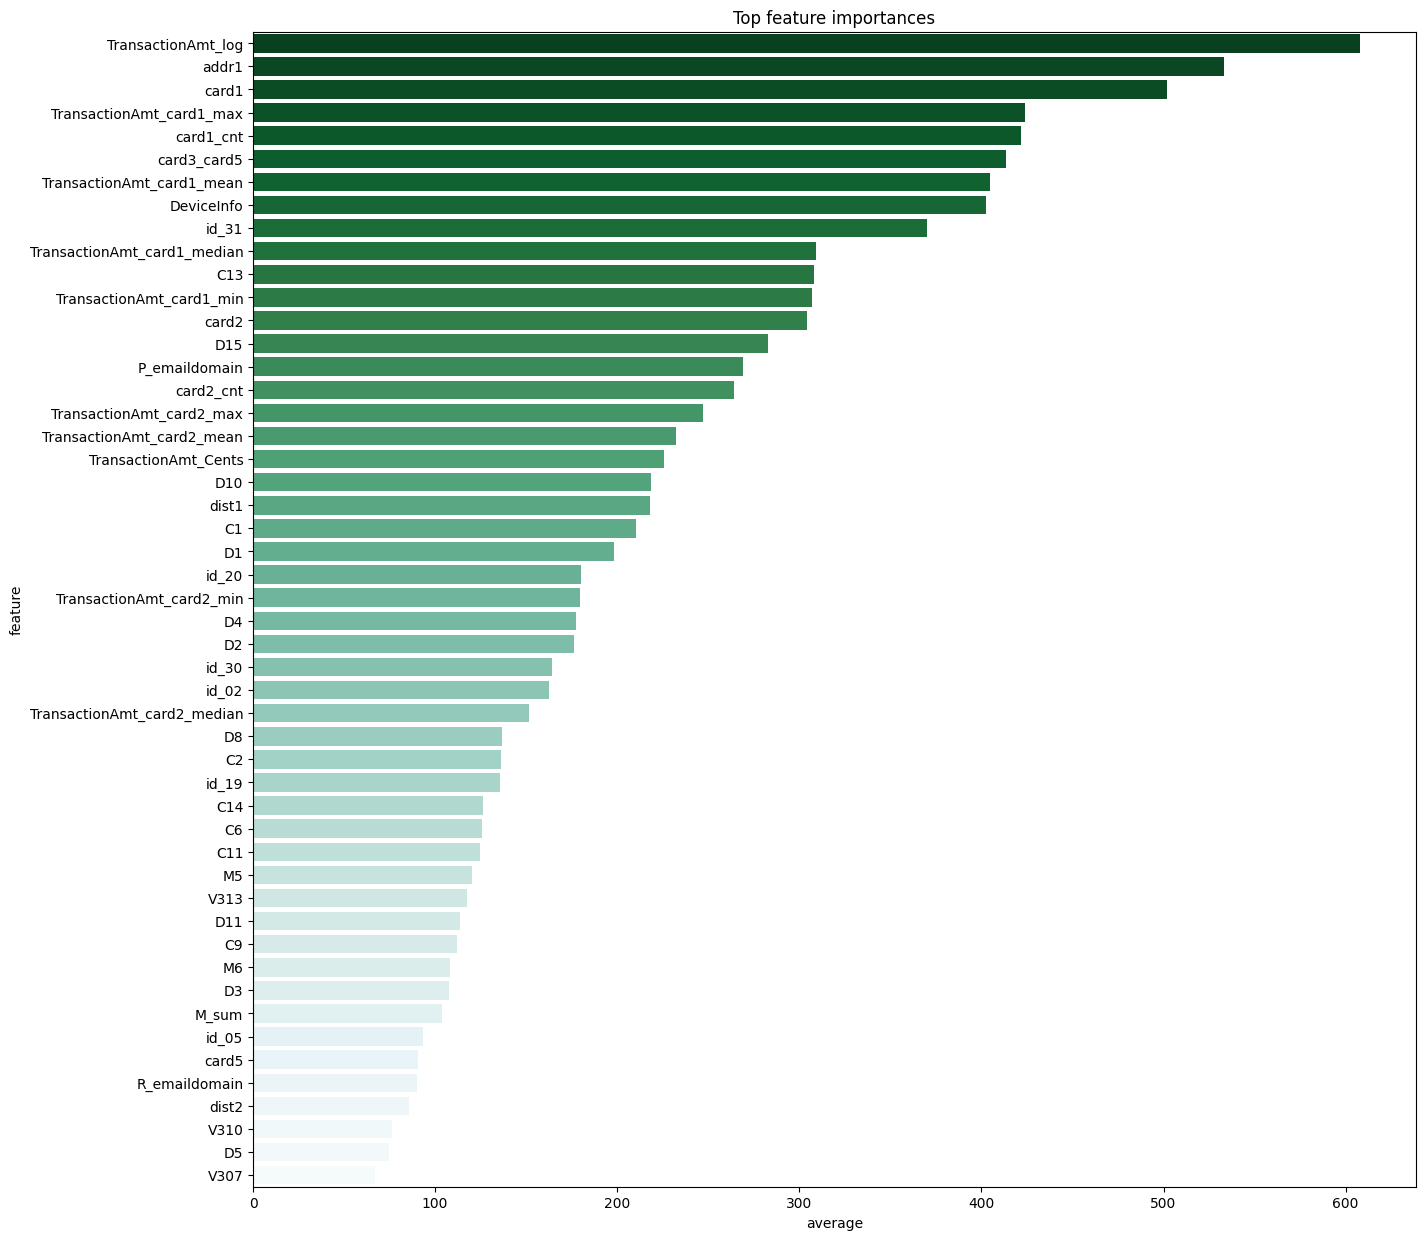

In [ ]:
plt.figure(figsize=(15, 15))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature', palette="BuGn_r")
plt.title('Top feature importances')
plt.show()

Видим, что количество транзакций, а также card1 и addr1 значат очень многое для модели. Интересно!

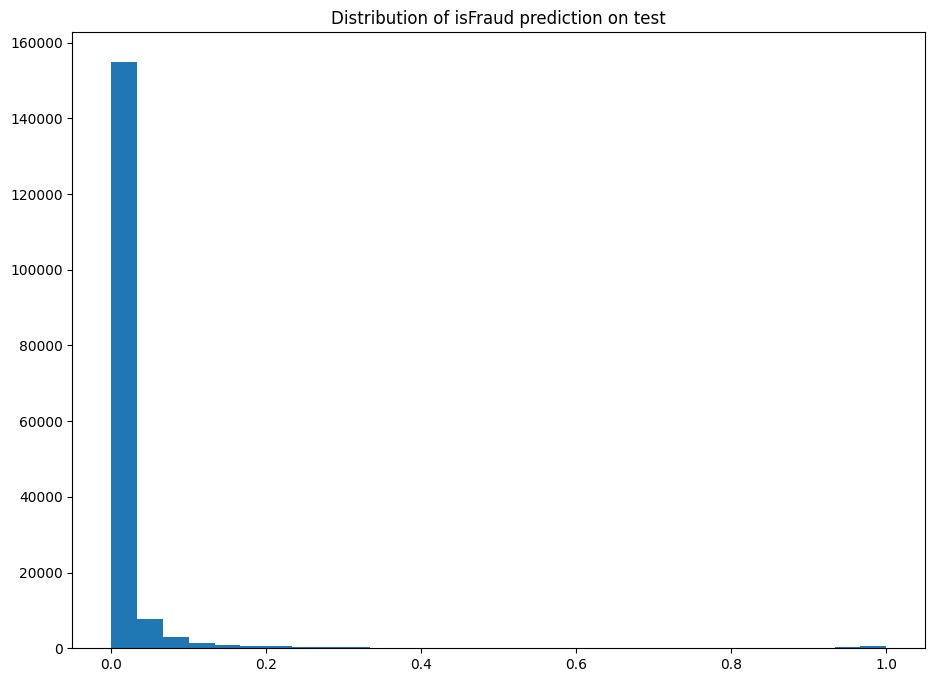

In [ ]:
final_pred = np.average(test_preds, axis=0)
sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': final_pred})
sub.to_csv('submission_baseline_fe_0.csv', index=False)

plt.figure(figsize=(11, 8))
plt.hist(sub['isFraud'], bins=30)
plt.title('Distribution of isFraud prediction on test')
plt.show()

Следующая моделька

In [ ]:
cat_cols_final = df_train.select_dtypes(include=['object']).columns.tolist()

In [ ]:
encoder = TargetEncoder(cols=cat_cols_final)
df_train[cat_cols_final] = encoder.fit_transform(df_train[cat_cols_final], df_train['isFraud'])
df_test[cat_cols_final] = encoder.transform(df_test[cat_cols_final])

In [ ]:
df_train.shape, df_test.shape

((417559, 452), (172981, 451))

In [ ]:
df_train.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417559 entries, 0 to 417558
Columns: 452 entries, TransactionID to M_sum
dtypes: float32(89), float64(37), int16(53), int64(2), int8(230), uint16(22), uint32(3), uint8(16)
memory usage: 428.5 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172981 entries, 0 to 172980
Columns: 451 entries, TransactionID to M_sum
dtypes: float32(89), float64(38), int16(53), int64(1), int8(229), uint16(22), uint32(3), uint8(16)
memory usage: 177.3 MB


(None, None)

Теперь посмотрим на схему валидации из ноутбука Елены:

In [ ]:
df_train.head()

TransactionID  isFraud  TransactionDT  ProductCD  card1  card2  card3  \
0        2987000        0          86400   0.020820  13926     99    150   
1        2987001        0          86401   0.020820   2755    404    150   
2        2987002        0          86469   0.020820   4663    490    150   
3        2987003        0          86499   0.020820  18132    567    150   
4        2987004        0          86506   0.045116   4497    514    150   

      card4  card5     card6  addr1  addr2  dist1  dist2  P_emaildomain  \
0  0.066126    142  0.066129    315     87     19     -1       0.030149   
1  0.035626    102  0.066129    325     87     -1     -1       0.043920   
2  0.034724    166  0.024185    330     87    287     -1       0.089087   
3  0.035626    117  0.024185    476     87     -1     -1       0.023774   
4  0.035626    102  0.066129    420     87     -1     -1       0.043920   

   R_emaildomain  C1  C2  C3  C4  C5  C6  C7  C8  C9  C10  C11  C12  C13  C14  \
0       0.021323   1   1   0   0   0   1   0   0   1    0    2    0    1    1   
1       0.021323   1   1   0   0   0   1   0   0   0    0    1    0    1    1   
2       0.021323   1   1   0   0   0   1   0   0   1    0    1    0    1    1   
3       0.021323   2   5   0   0   0   4   0   0   1    0    1    0   25    1   
4       0.021323   1   1   0   0   0   1   0   1   0    1    1    0    1    1   

    D1   D2  D3   D4  D5  D6  D7   D8   D9  D10  D11  D12  D13  D14  D15  \
0   14   -1  13 -123  -1 -84  -1 -1.0 -1.0   13   13  -84   -1 -194    0   
1    0   -1  -1    0  -1 -84  -1 -1.0 -1.0    0  -54  -84   -1 -194    0   
2    0   -1  -1    0  -1 -84  -1 -1.0 -1.0    0  315  -84   -1 -194  315   
3  112  112   0   94   0 -84  -1 -1.0 -1.0   84  -54  -84   -1 -194  111   
4    0   -1  -1 -123  -1 -84  -1 -1.0 -1.0   -1  -54  -84   -1 -194  -84   

         M1        M2        M3        M4        M5        M6        M7  \
0  0.020217  0.018583  0.017271  0.109734  0.026658  0.017466  0.042954   
1  0.048321  0.048321  0.048321  0.037980  0.039652  0.017466  0.042954   
2  0.020217  0.018583  0.017271  0.037980  0.026658  0.024164  0.019515   
3  0.048321  0.048321  0.048321  0.037980  0.039652  0.024164  0.042954   
4  0.048321  0.048321  0.048321  0.019018  0.037076  0.066750  0.042954   

         M8        M9  V1  V2  V3  V4  V5  V6  V7  V8  V9  V10  V11  V12  V13  \
0  0.042954  0.042954   1   1   1   1   1   1   1   1   1    0    0    1    1   
1  0.042954  0.042954  -1  -1  -1  -1  -1  -1  -1  -1  -1   -1   -1    0    0   
2  0.021855  0.030734   1   1   1   1   1   1   1   1   1    0    0    1    1   
3  0.042954  0.042954  -1  -1  -1  -1  -1  -1  -1  -1  -1   -1   -1    1    1   
4  0.042954  0.042954  -1  -1  -1  -1  -1  -1  -1  -1  -1   -1   -1   -1   -1   

   V14  V15  V16  V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  \
0    1    0    0    0    0    1    1    0    0    1    1    1    1    0    0   
1    1    0    0    0    0    1    1    0    0    1    1    1    1    0    0   
2    1    0    0    0    0    1    1    0    0    1    1    1    1    0    0   
3    1    0    0    0    0    1    1    0    0    1    1    1    1    0    0   
4   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   

   V29  V30  V31  V32  V33  V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  \
0    0    0    0    0    0    0   -1   -1   -1   -1   -1   -1   -1   -1   -1   
1    0    0    0    0    0    0    0    0    1    1    0    0    1    0    0   
2    0    0    0    0    0    0    1    1    1    1    0    0    1    0    0   
3    0    0    0    0    0    0    1    1    1    1    0    0    1    0    0   
4   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   

   V44  V45  V46  V47  V48  V49  V50  V51  V52  V53  V54  V55  V56  V57  V58  \
0   -1   -1   -1   -1   -1   -1   -1   -1   -1    1    1    1    1    0    0   
1    1    1    1    1    0    0    0    0    0    0    0    1    1    0    0   
2    1    1

In [ ]:
# выделяем фолды
month_length = 3600 * 24 * 30
fold0_idx = df_train[df_train['TransactionDT'] < df_train['TransactionDT'].min() + month_length].index
fold1_idx = df_train[(df_train['TransactionDT'].min() + month_length <= df_train['TransactionDT']) & (df_train['TransactionDT'] < df_train['TransactionDT'].min() + 2 * month_length)].index
fold2_idx = df_train[(df_train['TransactionDT'].min() + 2 * month_length <= df_train['TransactionDT']) & (df_train['TransactionDT'] < df_train['TransactionDT'].min() + 3 * month_length)].index
fold3_idx = df_train[df_train['TransactionDT'].min() + 3 * month_length <= df_train['TransactionDT']].index
folds_idx = [fold0_idx, fold1_idx, fold2_idx, fold3_idx]

# выделяем идентификационный и временной признаки
df_train = df_train.drop(['TransactionID', 'TransactionDT'], axis=1)
df_test = df_test.drop(['TransactionID', 'TransactionDT'], axis=1)

Оперативка подводит. Почистим ее.

In [ ]:
import sys
vars_in_memory = {name: sys.getsizeof(value) for name, value in globals().items()}
df_memory = pd.DataFrame(vars_in_memory.items(), columns=['Variable', 'Size (bytes)'])
df_memory = df_memory.sort_values(by='Size (bytes)', ascending=False)
df_memory['Size (MB)'] = df_memory['Size (bytes)'] / (1024 * 1024)

In [ ]:
df_memory.head(15)

Variable  Size (bytes)    Size (MB)
34   train_transaction    1552337821  1480.424710
172     df_train_final    1265982876  1207.335354
75         df_combined    1253655955  1195.579486
84             X_train    1064775727  1015.449264
36    test_transaction     649023609   618.957147
173      df_test_final     521620497   497.456071
56            df_train     445953176   425.294090
161                 df     185954739   177.340259
57             df_test     184570891   176.020518
35      train_identity     127112436   121.223866
37       test_identity      38178982    36.410315
113          df_sample      20678160    19.720230
167            temp_df      11070948    10.558079
38   sample_submission       2767860     2.639637
90                 sub       2767860     2.639637

In [ ]:
del train_transaction, df_combined, X_train, test_transaction, train_identity, test_identity, df_sample, df

NameError: name 'train_transaction' is not defined

In [ ]:
import gc
gc.collect()

5957

## 2. Model lightGBM 2 standard with target encoder

In [ ]:
%%time

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'n_jobs': -1,
    'n_estimators': 2000,
    'seed': 777,
    'early_stopping_rounds': 200,
}

scores = []

feature_importances = pd.DataFrame()
feature_importances['feature'] = df_train.columns.drop('isFraud')

test_preds = []

for i in range(len(folds_idx)):
    X_train = df_train.drop(folds_idx[i], axis=0)
    y_train = X_train['isFraud'].values
    X_val = df_train.iloc[folds_idx[i]]
    y_val = X_val['isFraud'].values
    X_train = X_train.drop('isFraud', axis=1)
    X_val = X_val.drop('isFraud', axis=1)

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_eval,
    callbacks=[
        lgb.early_stopping(stopping_rounds=200),
        lgb.log_evaluation(100)])

    feature_importances['fold_{}'.format(i)] = lgb_model.feature_importance()

    y_pred = lgb_model.predict(X_val)
    score_fold = roc_auc_score(y_val, y_pred)
    scores.append(score_fold)
    y_test_pred = lgb_model.predict(df_test)
    test_preds.append(y_test_pred)

for i in range(len(scores)):
    print('Fold {}, AUC-ROC: {:.5f}'.format(i, scores[i]))
print('CV AUC-ROC: {:.5f}'.format(np.mean(scores)))

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11320, number of negative: 271900
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.426121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34254
[LightGBM] [Info] Number of data points in the train set: 283220, number of used features: 447
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.039969 -> initscore=-3.178863
[LightGBM] [Info] Start training from score -3.178863
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.896821
[200]	valid_0's auc: 0.904987
[300]	valid_0's auc: 0.906005
[400]	valid_0's auc: 0.906738
[500]	valid_0's auc: 0.90755
[600]	valid_0's auc: 0.90711
[700]	valid_0's auc: 0.908189
[800]	valid_0's auc: 0.907614
Early stopping, best iteration is:
[694]	valid_0's auc: 0.908245


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11144, number of negative: 317016
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.781172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37120
[LightGBM] [Info] Number of data points in the train set: 328160, number of used features: 447
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033959 -> initscore=-3.348051
[LightGBM] [Info] Start training from score -3.348051
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.92173
[200]	valid_0's auc: 0.929205
[300]	valid_0's auc: 0.933284
[400]	valid_0's auc: 0.935193
[500]	valid_0's auc: 0.936666
[600]	valid_0's auc: 0.936881
[700]	valid_0's auc: 0.936132
Early stopping, best iteration is:
[534]	valid_0's auc: 0.936985


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 10997, number of negative: 314373
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.827523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37036
[LightGBM] [Info] Number of data points in the train set: 325370, number of used features: 447
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033798 -> initscore=-3.352958
[LightGBM] [Info] Start training from score -3.352958
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.923973
[200]	valid_0's auc: 0.928937
[300]	valid_0's auc: 0.933624
[400]	valid_0's auc: 0.933423
[500]	valid_0's auc: 0.93365
Early stopping, best iteration is:
[312]	valid_0's auc: 0.933777


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 10702, number of negative: 305225
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.512071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37146
[LightGBM] [Info] Number of data points in the train set: 315927, number of used features: 447
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033875 -> initscore=-3.350619
[LightGBM] [Info] Start training from score -3.350619
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.909766
[200]	valid_0's auc: 0.915847
[300]	valid_0's auc: 0.916321
[400]	valid_0's auc: 0.91562
Early stopping, best iteration is:
[270]	valid_0's auc: 0.916798
Fold 0, AUC-ROC: 0.90825
Fold 1, AUC-ROC: 0.93699
Fold 2, AUC-ROC: 0.93378
Fold 3, AUC-ROC: 0.91680
CV AUC-ROC: 0.92395
CPU times:

CV AUC-ROC: 0.92395  
Kaggle Score: 0.91258

In [70]:
model_2_lgb_te_cv = 0.92395
model_2_lgb_te_kaggle = 0.91258

Интересно, что CV выросло, а kaggle стоит на месте. Думаю, это из-за переобучения на счетчиках и лика на кроссвалидации, попозже это исправим.

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417559 entries, 0 to 417558
Columns: 450 entries, isFraud to M_sum
dtypes: float32(89), float64(37), int16(53), int64(2), int8(230), uint16(22), uint32(1), uint8(16)
memory usage: 425.3 MB


In [ ]:
feature_importances.head()

feature  fold_0  fold_1  fold_2  fold_3
0  ProductCD      63      36      28      32
1      card1     698     548     313     277
2      card2     448     311     165     172
3      card3      31      15      22      18
4      card4      92      59      29      26

In [ ]:
fold_cols = [col for col in feature_importances.columns if col.startswith('fold_')]
feature_importances['average'] = feature_importances[fold_cols].mean(axis=1)
feature_importances.head()

feature  fold_0  fold_1  fold_2  fold_3  average
0  ProductCD      63      36      28      32    39.75
1      card1     698     548     313     277   459.00
2      card2     448     311     165     172   274.00
3      card3      31      15      22      18    21.50
4      card4      92      59      29      26    51.50

<ipython-input-83-38e95bf7c8d0>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature', palette="BuGn_r")


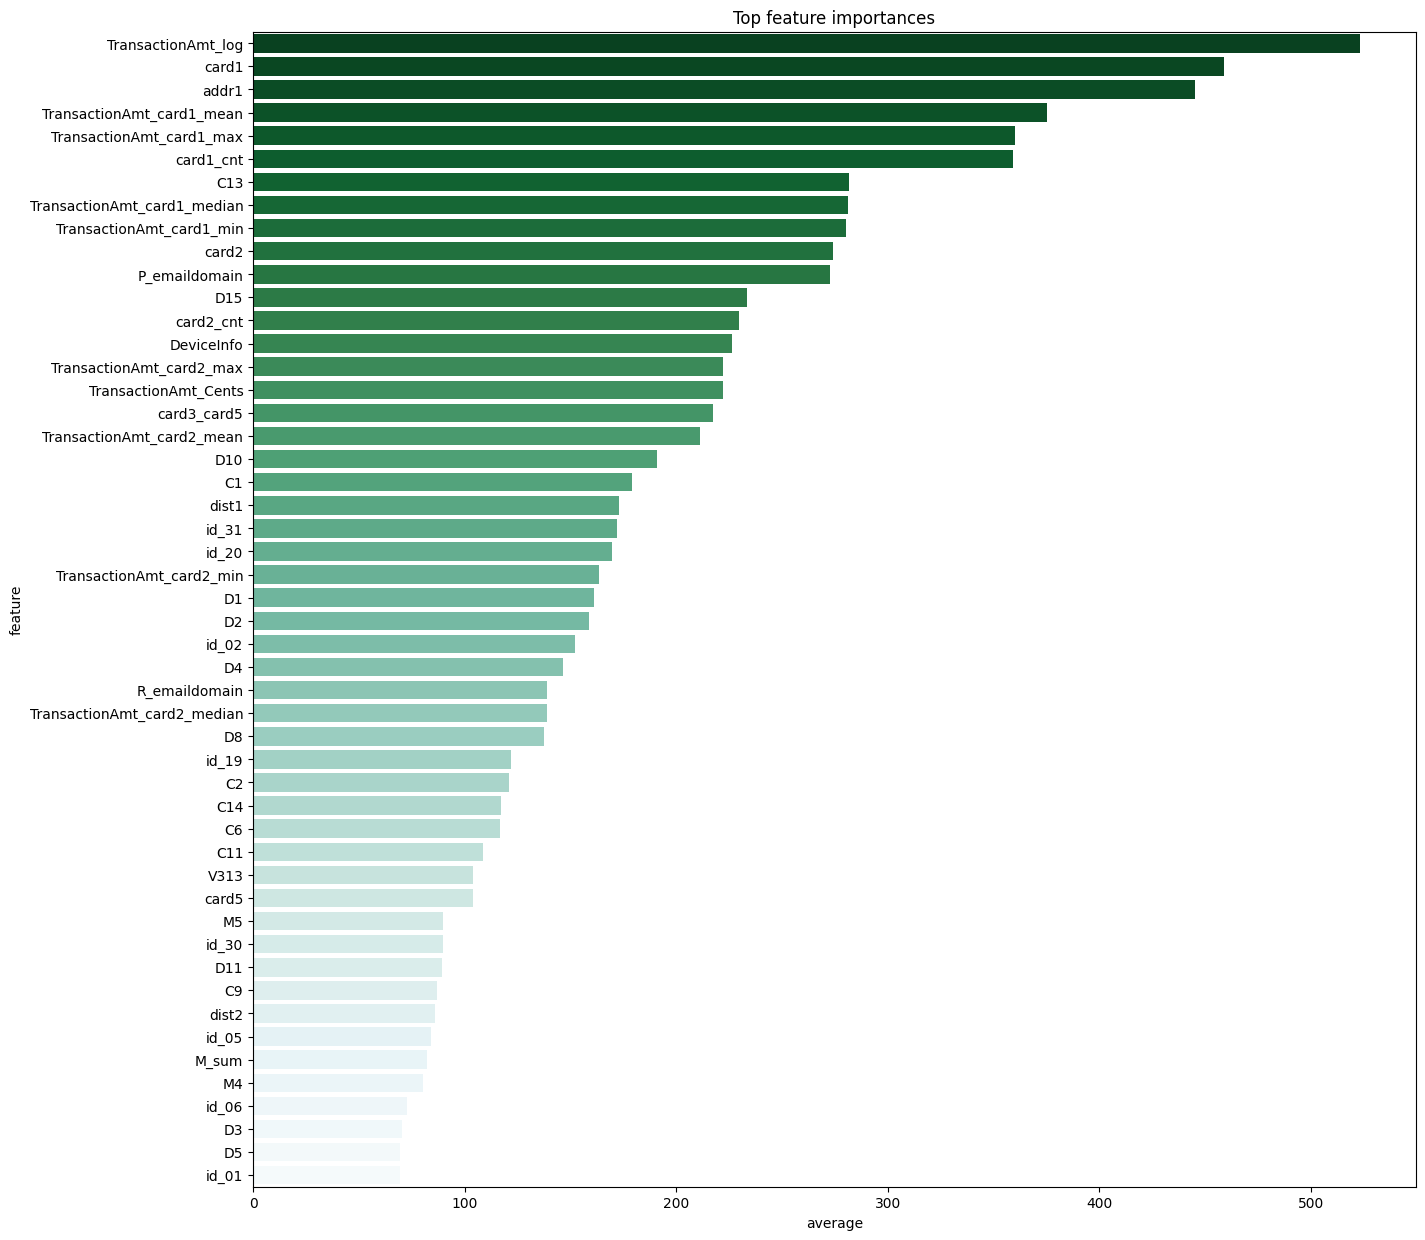

In [ ]:
plt.figure(figsize=(15, 15))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature', palette="BuGn_r")
plt.title('Top feature importances')
plt.show()

Тут без изменений.

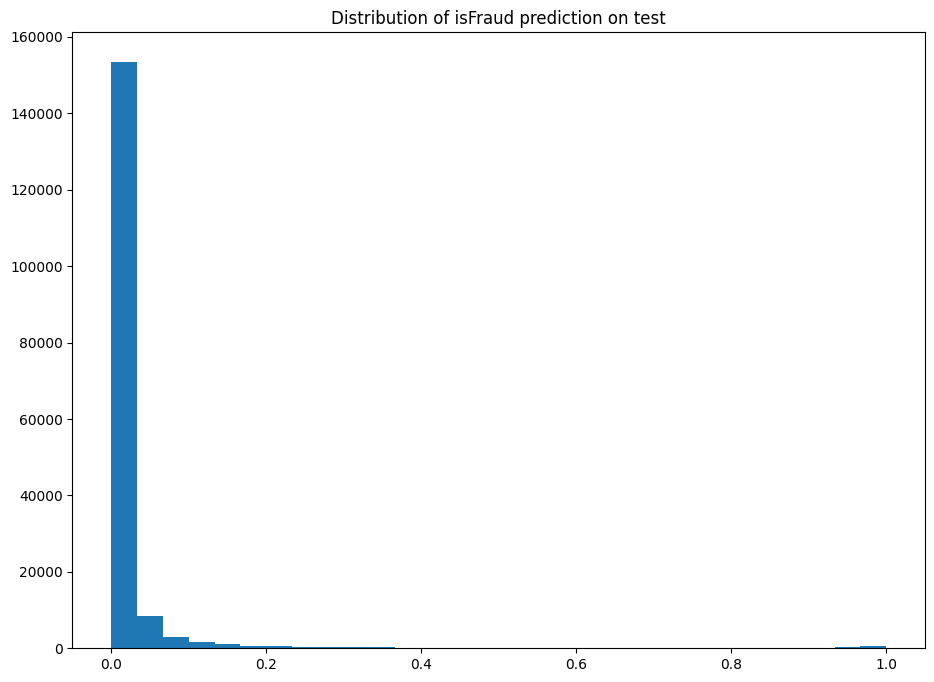

In [ ]:
final_pred = np.average(test_preds, axis=0)
sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': final_pred})
sub.to_csv('submission_baseline_fe_1.csv', index=False)

plt.figure(figsize=(11, 8))
plt.hist(sub['isFraud'], bins=30)
plt.title('Distribution of isFraud prediction on test')
plt.show()

## 3. Model lightGBM 3 standard with label encoder and target encoder

In [ ]:
df_train = df_train_final.copy()
df_test = df_test_final.copy()

cat_cols = df_train.select_dtypes(include=['object']).columns

low_cardinality_cols = [col for col in cat_cols if df_train[col].nunique() < 100]
high_cardinality_cols = [col for col in cat_cols if df_train[col].nunique() >= 100]

for col in low_cardinality_cols:
    le = LabelEncoder()
    le.fit(df_train[col].tolist() + df_test[col].tolist())  # Обучаем на всех данных
    df_train[col] = le.transform(df_train[col])
    df_test[col] = le.transform(df_test[col])
    df_train[col] = df_train[col].astype('category')
    df_test[col] = df_test[col].astype('category')

te = TargetEncoder(cols=high_cardinality_cols, smoothing=5)
df_train[high_cardinality_cols] = te.fit_transform(df_train[high_cardinality_cols], df_train['isFraud'])
df_test[high_cardinality_cols] = te.transform(df_test[high_cardinality_cols])  # Кодируем test по train

# выделяем фолды
month_length = 3600 * 24 * 30
fold0_idx = df_train[df_train['TransactionDT'] < df_train['TransactionDT'].min() + month_length].index
fold1_idx = df_train[(df_train['TransactionDT'].min() + month_length <= df_train['TransactionDT']) & (df_train['TransactionDT'] < df_train['TransactionDT'].min() + 2 * month_length)].index
fold2_idx = df_train[(df_train['TransactionDT'].min() + 2 * month_length <= df_train['TransactionDT']) & (df_train['TransactionDT'] < df_train['TransactionDT'].min() + 3 * month_length)].index
fold3_idx = df_train[df_train['TransactionDT'].min() + 3 * month_length <= df_train['TransactionDT']].index
folds_idx = [fold0_idx, fold1_idx, fold2_idx, fold3_idx]

# выделяем идентификационный и временной признаки
df_train = df_train.drop(['TransactionID', 'TransactionDT'], axis=1)
df_test = df_test.drop(['TransactionID', 'TransactionDT'], axis=1)

In [ ]:
df_train.head()

isFraud ProductCD  card1  card2  card3 card4  card5 card6  addr1  addr2  \
0        0         4  13926     99    150     1    142     1    315     87   
1        0         4   2755    404    150     2    102     1    325     87   
2        0         4   4663    490    150     4    166     2    330     87   
3        0         4  18132    567    150     2    117     2    476     87   
4        0         1   4497    514    150     2    102     1    420     87   

   dist1  dist2 P_emaildomain R_emaildomain  C1  C2  C3  C4  C5  C6  C7  C8  \
0     19     -1            48            49   1   1   0   0   0   1   0   0   
1     -1     -1            16            49   1   1   0   0   0   1   0   0   
2    287     -1            35            49   1   1   0   0   0   1   0   0   
3     -1     -1            54            49   2   5   0   0   0   4   0   0   
4     -1     -1            16            49   1   1   0   0   0   1   0   1   

   C9  C10  C11  C12  C13  C14   D1   D2  D3   D4  D5  D6  D7   D8   D9  D10  \
0   1    0    2    0    1    1   14   -1  13 -123  -1 -84  -1 -1.0 -1.0   13   
1   0    0    1    0    1    1    0   -1  -1    0  -1 -84  -1 -1.0 -1.0    0   
2   1    0    1    0    1    1    0   -1  -1    0  -1 -84  -1 -1.0 -1.0    0   
3   1    0    1    0   25    1  112  112   0   94   0 -84  -1 -1.0 -1.0   84   
4   0    1    1    0    1    1    0   -1  -1 -123  -1 -84  -1 -1.0 -1.0   -1   

   D11  D12  D13  D14  D15 M1 M2 M3 M4 M5 M6 M7 M8 M9  V1  V2  V3  V4  V5  V6  \
0   13  -84   -1 -194    0  1  1  1  2  0  1  2  2  2   1   1   1   1   1   1   
1  -54  -84   -1 -194    0  2  2  2  0  1  1  2  2  2  -1  -1  -1  -1  -1  -1   
2  315  -84   -1 -194  315  1  1  1  0  0  0  0  0  0   1   1   1   1   1   1   
3  -54  -84   -1 -194  111  2  2  2  0  1  0  2  2  2  -1  -1  -1  -1  -1  -1   
4  -54  -84   -1 -194  -84  2  2  2  3  2  2  2  2  2  -1  -1  -1  -1  -1  -1   

   V7  V8  V9  V10  V11  V12  V13  V14  V15  V16  V17  V18  V19  V20  V21  \
0   1   1   1    0    0    1    1    1    0    0    0    0    1    1    0   
1  -1  -1  -1   -1   -1    0    0    1    0    0    0    0    1    1    0   
2   1   1   1    0    0    1    1    1    0    0    0    0    1    1    0   
3  -1  -1  -1   -1   -1    1    1    1    0    0    0    0    1    1    0   
4  -1  -1  -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   

   V22  V23  V24  V25  V26  V27  V28  V29  V30  V31  V32  V33  V34  V35  V36  \
0    0    1    1    1    1    0    0    0    0    0    0    0    0   -1   -1   
1    0    1    1    1    1    0    0    0    0    0    0    0    0    0    0   
2    0    1    1    1    1    0    0    0    0    0    0    0    0    1    1   
3    0    1    1    1    1    0    0    0    0    0    0    0    0    1    1   
4   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   

   V37  V38  V39  V40  V41  V42  V43  V44  V45  V46  V47  V48  V49  V50  V51  \
0   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   
1    1    1    0    0    1    0    0    1    1    1    1    0    0    0    0   
2    1    1    0    0    1    0    0    1    1    1    1    0    0    0    0   
3    1    1    0    0    1    0    0    1    1    1    1    0    0    0    0   
4   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   

   V52  V53  V54  V55  V56  V57  V58  V59  V60  V61  V62  V63  V64  V65  V66  \
0   -1    1    1    1    1    0    0    0    0    1    1    0    0    1    1   
1    0    0    0    1    1    0    0    0    0    1    1    0    0    1    1   
2    0    1    1    1    1    0    0    0    0    1    1    0    0    1    1   
3    0    1    1    1    1    0    0    0    0    1    1    0    0    1    1   
4   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   

   V67  V68  V69  V70  V71  V72  V73  V74  V75  V76  V77  V78  V79  V80  V81  \
0    1    0    0    0    0    0    0    0    1    1    1    1    0    0    0   
1    1    0    0    0    

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417559 entries, 0 to 417558
Columns: 450 entries, isFraud to M_sum
dtypes: category(30), float32(89), float64(6), int16(53), int64(3), int8(230), uint16(22), uint32(1), uint8(16)
memory usage: 341.7 MB


In [ ]:
%%time

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'n_jobs': -1,
    'n_estimators': 2000,
    'seed': 777,
    'early_stopping_rounds': 200,
}

scores = []

feature_importances = pd.DataFrame()
feature_importances['feature'] = df_train.columns.drop('isFraud')

test_preds = []

for i in range(len(folds_idx)):
    X_train = df_train.drop(folds_idx[i], axis=0)
    y_train = X_train['isFraud'].values
    X_val = df_train.iloc[folds_idx[i]]
    y_val = X_val['isFraud'].values
    X_train = X_train.drop('isFraud', axis=1)
    X_val = X_val.drop('isFraud', axis=1)

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    #lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_eval, verbose_eval=100)

    lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_eval,
    callbacks=[
        lgb.early_stopping(stopping_rounds=200),
        lgb.log_evaluation(100)])

    feature_importances['fold_{}'.format(i)] = lgb_model.feature_importance()

    y_pred = lgb_model.predict(X_val)
    score_fold = roc_auc_score(y_val, y_pred)
    scores.append(score_fold)
    y_test_pred = lgb_model.predict(df_test)
    test_preds.append(y_test_pred)

for i in range(len(scores)):
    print('Fold {}, AUC-ROC: {:.5f}'.format(i, scores[i]))
print('CV AUC-ROC: {:.5f}'.format(np.mean(scores)))

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11320, number of negative: 271900
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.270333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34243
[LightGBM] [Info] Number of data points in the train set: 283220, number of used features: 447
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.039969 -> initscore=-3.178863
[LightGBM] [Info] Start training from score -3.178863
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.898375
[200]	valid_0's auc: 0.906755
[300]	valid_0's auc: 0.908693
[400]	valid_0's auc: 0.909795
[500]	valid_0's auc: 0.910148
[600]	valid_0's auc: 0.90977
Early stopping, best iteration is:
[429]	valid_0's auc: 0.910459


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11144, number of negative: 317016
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.690142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37122
[LightGBM] [Info] Number of data points in the train set: 328160, number of used features: 447
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033959 -> initscore=-3.348051
[LightGBM] [Info] Start training from score -3.348051
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.920465
[200]	valid_0's auc: 0.926754
[300]	valid_0's auc: 0.930864
[400]	valid_0's auc: 0.932786
[500]	valid_0's auc: 0.932729
[600]	valid_0's auc: 0.932661
[700]	valid_0's auc: 0.932844
[800]	valid_0's auc: 0.932953
[900]	valid_0's auc: 0.933301
[1000]	valid_0's auc: 0.932856
Early stopping, best iteration is:
[850]	valid_0's auc: 0.93358


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 10997, number of negative: 314373
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.664941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37031
[LightGBM] [Info] Number of data points in the train set: 325370, number of used features: 447
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033798 -> initscore=-3.352958
[LightGBM] [Info] Start training from score -3.352958
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.923704
[200]	valid_0's auc: 0.929543
[300]	valid_0's auc: 0.931139
[400]	valid_0's auc: 0.932488
[500]	valid_0's auc: 0.931978
Early stopping, best iteration is:
[375]	valid_0's auc: 0.932734


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 10702, number of negative: 305225
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.804108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37143
[LightGBM] [Info] Number of data points in the train set: 315927, number of used features: 447
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033875 -> initscore=-3.350619
[LightGBM] [Info] Start training from score -3.350619
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.910104
[200]	valid_0's auc: 0.916462
[300]	valid_0's auc: 0.91796
[400]	valid_0's auc: 0.916943
Early stopping, best iteration is:
[275]	valid_0's auc: 0.918182
Fold 0, AUC-ROC: 0.91046
Fold 1, AUC-ROC: 0.93358
Fold 2, AUC-ROC: 0.93273
Fold 3, AUC-ROC: 0.91818
CV AUC-ROC: 0.92374
CPU times:

CV AUC-ROC: 0.92374  
Kaggle Score: 0.91318

In [71]:
model_3_lgb_le_te_cv = 0.92374
model_3_lgb_le_te_kaggle = 0.91318

In [ ]:
df_train.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417559 entries, 0 to 417558
Columns: 450 entries, isFraud to M_sum
dtypes: category(30), float32(89), float64(6), int16(53), int64(3), int8(230), uint16(22), uint32(1), uint8(16)
memory usage: 341.7 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172981 entries, 0 to 172980
Columns: 449 entries, ProductCD to M_sum
dtypes: category(30), float32(89), float64(7), int16(53), int64(2), int8(229), uint16(22), uint32(1), uint8(16)
memory usage: 141.4 MB


(None, None)

In [ ]:
fold_cols = [col for col in feature_importances.columns if col.startswith('fold_')]
feature_importances['average'] = feature_importances[fold_cols].mean(axis=1)
feature_importances.head()

feature  fold_0  fold_1  fold_2  fold_3  average
0  ProductCD      33      55      32      38    39.50
1      card1     403     969     326     240   484.50
2      card2     283     540     209     159   297.75
3      card3      26      32      20      12    22.50
4      card4      20      25       6       2    13.25

<ipython-input-112-38e95bf7c8d0>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature', palette="BuGn_r")


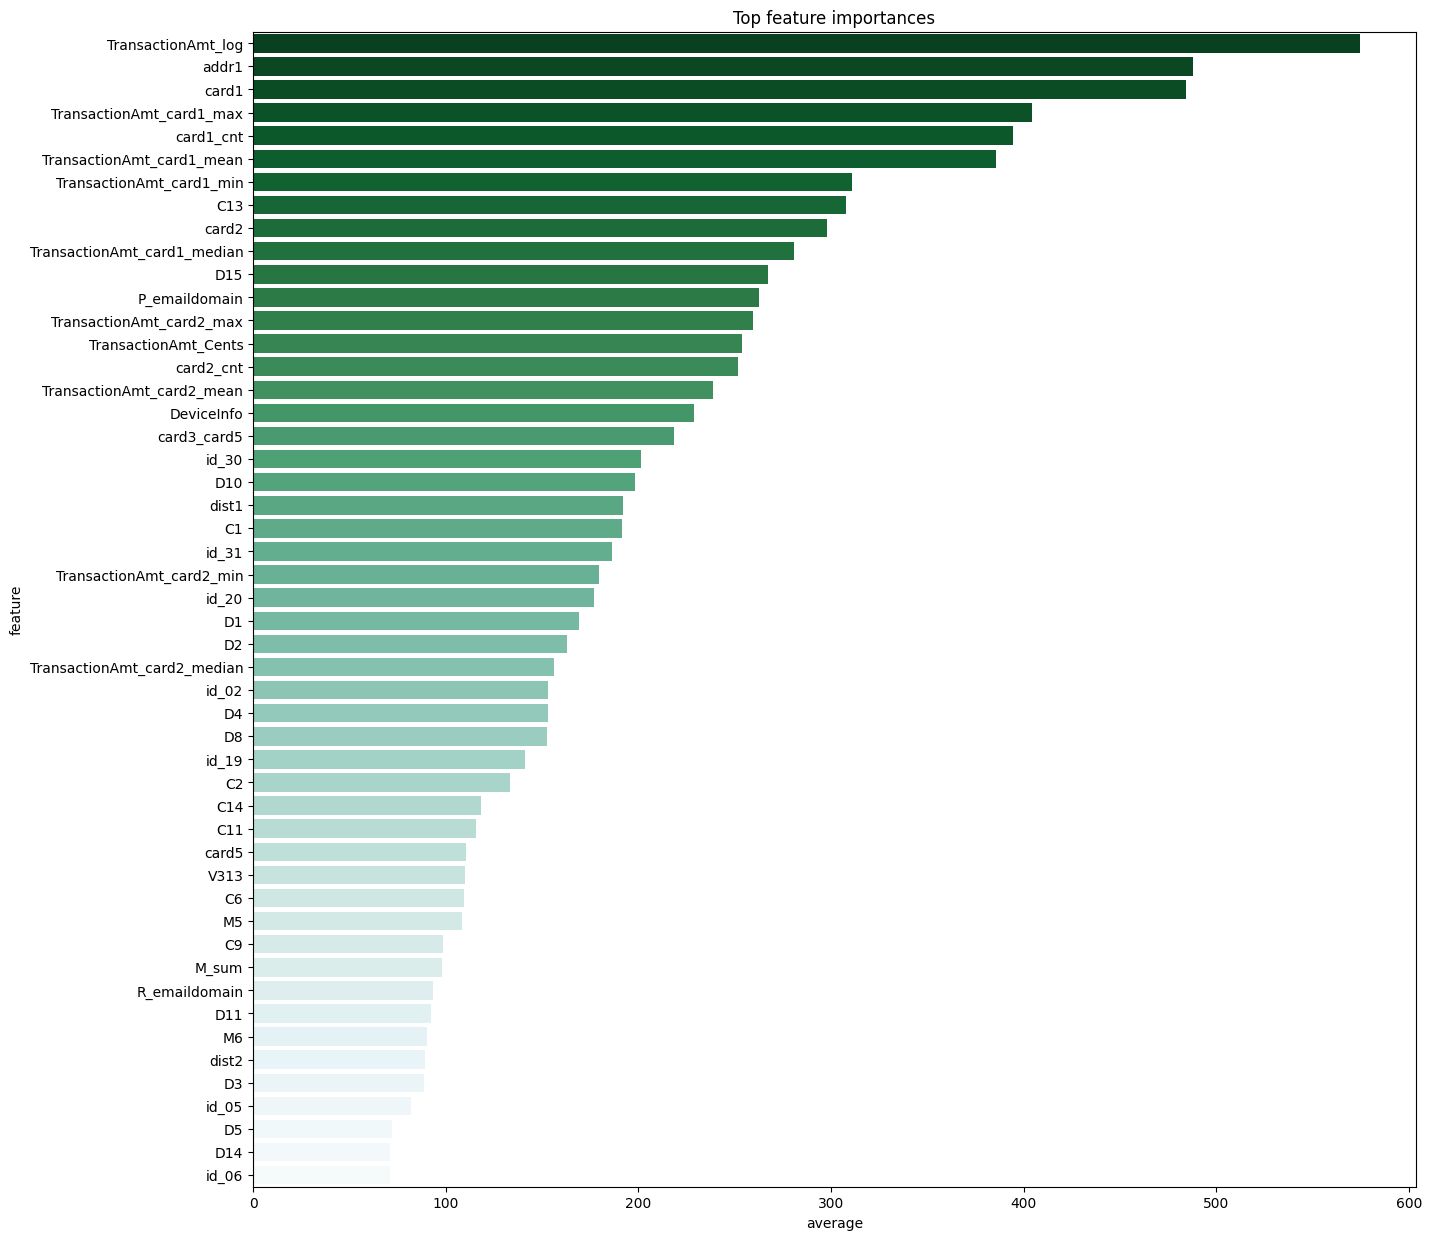

In [ ]:
plt.figure(figsize=(15, 15))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature', palette="BuGn_r")
plt.title('Top feature importances')
plt.show()

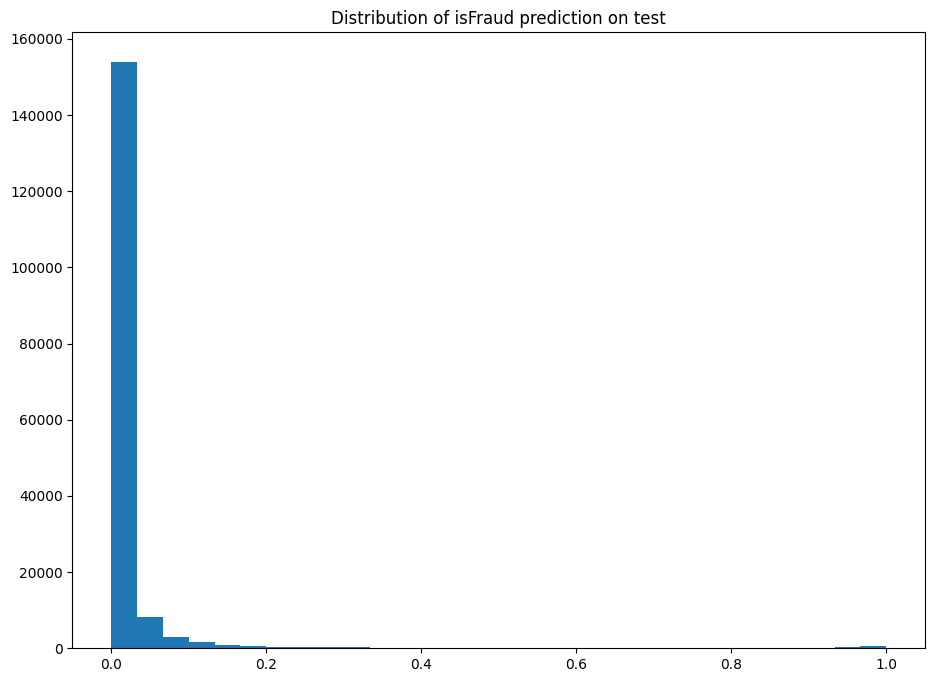

In [ ]:
final_pred = np.average(test_preds, axis=0)
sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': final_pred})
sub.to_csv('submission_baseline_fe_2.csv', index=False)

plt.figure(figsize=(11, 8))
plt.hist(sub['isFraud'], bins=30)
plt.title('Distribution of isFraud prediction on test')
plt.show()

## 4. Model lighgbm 4 with DART

Почему DART? Это аналог дроп-аут-а из нейронок, помогает бороться с переобучением. DART выиграл ни одно соревнование =), попробуем

In [ ]:
df_train = df_train_final.copy()
df_test = df_test_final.copy()

In [ ]:
%%time

params = {
    'objective': 'binary',
    'boosting_type': 'dart',
    'metric': 'auc',
    'n_jobs': -1,
    'n_estimators': 700,
    'learning_rate': 0.03,
    'num_leaves': 32,
    'max_bin': 255,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'drop_rate': 0.05,
    'boost_from_average': False,
    'force_row_wise': True,
    'seed': 777,
}

scores = []
feature_importances = pd.DataFrame()
feature_importances['feature'] = df_train.columns.drop('isFraud')

test_preds = []

for i in range(len(folds_idx)):
    X_train = df_train.drop(folds_idx[i], axis=0)
    y_train = X_train.pop('isFraud')
    X_val = df_train.iloc[folds_idx[i]]
    y_val = X_val.pop('isFraud')

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_eval,
    callbacks=[
        lgb.early_stopping(stopping_rounds=200),
        lgb.log_evaluation(100)])

    feature_importances[f'fold_{i}'] = lgb_model.feature_importance()

    y_pred = lgb_model.predict(X_val)
    scores.append(roc_auc_score(y_val, y_pred))
    test_preds.append(lgb_model.predict(df_test))

for i, score in enumerate(scores):
    print(f'Fold {i}, AUC-ROC: {score:.5f}')
print(f'CV AUC-ROC: {np.mean(scores):.5f}')

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11320, number of negative: 271900
[LightGBM] [Info] Total Bins 34358
[LightGBM] [Info] Number of data points in the train set: 283220, number of used features: 445


/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[100]	valid_0's auc: 0.83762
[200]	valid_0's auc: 0.845664
[300]	valid_0's auc: 0.851085
[400]	valid_0's auc: 0.859123
[500]	valid_0's auc: 0.866592
[600]	valid_0's auc: 0.872511
[700]	valid_0's auc: 0.87718


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11144, number of negative: 317016
[LightGBM] [Info] Total Bins 37181
[LightGBM] [Info] Number of data points in the train set: 328160, number of used features: 445


/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[100]	valid_0's auc: 0.864456
[200]	valid_0's auc: 0.872203
[300]	valid_0's auc: 0.879024
[400]	valid_0's auc: 0.886153
[500]	valid_0's auc: 0.891366
[600]	valid_0's auc: 0.896132
[700]	valid_0's auc: 0.901737


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 10997, number of negative: 314373
[LightGBM] [Info] Total Bins 37104
[LightGBM] [Info] Number of data points in the train set: 325370, number of used features: 445


/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[100]	valid_0's auc: 0.881223
[200]	valid_0's auc: 0.887294
[300]	valid_0's auc: 0.892088
[400]	valid_0's auc: 0.898403
[500]	valid_0's auc: 0.905032
[600]	valid_0's auc: 0.908747
[700]	valid_0's auc: 0.911576


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 10702, number of negative: 305225
[LightGBM] [Info] Total Bins 37224
[LightGBM] [Info] Number of data points in the train set: 315927, number of used features: 445


/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[100]	valid_0's auc: 0.858398
[200]	valid_0's auc: 0.866602
[300]	valid_0's auc: 0.872715
[400]	valid_0's auc: 0.879682
[500]	valid_0's auc: 0.886588
[600]	valid_0's auc: 0.892231
[700]	valid_0's auc: 0.896996
Fold 0, AUC-ROC: 0.87718
Fold 1, AUC-ROC: 0.90174
Fold 2, AUC-ROC: 0.91158
Fold 3, AUC-ROC: 0.89700
CV AUC-ROC: 0.89687
CPU times: user 1h 2min 36s, sys: 14 s, total: 1h 2min 50s
Wall time: 37min 10s


CV AUC-ROC: 0.89687  
Kaggle Score: 0.89098

In [72]:
model_4_lgb_le_te_cv = 0.89687
model_4_lgb_le_te_kaggle = 0.89098

Не густо)

In [ ]:
feature_importances.head()

feature  fold_0  fold_1  fold_2  fold_3
0  TransactionAmt     596     550     598     398
1       ProductCD      49      96      85     148
2           card1     180     153     189     269
3           card2     245     135     155     302
4           card3      70      22      57      85

In [ ]:
fold_cols = [col for col in feature_importances.columns if col.startswith('fold_')]
feature_importances['average'] = feature_importances[fold_cols].mean(axis=1)
feature_importances.head()

feature  fold_0  fold_1  fold_2  fold_3  average
0  TransactionAmt     596     550     598     398   535.50
1       ProductCD      49      96      85     148    94.50
2           card1     180     153     189     269   197.75
3           card2     245     135     155     302   209.25
4           card3      70      22      57      85    58.50

<ipython-input-101-38e95bf7c8d0>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature', palette="BuGn_r")


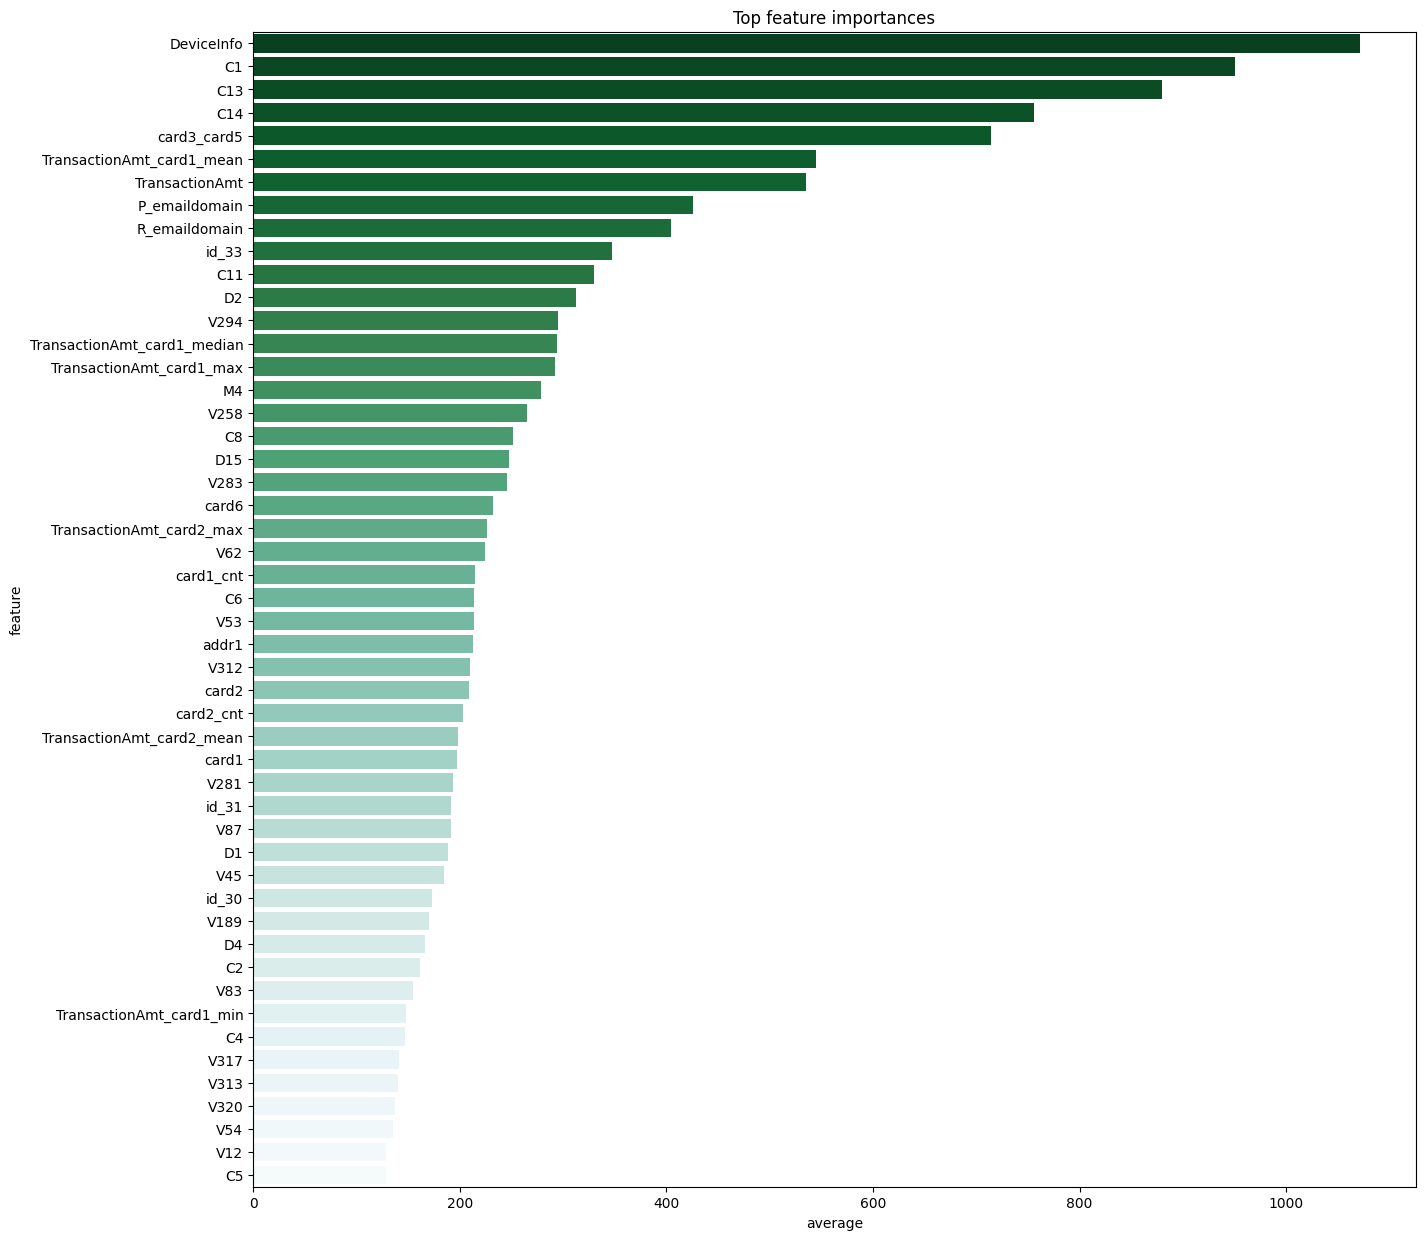

In [ ]:
plt.figure(figsize=(15, 15))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature', palette="BuGn_r")
plt.title('Top feature importances')
plt.show()

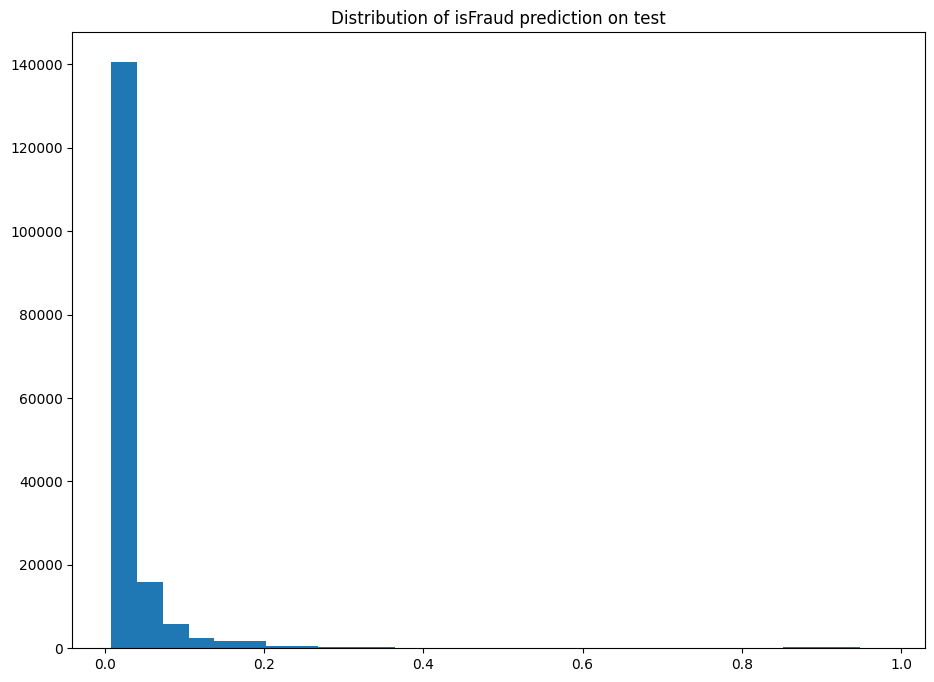

In [ ]:
final_pred_new = np.average(test_preds, axis=0)
sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': final_pred_new})
sub.to_csv('submission_baseline_fe_new_params.csv', index=False)

plt.figure(figsize=(11, 8))
plt.hist(sub['isFraud'], bins=30)
plt.title('Distribution of isFraud prediction on test')
plt.show()

А теперь сделаем правильный encoding.

## Модель 5 lgb и правильный encoding

In [ ]:
df_train = df_train_final.copy()
df_test = df_test_final.copy()

In [ ]:
cat_features = df_train.select_dtypes(include=['object', 'category']).columns

for col in cat_features:
    unique_count = df_train[col].nunique()
    print(f'{col}: {unique_count}')

ProductCD: 5
card4: 5
card6: 5
P_emaildomain: 60
R_emaildomain: 61
M1: 3
M2: 3
M3: 3
M4: 4
M5: 3
M6: 3
M7: 3
M8: 3
M9: 3
id_12: 3
id_15: 4
id_16: 3
id_23: 4
id_27: 3
id_28: 3
id_29: 3
id_30: 72
id_31: 111
id_33: 184
id_34: 5
id_35: 3
id_36: 3
id_37: 3
id_38: 3
DeviceType: 3
DeviceInfo: 1552
P_emaildomain_suffix: 10
R_emaildomain_suffix: 11
card3_card5: 553


In [ ]:
from sklearn.preprocessing import OneHotEncoder

ohe_cols = [col for col in cat_cols_final if df_train[col].nunique() <= 3]
te_cols = [col for col in cat_cols_final if df_train[col].nunique() > 3]

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=np.uint8)

df_train_ohe = df_train.copy()
df_test_ohe = df_train.copy()

ohe_train = ohe.fit_transform(df_train[ohe_cols])
ohe_test = ohe.transform(df_test[ohe_cols])

ohe_feature_names = ohe.get_feature_names_out(ohe_cols)
df_train_ohe = df_train_ohe.drop(columns=ohe_cols)
df_test_ohe = df_test_ohe.drop(columns=ohe_cols)

df_train_ohe[ohe_feature_names] = ohe_train
df_test_ohe[ohe_feature_names] = ohe_test

df_train_enc = df_train_ohe.copy()
df_test_enc = df_test_ohe.copy()

In [ ]:
df_train_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417559 entries, 0 to 417558
Columns: 486 entries, TransactionID to DeviceType_unknown_category
dtypes: float32(90), int16(30), int64(2), int8(202), object(16), uint16(22), uint32(3), uint8(121)
memory usage: 375.5+ MB


In [ ]:
# выделяем фолды
month_length = 3600 * 24 * 30
fold0_idx = df_train_enc[df_train_enc['TransactionDT'] < df_train_enc['TransactionDT'].min() + month_length].index
fold1_idx = df_train_enc[(df_train_enc['TransactionDT'].min() + month_length <= df_train_enc['TransactionDT']) & (df_train_enc['TransactionDT'] < df_train_enc['TransactionDT'].min() + 2 * month_length)].index
fold2_idx = df_train_enc[(df_train_enc['TransactionDT'].min() + 2 * month_length <= df_train_enc['TransactionDT']) & (df_train_enc['TransactionDT'] < df_train_enc['TransactionDT'].min() + 3 * month_length)].index
fold3_idx = df_train_enc[df_train_enc['TransactionDT'].min() + 3 * month_length <= df_train_enc['TransactionDT']].index
folds_idx = [fold0_idx, fold1_idx, fold2_idx, fold3_idx]

Тут оперативка начинает подводить, давайте почистим ее:

In [ ]:
import sys

vars_in_memory = {name: sys.getsizeof(value) for name, value in globals().items()}

df_memory = pd.DataFrame(vars_in_memory.items(), columns=['Variable', 'Size (bytes)'])
df_memory = df_memory.sort_values(by='Size (bytes)', ascending=False)

df_memory['Size (MB)'] = df_memory['Size (bytes)'] / (1024 * 1024)

In [ ]:
df_memory.head(20)

Variable  Size (bytes)    Size (MB)
34   train_transaction    1552337821  1480.424710
47            df_train    1287403384  1227.763542
179  df_train_catboost    1287403384  1227.763542
76             X_train    1051831530  1003.104715
197       df_train_enc     798192594   761.215776
192       df_train_ohe     794852122   758.030054
36    test_transaction     649023609   618.957147
180   df_test_catboost     531632740   507.004490
48             df_test     531632740   507.004490
135       df_train_new     370496416   353.332916
193        df_test_ohe     330712621   315.392133
198        df_test_enc     330712621   315.392133
115         df_numeric     293961700   280.343723
136        df_test_new     154315072   147.166321
35      train_identity     127112436   121.223866
37       test_identity      38178982    36.410315
194          ohe_train      22548314    21.503748
106          df_sample      20448160    19.500885
195           ohe_test       9341102     8.908369
38   sample_submission       2767860     2.639637

In [ ]:
del train_transaction, df_train, X_train, test_transaction,\
 df_test, df_train_new, df_test_new, df_numeric

In [ ]:
import gc
gc.collect()

0

In [ ]:
for col in te_cols:
    df_train_enc[col + '_enc'] = 0

    for i in range(1, len(folds_idx)):
        train_idx = folds_idx[:i]
        val_idx = folds_idx[i]

        train_idx = [idx for sublist in train_idx for idx in sublist]

        te = TargetEncoder(cols=[col])
        df_train_enc.loc[train_idx, col + '_enc'] = te.fit_transform(df_train.loc[train_idx, col], df_train.loc[train_idx, 'isFraud'])[col]
        df_train_enc.loc[val_idx, col + '_enc'] = te.transform(df_train.loc[val_idx, col])[col]

for col in te_cols:
    te = TargetEncoder(cols=[col])
    te.fit(df_train[col], df_train['isFraud'])
    df_test_enc[col + '_enc'] = te.transform(df_test_enc[col])

df_train_enc.drop(columns=['TransactionID', 'TransactionDT'] + te_cols, inplace=True)
df_test_enc.drop(columns=['TransactionID', 'TransactionDT'] + te_cols, inplace=True)

<ipython-input-84-acb94d70136a>:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.0188794 0.0188794 0.0188794 ... 0.0188794 0.0188794 0.0188794]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train_enc.loc[train_idx, col + '_enc'] = te.fit_transform(df_train_catboost.loc[train_idx, col], df_train_catboost.loc[train_idx, 'isFraud'])[col]
<ipython-input-84-acb94d70136a>:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.02382185 0.02909632 0.0244046  ... 0.0244046  0.0244046  0.0244046 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train_enc.loc[train_idx, col + '_enc'] = te.fit_transform(df_train_catboost.loc[train_idx, col], df_train_catboost.loc[train_idx, 'isFraud'])[col]
<ipython-input-84-acb94d70136a>:11: FutureWarning: S

In [ ]:
df_train_enc.shape, df_test_enc.shape

((417559, 484), (172981, 483))

In [ ]:
df_train_enc.head(2)

isFraud  TransactionAmt  card1  card2  card3  card5  addr1  addr2  dist1  \
0        0            68.5  13926     99    150    142    315     87     19   
1        0            29.0   2755    404    150    102    325     87     -1   

   dist2  C1  C2  C3  C4  C5  C6  C7  C8  C9  C10  C11  C12  C13  C14  D1  D2  \
0     -1   1   1   0   0   0   1   0   0   1    0    2    0    1    1  14  -1   
1     -1   1   1   0   0   0   1   0   0   0    0    1    0    1    1   0  -1   

   D3   D4  D5  D6  D7   D8   D9  D10  D11  D12  D13  D14  D15  V1  V2  V3  \
0  13 -123  -1 -84  -1 -1.0 -1.0   13   13  -84   -1 -194    0   1   1   1   
1  -1    0  -1 -84  -1 -1.0 -1.0    0  -54  -84   -1 -194    0  -1  -1  -1   

   V4  V5  V6  V7  V8  V9  V10  V11  V12  V13  V14  V15  V16  V17  V18  V19  \
0   1   1   1   1   1   1    0    0    1    1    1    0    0    0    0    1   
1  -1  -1  -1  -1  -1  -1   -1   -1    0    0    1    0    0    0    0    1   

   V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  V30  V31  V32  V33  V34  \
0    1    0    0    1    1    1    1    0    0    0    0    0    0    0    0   
1    1    0    0    1    1    1    1    0    0    0    0    0    0    0    0   

   V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  V45  V46  V47  V48  V49  \
0   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   
1    0    0    1    1    0    0    1    0    0    1    1    1    1    0    0   

   V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  V60  V61  V62  V63  V64  \
0   -1   -1   -1    1    1    1    1    0    0    0    0    1    1    0    0   
1    0    0    0    0    0    1    1    0    0    0    0    1    1    0    0   

   V65  V66  V67  V68  V69  V70  V71  V72  V73  V74  V75  V76  V77  V78  V79  \
0    1    1    1    0    0    0    0    0    0    0    1    1    1    1    0   
1    1    1    1    0    0    0    0    0    0    0    0    0    1    1    0   

   V80  V81  V82  V83  V84  V85  V86  V87  V88  V89  V90  V91  V92  V93  V94  \
0    0    0    0    0    0    0    1    1    1    0    0    0    0    0    0   
1    0    0    1    1    0    0    1    1    1    0    0    0    0    0    0   

   V95  V96  V97  V98  V99  V100  V101  V102  V103  V104  V105  V106  V107  \
0    0    1    0    0    0     0     0     1     0     0     0     0     1   
1    0    0    0    0    0     0     0     0     0     0     0     0     1   

   V108  V109  V110  V111  V112  V113  V114  V115  V116  V117  V118  V119  \
0     1     1     1     1     1     1     1     1     1     1     1     1   
1     1     1     1     1     1     1     1     1     1     1     1     1   

   V120  V121  V122  V123  V124  V125  V126   V127  V128  V129  V130  V131  \
0     1     1     1     1     1     1   0.0  117.0   0.0   0.0   0.0   0.0   
1     1     1     1     1     1     1   0.0    0.0   0.0   0.0   0.0   0.0   

   V132   V133  V134  V135  V136  V137  V138  V139  V140  V141  V142  V143  \
0   0.0  117.0   0.0   0.0   0.0   0.0    -1    -1    -1    -1    -1    -1   
1   0.0    0.0   0.0   0.0   0.0   0.0    -1    -1    -1    -1    -1    -1   

   V144  V145  V146  V147  V148  V149  V150  V151  V152  V153  V154  V155  \
0    -1    -1    -1    -1    -1    -1     0     0     0    -1    -1    -1   
1    -1    -1    -1    -1    -1    -1     0     0     0    -1    -1    -1   

   V156  V157  V158  V159  V160  V161  V162  V163  V164  V165  V166  V167  \
0    -1    -1    -1  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0    -1   
1    -1    -1    -1  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0    -1   

   V168  V169  V170  V171  V172  V173  V174  V175  V176  V177  V178  V179  \
0    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1   
1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1   

   V180  V181  V182  V183  V184  V185  V186  V187  V188  V189  V190  V191  \
0    -1    -1    -1    -1    -1    -1    -1     0    -1    -1    -1    -1   
1    -1    -1    -1    -1    -1    -1    -1     0    -1 

In [ ]:
df_test_enc.head()

TransactionAmt  card1  card2  card3  card5  addr1  addr2  dist1  dist2  \
0      311.950012   9500    321    150    226    272     87      4     -1   
1       59.000000  15497    490    150    226    299     87    227     -1   
2       59.000000   7919    194    150    166    325     87     -1     -1   
3      160.500000  16075    514    150    102    123     87      4     -1   
4      932.000000  11639    321    150    226    299     87     -1     -1   

    C1   C2  C3  C4   C5   C6  C7  C8   C9  C10  C11  C12  C13  C14   D1   D2  \
0  185  168   0   0  126  110   0   0  144    0  143    0  522  142  131  131   
1    1    1   0   0    0    3   0   0    2    0    2    1    5    1   27   27   
2    1    1   0   0    0    0   0   0    1    0    1    0    0    0    0   -1   
3  144  146   0   0   93  115   0   0  108    0  117    0  455  113    0   -1   
4    1    2   0   0    0    1   0   0    1    0    1    0    2    1    1    1   

   D3   D4   D5  D6  D7   D8   D9  D10  D11  D12  D13  D14  D15  V1  V2  V3  \
0   1  592    1 -75  -1 -1.0 -1.0  482  579  -75   -1   -1  592   1   1   1   
1   1    1    1 -75  -1 -1.0 -1.0   27   21  -75   -1   -1   27   1   1   1   
2  -1  -75   -1 -75  -1 -1.0 -1.0    0    0  -75   -1   -1    0   1   1   1   
3  -1  166  166 -75  -1 -1.0 -1.0  166  166  -75   -1   -1  166   1   1   1   
4   0    0    0 -75  -1 -1.0 -1.0    0  499  -75   -1   -1    0   1   1   1   

   V4  V5  V6  V7  V8  V9  V10  V11  V12  V13  V14  V15  V16  V17  V18  V19  \
0   1   1   1   1   1   1    1    1    0    0    1    0    0    0    0    1   
1   1   1   1   1   2   2    0    0    1    2    1    0    0    0    0    1   
2   0   0   1   1   1   1    0    0    1    1    1    0    0    0    0    0   
3   1   1   1   1   1   1    1    1    1    1    1    0    0    0    0    1   
4   1   1   1   1   1   1    0    0    1    1    1    0    0    0    0    1   

   V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  V30  V31  V32  V33  V34  \
0    1    0    0    1    1    1    1    0    0    1    1    0    0    0    0   
1    1    0    0    1    1    2    2    0    0    0    0    0    0    0    1   
2    0    0    0    1    1    1    1    0    0    0    0    0    0    0    0   
3    1    0    0    1    1    1    1    0    0    1    1    0    0    0    0   
4    1    0    0    1    1    1    1    0    0    0    0    0    0    0    0   

   V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  V45  V46  V47  V48  V49  \
0    0    0    1    1    0    0    1    0    0    1    1    1    1    1    1   
1    1    1    1    1    0    0    1    0    0    1    1    1    1    0    0   
2   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   
3    1    1    1    1    0    0    1    0    0    1    1    1    1    1    1   
4    1    1    2    2    0    0    1    0    0    1    1    1    1    0    0   

   V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  V60  V61  V62  V63  V64  \
0    0    0    0    1    1    1    1    0    0    0    0    1    1    0    0   
1    0    1    1    1    2    1    1    0    0    0    0    1    1    0    0   
2   -1   -1   -1    1    1    1    1    0    0    0    0    0    0    0    0   
3    0    0    0    1    1    1    1    0    0    0    0    1    1    0    0   
4    0    0    0    1    1    2    2    0    0    0    0    1    1    0    0   

   V65  V66  V67  V68  V69  V70  V71  V72  V73  V74  V75  V76  V77  V78  V79  \
0    1    1    1    0    1    1    0    0    0    0    0    0    1    1    0   
1    1    2    2    0    0    0    0    0    0    1    1    2    1    1    0   
2    1    1    1    0    0    0    0    0    0    0    1    1    1    1    0   
3    1    1    1    0    0    0    0    0    0    0    1    1    1    1    0   
4    1    1    1    0    0    0    0    0    0    0    1    1    2    2    0   

   V80  V81  V82  V83  V84  V85  V86  V87  V88  V89  V90  V91  V92  V93  V94  \
0    0    0    1    1    0    0    1    1    1    0    1    1    0    0    0   
1    0    0    1   

In [ ]:
set(df_train_enc.columns) - set(df_test_enc.columns)

{'isFraud'}

In [ ]:
set(df_test_enc.columns) - set(df_train_enc.columns)

set()

In [ ]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

In [ ]:
%%time

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'n_jobs': -1,
    'n_estimators': 2000,
    'seed': 777,
    'early_stopping_rounds': 200,
}

scores = []
feature_importances = pd.DataFrame()
feature_importances['feature'] = df_train_enc.columns.drop('isFraud')
test_preds = []

for i in range(len(folds_idx)):
    X_train = df_train_enc.drop(folds_idx[i], axis=0)
    y_train = X_train.pop('isFraud')
    X_val = df_train_enc.iloc[folds_idx[i]]
    y_val = X_val.pop('isFraud')

    te_cols_in_train = [col for col in te_cols if col in X_train.columns]

    for col in te_cols_in_train:
        te = TargetEncoder(cols=[col])
        X_train[col + '_enc'] = te.fit_transform(X_train[col], y_train)[col]
        X_val[col + '_enc'] = te.transform(X_val[col])[col]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_eval,
        callbacks=[lgb.early_stopping(stopping_rounds=200), lgb.log_evaluation(100)])

    feature_importances[f'fold_{i}'] = lgb_model.feature_importance()

    y_pred = lgb_model.predict(X_val)
    score_fold = roc_auc_score(y_val, y_pred)
    scores.append(score_fold)
    y_test_pred = lgb_model.predict(df_test_enc)
    test_preds.append(y_test_pred)

for i, score in enumerate(scores):
    print(f'Fold {i}, AUC-ROC: {score:.5f}')
print(f'CV AUC-ROC: {np.mean(scores):.5f}')

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11320, number of negative: 271900
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.699759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34405
[LightGBM] [Info] Number of data points in the train set: 283220, number of used features: 479
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.039969 -> initscore=-3.178863
[LightGBM] [Info] Start training from score -3.178863
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.894947
[200]	valid_0's auc: 0.904259
[300]	valid_0's auc: 0.90808
[400]	valid_0's auc: 0.910306
[500]	valid_0's auc: 0.910373
[600]	valid_0's auc: 0.910547
[700]	valid_0's auc: 0.91019
Early stopping, best iteration is:
[566]	valid_0's auc: 0.910664


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11144, number of negative: 317016
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.654866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37238
[LightGBM] [Info] Number of data points in the train set: 328160, number of used features: 479
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033959 -> initscore=-3.348051
[LightGBM] [Info] Start training from score -3.348051
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.918735
[200]	valid_0's auc: 0.926351
[300]	valid_0's auc: 0.932237
[400]	valid_0's auc: 0.934951
[500]	valid_0's auc: 0.935232
[600]	valid_0's auc: 0.936058
[700]	valid_0's auc: 0.936627
[800]	valid_0's auc: 0.93663
[900]	valid_0's auc: 0.936816
[1000]	valid_0's auc: 0.936586
Early stopping

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 10997, number of negative: 314373
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.728476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37147
[LightGBM] [Info] Number of data points in the train set: 325370, number of used features: 479
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033798 -> initscore=-3.352958
[LightGBM] [Info] Start training from score -3.352958
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.928461
[200]	valid_0's auc: 0.933004
[300]	valid_0's auc: 0.934866
[400]	valid_0's auc: 0.935006
[500]	valid_0's auc: 0.935486
[600]	valid_0's auc: 0.935011
[700]	valid_0's auc: 0.934813
Early stopping, best iteration is:
[559]	valid_0's auc: 0.935576


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 10702, number of negative: 305225
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.475543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37288
[LightGBM] [Info] Number of data points in the train set: 315927, number of used features: 479
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033875 -> initscore=-3.350619
[LightGBM] [Info] Start training from score -3.350619
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.899973
[200]	valid_0's auc: 0.904599
[300]	valid_0's auc: 0.906806
[400]	valid_0's auc: 0.904596
[500]	valid_0's auc: 0.902858
Early stopping, best iteration is:
[304]	valid_0's auc: 0.907307
Fold 0, AUC-ROC: 0.91066
Fold 1, AUC-ROC: 0.93748
Fold 2, AUC-ROC: 0.93558
Fold 3, AUC-ROC: 0.90731

WAS ENC: CV AUC-ROC: 0.92450  
NOW ENC: CV AUC-ROC: 0.92276

Тут забыл заслать посылку на kaggle, ну и ладно, метрики не высоки.

In [ ]:
fold_cols = [col for col in feature_importances.columns if col.startswith('fold_')]
feature_importances['average'] = feature_importances[fold_cols].mean(axis=1)
feature_importances.head()

feature  fold_0  fold_1  fold_2  fold_3  average
0  TransactionAmt     744    1122     664     327   714.25
1           card1     573     969     550     326   604.50
2           card2     353     514     312     166   336.25
3           card3      24      30      38      11    25.75
4           card5     148     214     132      56   137.50

<ipython-input-100-38e95bf7c8d0>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature', palette="BuGn_r")


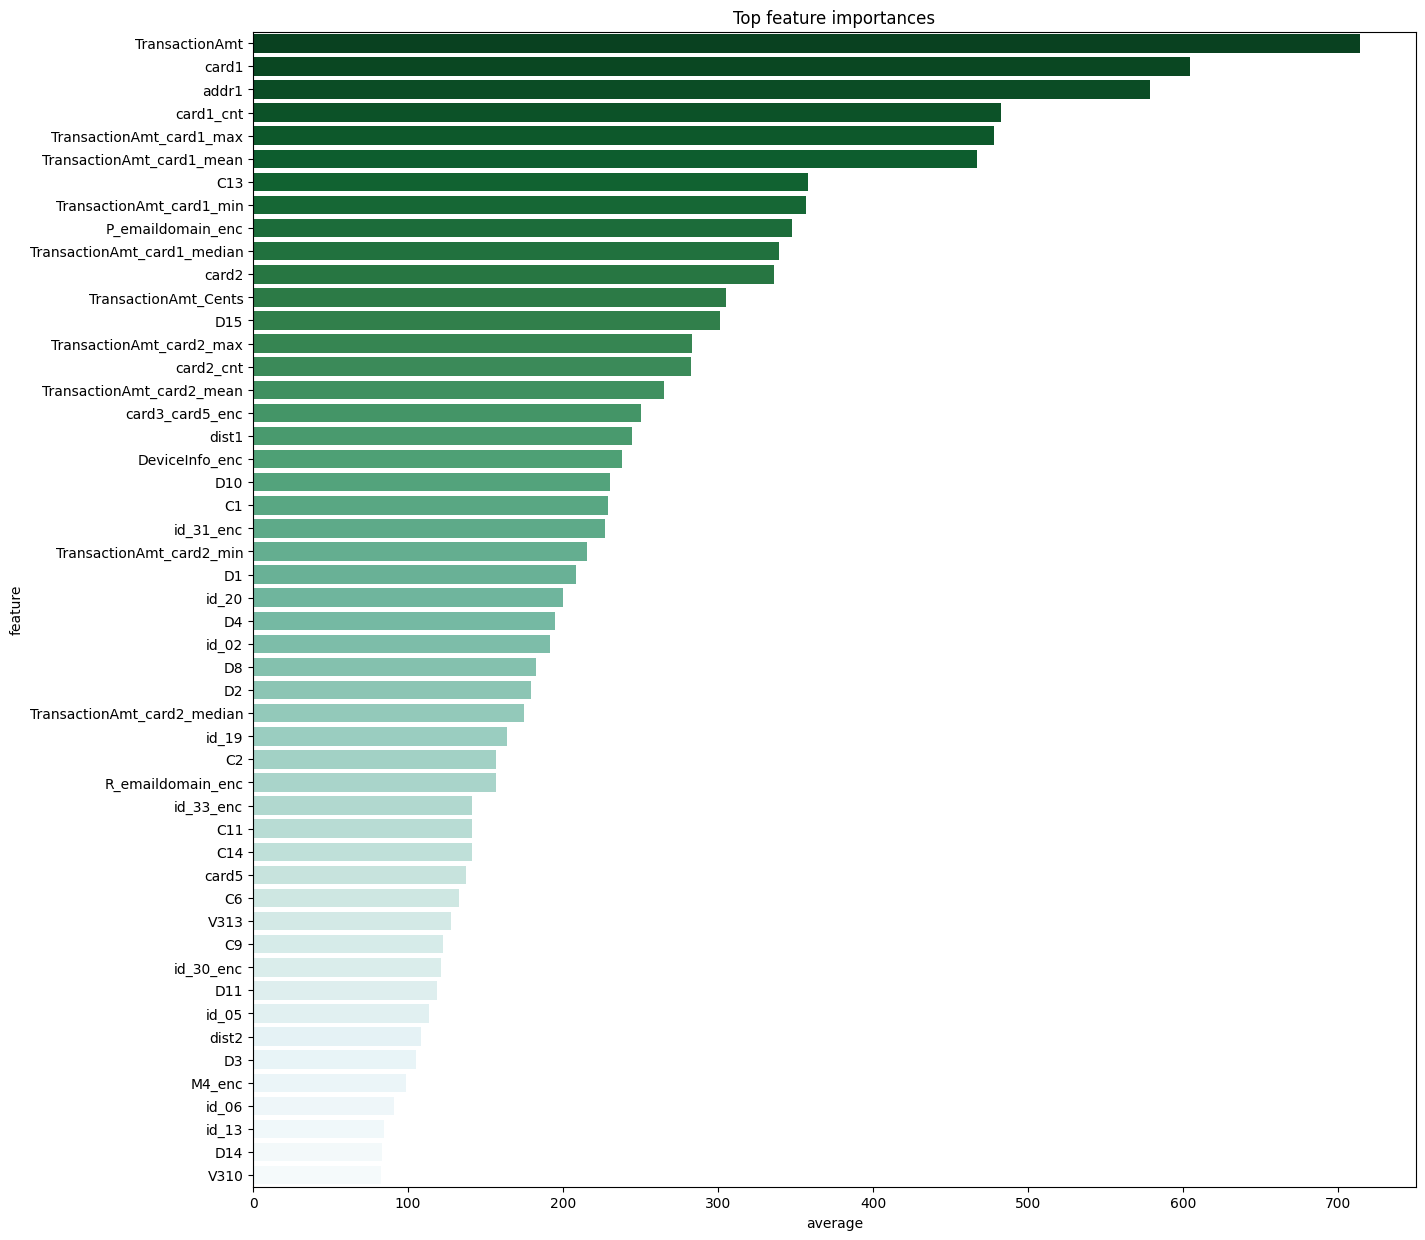

In [ ]:
plt.figure(figsize=(15, 15))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature', palette="BuGn_r")
plt.title('Top feature importances')
plt.show()

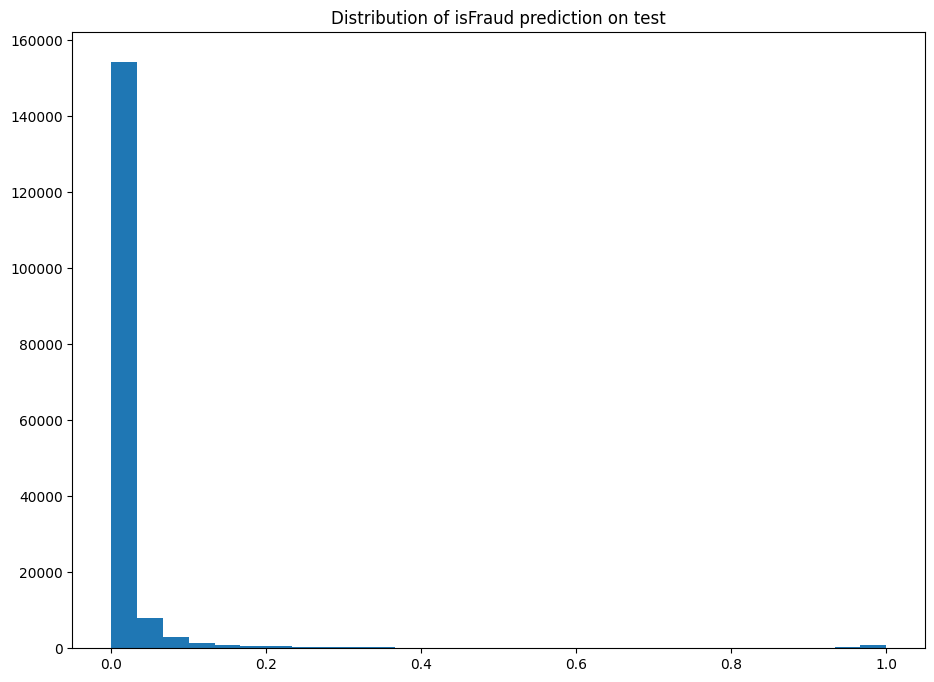

In [ ]:
final_pred_new_enc = np.average(test_preds, axis=0)
sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': final_pred_new_enc})
sub.to_csv('submission_baseline_fe_new_encoding.csv', index=False)
0.92450
plt.figure(figsize=(11, 8))
plt.hist(sub['isFraud'], bins=30)
plt.title('Distribution of isFraud prediction on test')
plt.show()

In [ ]:
df_train_enc.shape

(417559, 484)

In [ ]:
df_train_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417559 entries, 0 to 417558
Columns: 484 entries, isFraud to card3_card5_enc
dtypes: float32(90), float64(16), int16(30), int64(2), int8(202), uint16(22), uint32(1), uint8(121)
memory usage: 372.3 MB


In [ ]:
df_train_enc.head(2)

isFraud  TransactionAmt  card1  card2  card3  card5  addr1  addr2  dist1  \
0        0            68.5  13926     99    150    142    315     87     19   
1        0            29.0   2755    404    150    102    325     87     -1   

   dist2  C1  C2  C3  C4  C5  C6  C7  C8  C9  C10  C11  C12  C13  C14  D1  D2  \
0     -1   1   1   0   0   0   1   0   0   1    0    2    0    1    1  14  -1   
1     -1   1   1   0   0   0   1   0   0   0    0    1    0    1    1   0  -1   

   D3   D4  D5  D6  D7   D8   D9  D10  D11  D12  D13  D14  D15  V1  V2  V3  \
0  13 -123  -1 -84  -1 -1.0 -1.0   13   13  -84   -1 -194    0   1   1   1   
1  -1    0  -1 -84  -1 -1.0 -1.0    0  -54  -84   -1 -194    0  -1  -1  -1   

   V4  V5  V6  V7  V8  V9  V10  V11  V12  V13  V14  V15  V16  V17  V18  V19  \
0   1   1   1   1   1   1    0    0    1    1    1    0    0    0    0    1   
1  -1  -1  -1  -1  -1  -1   -1   -1    0    0    1    0    0    0    0    1   

   V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  V30  V31  V32  V33  V34  \
0    1    0    0    1    1    1    1    0    0    0    0    0    0    0    0   
1    1    0    0    1    1    1    1    0    0    0    0    0    0    0    0   

   V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  V45  V46  V47  V48  V49  \
0   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   
1    0    0    1    1    0    0    1    0    0    1    1    1    1    0    0   

   V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  V60  V61  V62  V63  V64  \
0   -1   -1   -1    1    1    1    1    0    0    0    0    1    1    0    0   
1    0    0    0    0    0    1    1    0    0    0    0    1    1    0    0   

   V65  V66  V67  V68  V69  V70  V71  V72  V73  V74  V75  V76  V77  V78  V79  \
0    1    1    1    0    0    0    0    0    0    0    1    1    1    1    0   
1    1    1    1    0    0    0    0    0    0    0    0    0    1    1    0   

   V80  V81  V82  V83  V84  V85  V86  V87  V88  V89  V90  V91  V92  V93  V94  \
0    0    0    0    0    0    0    1    1    1    0    0    0    0    0    0   
1    0    0    1    1    0    0    1    1    1    0    0    0    0    0    0   

   V95  V96  V97  V98  V99  V100  V101  V102  V103  V104  V105  V106  V107  \
0    0    1    0    0    0     0     0     1     0     0     0     0     1   
1    0    0    0    0    0     0     0     0     0     0     0     0     1   

   V108  V109  V110  V111  V112  V113  V114  V115  V116  V117  V118  V119  \
0     1     1     1     1     1     1     1     1     1     1     1     1   
1     1     1     1     1     1     1     1     1     1     1     1     1   

   V120  V121  V122  V123  V124  V125  V126   V127  V128  V129  V130  V131  \
0     1     1     1     1     1     1   0.0  117.0   0.0   0.0   0.0   0.0   
1     1     1     1     1     1     1   0.0    0.0   0.0   0.0   0.0   0.0   

   V132   V133  V134  V135  V136  V137  V138  V139  V140  V141  V142  V143  \
0   0.0  117.0   0.0   0.0   0.0   0.0    -1    -1    -1    -1    -1    -1   
1   0.0    0.0   0.0   0.0   0.0   0.0    -1    -1    -1    -1    -1    -1   

   V144  V145  V146  V147  V148  V149  V150  V151  V152  V153  V154  V155  \
0    -1    -1    -1    -1    -1    -1     0     0     0    -1    -1    -1   
1    -1    -1    -1    -1    -1    -1     0     0     0    -1    -1    -1   

   V156  V157  V158  V159  V160  V161  V162  V163  V164  V165  V166  V167  \
0    -1    -1    -1  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0    -1   
1    -1    -1    -1  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0    -1   

   V168  V169  V170  V171  V172  V173  V174  V175  V176  V177  V178  V179  \
0    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1   
1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1    -1   

   V180  V181  V182  V183  V184  V185  V186  V187  V188  V189  V190  V191  \
0    -1    -1    -1    -1    -1    -1    -1     0    -1    -1    -1    -1   
1    -1    -1    -1    -1    -1    -1    -1     0    -1 

## Модель 6 с более правильной валидацией на первый взгляд

Такая схема валидации мне больше нравится:  
1. Тренируемся на первом месяце, предсказываем на втором
2. Тренируемся на первом и втором, предсказываем третий
3. Тренируемся на первом, втором и третьем, предсказываем четвертый

In [ ]:
df_train_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417559 entries, 0 to 417558
Columns: 486 entries, TransactionID to DeviceType_unknown_category
dtypes: float32(90), int16(30), int64(2), int8(202), object(16), uint16(22), uint32(3), uint8(121)
memory usage: 375.5+ MB


In [ ]:
month_length = 3600 * 24 * 30

fold0_idx = df_train_ohe[df_train_ohe['TransactionDT'] < df_train_ohe['TransactionDT'].min() + month_length].index
fold1_idx = df_train_ohe[(df_train_ohe['TransactionDT'] >= df_train_ohe['TransactionDT'].min() + month_length) &
                     (df_train_ohe['TransactionDT'] < df_train_ohe['TransactionDT'].min() + 2 * month_length)].index
fold2_idx = df_train_ohe[(df_train_ohe['TransactionDT'] >= df_train_ohe['TransactionDT'].min() + 2 * month_length) &
                     (df_train_ohe['TransactionDT'] < df_train_ohe['TransactionDT'].min() + 3 * month_length)].index
fold3_idx = df_train_ohe[df_train_ohe['TransactionDT'] >= df_train_ohe['TransactionDT'].min() + 3 * month_length].index

folds_idx = [fold0_idx, fold1_idx, fold2_idx, fold3_idx]

df_train_enc = df_train_ohe.drop(columns=['TransactionID', 'TransactionDT'])
df_test_enc = df_test_ohe.drop(columns=['TransactionID', 'TransactionDT'])

In [ ]:
df_train_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417559 entries, 0 to 417558
Columns: 484 entries, isFraud to DeviceType_unknown_category
dtypes: float32(90), int16(30), int64(2), int8(202), object(16), uint16(22), uint32(1), uint8(121)
memory usage: 372.3+ MB


In [ ]:
df_test_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172981 entries, 0 to 172980
Columns: 483 entries, TransactionAmt to DeviceType_unknown_category
dtypes: float32(88), float64(1), int16(40), int64(1), int8(229), object(16), uint16(24), uint32(1), uint8(83)
memory usage: 155.1+ MB


In [ ]:
ohe_cols

['M1',
 'M2',
 'M3',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'id_12',
 'id_16',
 'id_27',
 'id_28',
 'id_29',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType']

In [ ]:
te_cols

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M4',
 'id_15',
 'id_23',
 'id_30',
 'id_31',
 'id_33',
 'id_34',
 'DeviceInfo',
 'P_emaildomain_suffix',
 'R_emaildomain_suffix',
 'card3_card5']

In [ ]:
len(te_cols)

16

In [ ]:
df_train = df_train_catboost.copy()
df_test = df_test_catboost.copy()

In [ ]:
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'n_jobs': -1,
    'n_estimators': 2000,
    'seed': 777,
    'early_stopping_rounds': 200,
}

ohe_cols = [col for col in cat_cols_final if df_train[col].nunique() <= 3]
te_cols = [col for col in cat_cols_final if df_train[col].nunique() > 3]

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=np.uint8)
df_train_ohe = pd.DataFrame(ohe.fit_transform(df_train[ohe_cols]), columns=ohe.get_feature_names_out(ohe_cols), index=df_train.index)
df_test_ohe = pd.DataFrame(ohe.transform(df_test[ohe_cols]), columns=ohe.get_feature_names_out(ohe_cols), index=df_test.index)

df_train_enc = pd.concat([df_train.drop(columns=ohe_cols), df_train_ohe], axis=1)
df_test_enc = pd.concat([df_test.drop(columns=ohe_cols), df_test_ohe], axis=1)

month_length = 3600 * 24 * 30
fold0_idx = df_train_enc[df_train_enc['TransactionDT'] < df_train_enc['TransactionDT'].min() + month_length].index
fold1_idx = df_train_enc[(df_train_enc['TransactionDT'] >= df_train_enc['TransactionDT'].min() + month_length) &
                         (df_train_enc['TransactionDT'] < df_train_enc['TransactionDT'].min() + 2 * month_length)].index
fold2_idx = df_train_enc[(df_train_enc['TransactionDT'] >= df_train_enc['TransactionDT'].min() + 2 * month_length) &
                         (df_train_enc['TransactionDT'] < df_train_enc['TransactionDT'].min() + 3 * month_length)].index
fold3_idx = df_train_enc[df_train_enc['TransactionDT'] >= df_train_enc['TransactionDT'].min() + 3 * month_length].index

folds_idx = [fold0_idx, fold1_idx, fold2_idx, fold3_idx]

df_train_enc = df_train_enc.drop(columns=['TransactionID', 'TransactionDT'])
df_test_enc = df_test_enc.drop(columns=['TransactionID', 'TransactionDT'])

for col in te_cols:
    df_train_enc[col + '_enc'] = 0

    for fold in range(1, len(folds_idx)):
        train_part_idx = [idx for sublist in folds_idx[:fold] for idx in sublist]
        val_part_idx = folds_idx[fold]

        te = TargetEncoder(cols=[col])
        df_train_enc.loc[train_part_idx, col + '_enc'] = te.fit_transform(df_train_enc.loc[train_part_idx, col], df_train_enc.loc[train_part_idx, 'isFraud'])[col]
        df_train_enc.loc[val_part_idx, col + '_enc'] = te.transform(df_train_enc.loc[val_part_idx, col])[col]

    te = TargetEncoder(cols=[col])
    df_test_enc[col + '_enc'] = te.fit_transform(df_train_enc[col], df_train_enc['isFraud'])[col]

df_train_enc.drop(columns=te_cols, inplace=True)
df_test_enc.drop(columns=te_cols, inplace=True)

<ipython-input-125-d87cef2e242b>:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.0188794 0.0188794 0.0188794 ... 0.0188794 0.0188794 0.0188794]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train_enc.loc[train_part_idx, col + '_enc'] = te.fit_transform(df_train_enc.loc[train_part_idx, col], df_train_enc.loc[train_part_idx, 'isFraud'])[col]
<ipython-input-125-d87cef2e242b>:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.02382185 0.02909632 0.0244046  ... 0.0244046  0.0244046  0.0244046 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train_enc.loc[train_part_idx, col + '_enc'] = te.fit_transform(df_train_enc.loc[train_part_idx, col], df_train_enc.loc[train_part_idx, 'isFraud'])[col]
<ipython-input-125-d87cef2e242b>:49: Fut

In [ ]:
%%time

scores = []
feature_importances = pd.DataFrame()
feature_importances['feature'] = df_train_enc.columns.drop('isFraud')
test_preds = []

for i in range(1, len(folds_idx)):
    train_idx = [idx for sublist in folds_idx[:i] for idx in sublist]
    val_idx = folds_idx[i]

    X_train = df_train_enc.loc[train_idx].drop(columns=['isFraud'])
    y_train = df_train_enc.loc[train_idx]['isFraud']
    X_val = df_train_enc.loc[val_idx].drop(columns=['isFraud'])
    y_val = df_train_enc.loc[val_idx]['isFraud']

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_eval,
                           callbacks=[lgb.early_stopping(stopping_rounds=200),
                                      lgb.log_evaluation(100)])

    feature_importances[f'fold_{i}'] = lgb_model.feature_importance()

    y_pred = lgb_model.predict(X_val)
    score_fold = roc_auc_score(y_val, y_pred)
    scores.append(score_fold)

    y_test_pred = lgb_model.predict(df_test_enc)
    test_preds.append(y_test_pred)

for i, score in enumerate(scores):
    print(f'Fold {i}, AUC-ROC: {score:.5f}')
print(f'CV AUC-ROC: {np.mean(scores):.5f}')

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.315908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36454
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 479
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.903057
[200]	valid_0's auc: 0.906551
[300]	valid_0's auc: 0.904283
[400]	valid_0's auc: 0.900767
Early stopping, best iteration is:
[223]	valid_0's auc: 0.906832


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 6978, number of negative: 216760
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.847729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37179
[LightGBM] [Info] Number of data points in the train set: 223738, number of used features: 479
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.031188 -> initscore=-3.436028
[LightGBM] [Info] Start training from score -3.436028
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.913235
[200]	valid_0's auc: 0.916859
[300]	valid_0's auc: 0.913615
Early stopping, best iteration is:
[192]	valid_0's auc: 0.917055


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 10702, number of negative: 305225
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.589036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37288
[LightGBM] [Info] Number of data points in the train set: 315927, number of used features: 479
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033875 -> initscore=-3.350619
[LightGBM] [Info] Start training from score -3.350619
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.899973
[200]	valid_0's auc: 0.904599
[300]	valid_0's auc: 0.906806
[400]	valid_0's auc: 0.904596
[500]	valid_0's auc: 0.902858
Early stopping, best iteration is:
[304]	valid_0's auc: 0.907307
Fold 0, AUC-ROC: 0.90683
Fold 1, AUC-ROC: 0.91706
Fold 2, AUC-ROC: 0.90731
CV AUC-ROC: 0.91040
CPU 

CV AUC-ROC: 0.91040  
Kaggle Score: 0.82168

In [73]:
model_6_lgb_time_valid_cv = 0.91040
model_6_lgb_time_valid_kaggle = 0.82168

Ух как просел скорр на каггле. Забываем эту схему)

## Модель 7 с тайм валидацией и правильным кодированием по фолдам.

In [ ]:
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'n_jobs': -1,
    'n_estimators': 2000,
    'seed': 777,
    'early_stopping_rounds': 200,
}

ohe_cols = [col for col in cat_cols_final if df_train[col].nunique() <= 3]
te_cols = [col for col in cat_cols_final if df_train[col].nunique() > 3]

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=np.uint8)
df_train_ohe = pd.DataFrame(ohe.fit_transform(df_train[ohe_cols]), columns=ohe.get_feature_names_out(ohe_cols), index=df_train.index)
df_test_ohe = pd.DataFrame(ohe.transform(df_test[ohe_cols]), columns=ohe.get_feature_names_out(ohe_cols), index=df_test.index)

df_train_enc = pd.concat([df_train.drop(columns=ohe_cols), df_train_ohe], axis=1)
df_test_enc = pd.concat([df_test.drop(columns=ohe_cols), df_test_ohe], axis=1)

month_length = 3600 * 24 * 30
fold0_idx = df_train_enc[df_train_enc['TransactionDT'] < df_train_enc['TransactionDT'].min() + month_length].index
fold1_idx = df_train_enc[(df_train_enc['TransactionDT'] >= df_train_enc['TransactionDT'].min() + month_length) &
                         (df_train_enc['TransactionDT'] < df_train_enc['TransactionDT'].min() + 2 * month_length)].index
fold2_idx = df_train_enc[(df_train_enc['TransactionDT'] >= df_train_enc['TransactionDT'].min() + 2 * month_length) &
                         (df_train_enc['TransactionDT'] < df_train_enc['TransactionDT'].min() + 3 * month_length)].index
fold3_idx = df_train_enc[df_train_enc['TransactionDT'] >= df_train_enc['TransactionDT'].min() + 3 * month_length].index

folds_idx = [fold0_idx, fold1_idx, fold2_idx, fold3_idx]

df_train_enc.drop(columns=['TransactionID', 'TransactionDT'], inplace=True)
df_test_enc.drop(columns=['TransactionID', 'TransactionDT'], inplace=True)

In [ ]:
print(df_train_enc.dtypes.value_counts())

int8       202
uint8      121
float32     90
int16       30
uint16      22
object      16
int64        2
uint32       1
Name: count, dtype: int64


In [ ]:
print(df_train_enc.select_dtypes(include=['object']).columns)

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M4',
       'id_15', 'id_23', 'id_30', 'id_31', 'id_33', 'id_34', 'DeviceInfo',
       'P_emaildomain_suffix', 'R_emaildomain_suffix', 'card3_card5'],
      dtype='object')


In [ ]:
%%time

scores = []
feature_importances = pd.DataFrame()
feature_importances['feature'] = df_train_enc.columns.drop('isFraud')
test_preds = []

for i in range(1, len(folds_idx)):
    train_idx = [idx for sublist in folds_idx[:i] for idx in sublist]
    val_idx = folds_idx[i]

    X_train = df_train_enc.loc[train_idx].drop(columns=['isFraud']).copy()
    y_train = df_train_enc.loc[train_idx]['isFraud']
    X_val = df_train_enc.loc[val_idx].drop(columns=['isFraud']).copy()
    y_val = df_train_enc.loc[val_idx]['isFraud']

    for col in te_cols:
        te = TargetEncoder(cols=[col])
        X_train[col + '_enc'] = te.fit_transform(X_train[col], y_train)[col]
        X_val[col + '_enc'] = te.transform(X_val[col])[col]

    X_train.drop(columns=te_cols, inplace=True, errors='ignore')
    X_val.drop(columns=te_cols, inplace=True, errors='ignore')

    if len(X_train.select_dtypes(include=['object']).columns) > 0 or len(X_val.select_dtypes(include=['object']).columns) > 0:
        print(f'В фолде {i} остались object-фичи!')

    # Создание датасетов для LightGBM
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    # Обучение модели
    lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_eval,
                          callbacks=[lgb.early_stopping(stopping_rounds=200),
                                     lgb.log_evaluation(100)])

    feature_importances[f'fold_{i}'] = lgb_model.feature_importance()

    y_pred = lgb_model.predict(X_val)
    score_fold = roc_auc_score(y_val, y_pred)
    scores.append(score_fold)

    X_test_aligned = df_test_enc.reindex(columns=X_train.columns, fill_value=0)
    y_test_pred = lgb_model.predict(X_test_aligned)
    test_preds.append(y_test_pred)

for col in te_cols:
    te = TargetEncoder(cols=[col])
    df_test_enc[col + '_enc'] = te.fit_transform(df_train_enc[col], df_train_enc['isFraud'])[col]

df_test_enc.drop(columns=te_cols, inplace=True, errors='ignore')

for i, score in enumerate(scores):
    print(f'Fold {i}, AUC-ROC: {score:.5f}')
print(f'CV AUC-ROC: {np.mean(scores):.5f}')

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 3401, number of negative: 130938
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.300101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36304
[LightGBM] [Info] Number of data points in the train set: 134339, number of used features: 479
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025317 -> initscore=-3.650654
[LightGBM] [Info] Start training from score -3.650654
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.881397
[200]	valid_0's auc: 0.878733
[300]	valid_0's auc: 0.876512
Early stopping, best iteration is:
[114]	valid_0's auc: 0.883005


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 6978, number of negative: 216760
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.983375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37118
[LightGBM] [Info] Number of data points in the train set: 223738, number of used features: 479
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.031188 -> initscore=-3.436028
[LightGBM] [Info] Start training from score -3.436028
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.905811
[200]	valid_0's auc: 0.90329
Early stopping, best iteration is:
[97]	valid_0's auc: 0.906628


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 10702, number of negative: 305225
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.111817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37288
[LightGBM] [Info] Number of data points in the train set: 315927, number of used features: 479
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033875 -> initscore=-3.350619
[LightGBM] [Info] Start training from score -3.350619
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.899973
[200]	valid_0's auc: 0.904599
[300]	valid_0's auc: 0.906806
[400]	valid_0's auc: 0.904596
[500]	valid_0's auc: 0.902858
Early stopping, best iteration is:
[304]	valid_0's auc: 0.907307
Fold 0, AUC-ROC: 0.88301
Fold 1, AUC-ROC: 0.90663
Fold 2, AUC-ROC: 0.90731
CV AUC-ROC: 0.89898
CPU 

CV AUC-ROC: 0.89898  
На kaggle не засылал посылку из-за низкого скорра

In [ ]:
fold_cols = [col for col in feature_importances.columns if col.startswith('fold_')]
feature_importances['average'] = feature_importances[fold_cols].mean(axis=1)
feature_importances.head()

feature  fold_1  fold_2  fold_3     average
0  TransactionAmt     143      89     327  186.333333
1       ProductCD     115      80     326  173.666667
2           card1      63      46     166   91.666667
3           card2       3       6      11    6.666667
4           card3      13      15      56   28.000000

<ipython-input-148-38e95bf7c8d0>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature', palette="BuGn_r")


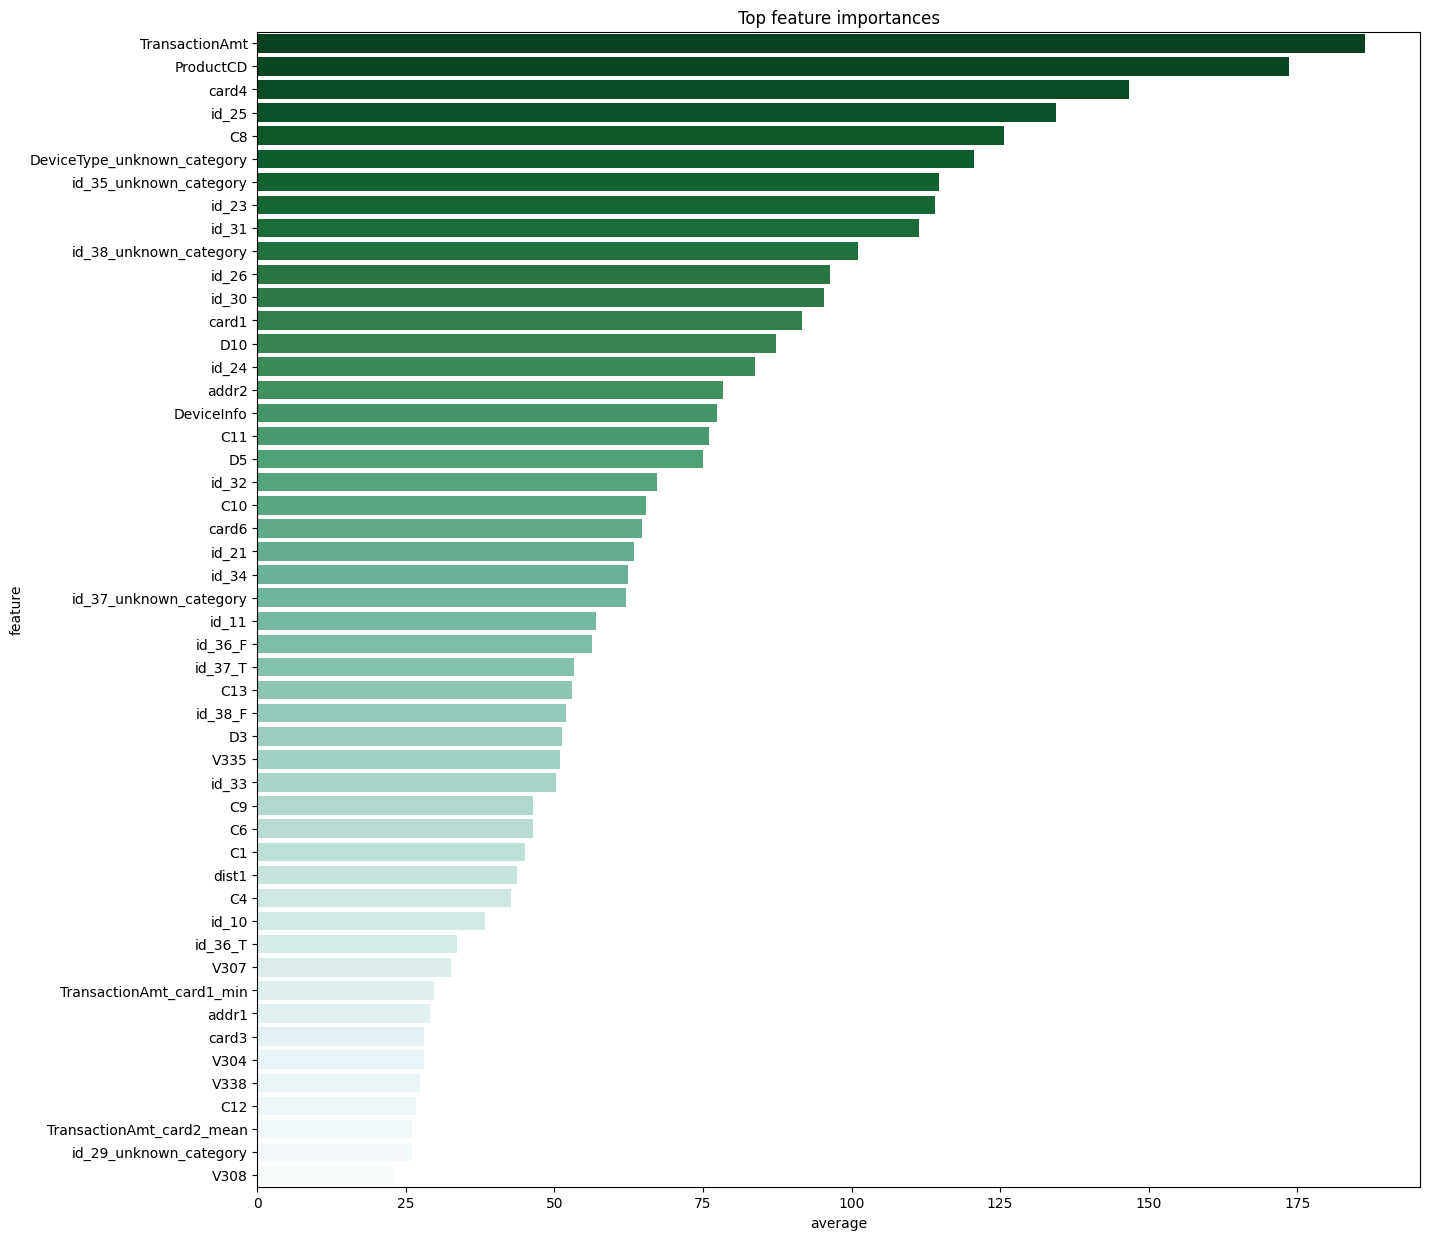

In [ ]:
plt.figure(figsize=(15, 15))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature', palette="BuGn_r")
plt.title('Top feature importances')
plt.show()

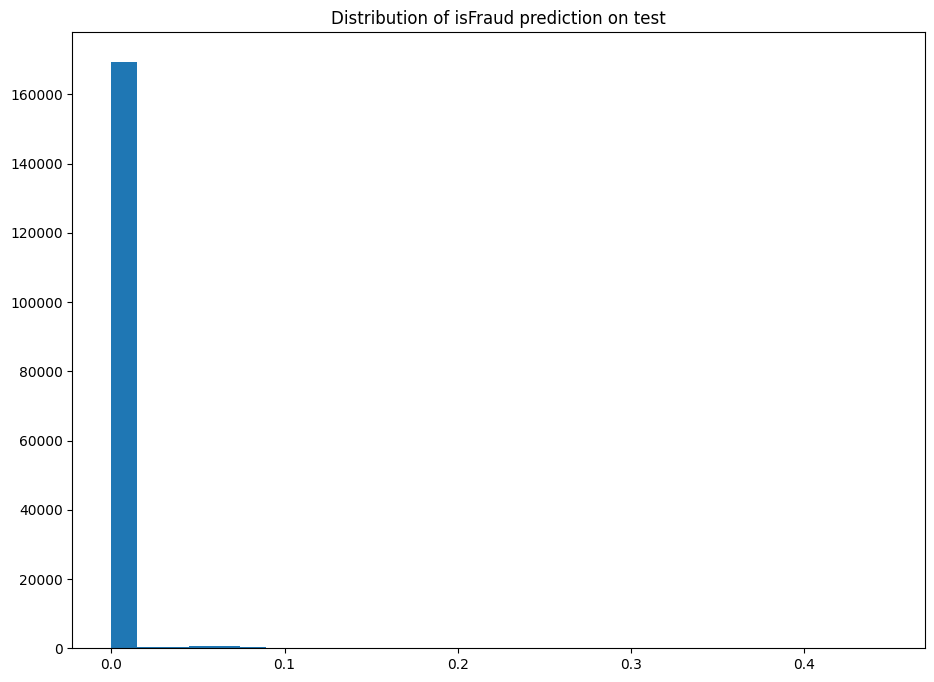

In [ ]:
final_pred_time = np.average(test_preds, axis=0)
sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': final_pred_time})
sub.to_csv('submission_baseline_fe_time.csv', index=False)

plt.figure(figsize=(11, 8))
plt.hist(sub['isFraud'], bins=30)
plt.title('Distribution of isFraud prediction on test')
plt.show()

In [ ]:
df_train_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417559 entries, 0 to 417558
Columns: 484 entries, isFraud to DeviceType_unknown_category
dtypes: float32(90), int16(30), int64(2), int8(202), object(16), uint16(22), uint32(1), uint8(121)
memory usage: 372.3+ MB


## Модель 8 lgb с timeseries split (cv=10)

In [ ]:
%%time
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=10)

scores = []
feature_importances = pd.DataFrame()
feature_importances['feature'] = df_train_enc.columns.drop('isFraud')
test_preds = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(df_train_enc)):
    X_train = df_train_enc.iloc[train_idx].drop(columns=['isFraud']).copy()
    y_train = df_train_enc.iloc[train_idx]['isFraud']
    X_val = df_train_enc.iloc[val_idx].drop(columns=['isFraud']).copy()
    y_val = df_train_enc.iloc[val_idx]['isFraud']

    for col in te_cols:
        te = TargetEncoder(cols=[col])
        X_train[col + '_enc'] = te.fit_transform(X_train[col], y_train)[col]
        X_val[col + '_enc'] = te.transform(X_val[col])[col]

    X_train.drop(columns=te_cols, inplace=True, errors='ignore')
    X_val.drop(columns=te_cols, inplace=True, errors='ignore')

    X_test_aligned = df_test_enc.reindex(columns=X_train.columns, fill_value=0)

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_eval,
                          callbacks=[lgb.early_stopping(stopping_rounds=200),
                                     lgb.log_evaluation(100)])

    feature_importances[f'fold_{fold}'] = lgb_model.feature_importance()

    y_pred = lgb_model.predict(X_val)
    score_fold = roc_auc_score(y_val, y_pred)
    scores.append(score_fold)

    y_test_pred = lgb_model.predict(X_test_aligned)
    test_preds.append(y_test_pred)

    print(f'Fold {fold} done. AUC-ROC: {score_fold:.5f}')

print(f'CV AUC-ROC: {np.mean(scores):.5f}')

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 1089, number of negative: 36880
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.192690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 29951
[LightGBM] [Info] Number of data points in the train set: 37969, number of used features: 479
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028681 -> initscore=-3.522410
[LightGBM] [Info] Start training from score -3.522410
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.894587
[200]	valid_0's auc: 0.886624
Early stopping, best iteration is:
[48]	valid_0's auc: 0.90148
Fold 0 done. AUC-ROC: 0.90148


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2036, number of negative: 73892
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.230925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34310
[LightGBM] [Info] Number of data points in the train set: 75928, number of used features: 479
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.026815 -> initscore=-3.591617
[LightGBM] [Info] Start training from score -3.591617
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.898427
[200]	valid_0's auc: 0.89989
[300]	valid_0's auc: 0.900116
Early stopping, best iteration is:
[146]	valid_0's auc: 0.901734
Fold 1 done. AUC-ROC: 0.90173


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2740, number of negative: 111147
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.256359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35838
[LightGBM] [Info] Number of data points in the train set: 113887, number of used features: 479
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.024059 -> initscore=-3.702896
[LightGBM] [Info] Start training from score -3.702896
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.894091
[200]	valid_0's auc: 0.894537
[300]	valid_0's auc: 0.893373
Early stopping, best iteration is:
[135]	valid_0's auc: 0.896944
Fold 2 done. AUC-ROC: 0.89694


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 4029, number of negative: 147817
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.398147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36536
[LightGBM] [Info] Number of data points in the train set: 151846, number of used features: 479
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.026533 -> initscore=-3.602457
[LightGBM] [Info] Start training from score -3.602457
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.897704
[200]	valid_0's auc: 0.899969
[300]	valid_0's auc: 0.898523
Early stopping, best iteration is:
[181]	valid_0's auc: 0.90285
Fold 3 done. AUC-ROC: 0.90285


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 5518, number of negative: 184287
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.773167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36847
[LightGBM] [Info] Number of data points in the train set: 189805, number of used features: 479
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.029072 -> initscore=-3.508479
[LightGBM] [Info] Start training from score -3.508479
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.914169
[200]	valid_0's auc: 0.916361
[300]	valid_0's auc: 0.917201
[400]	valid_0's auc: 0.915459
Early stopping, best iteration is:
[277]	valid_0's auc: 0.918425
Fold 4 done. AUC-ROC: 0.91843


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 7147, number of negative: 220617
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.720562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37124
[LightGBM] [Info] Number of data points in the train set: 227764, number of used features: 479
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.031379 -> initscore=-3.429735
[LightGBM] [Info] Start training from score -3.429735
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.91882
[200]	valid_0's auc: 0.920942
[300]	valid_0's auc: 0.924098
[400]	valid_0's auc: 0.923648
[500]	valid_0's auc: 0.924236
Early stopping, best iteration is:
[344]	valid_0's auc: 0.924677
Fold 5 done. AUC-ROC: 0.92468


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 8840, number of negative: 256883
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.170717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37324
[LightGBM] [Info] Number of data points in the train set: 265723, number of used features: 479
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033268 -> initscore=-3.369334
[LightGBM] [Info] Start training from score -3.369334
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.910468
[200]	valid_0's auc: 0.916216
[300]	valid_0's auc: 0.917026
[400]	valid_0's auc: 0.914875
Early stopping, best iteration is:
[282]	valid_0's auc: 0.917784
Fold 6 done. AUC-ROC: 0.91778


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 10281, number of negative: 293401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.630507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37268
[LightGBM] [Info] Number of data points in the train set: 303682, number of used features: 479
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033854 -> initscore=-3.351243
[LightGBM] [Info] Start training from score -3.351243
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.88156
[200]	valid_0's auc: 0.888926
[300]	valid_0's auc: 0.89011
[400]	valid_0's auc: 0.892319
[500]	valid_0's auc: 0.892889
[600]	valid_0's auc: 0.89323
Early stopping, best iteration is:
[445]	valid_0's auc: 0.893972
Fold 7 done. AUC-ROC: 0.89397


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 11543, number of negative: 330098
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.036683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37156
[LightGBM] [Info] Number of data points in the train set: 341641, number of used features: 479
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033787 -> initscore=-3.353310
[LightGBM] [Info] Start training from score -3.353310
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.911795
[200]	valid_0's auc: 0.917429
[300]	valid_0's auc: 0.919711
[400]	valid_0's auc: 0.919011
[500]	valid_0's auc: 0.919284
[600]	valid_0's auc: 0.917857
Early stopping, best iteration is:
[431]	valid_0's auc: 0.920027
Fold 8 done. AUC-ROC: 0.92003


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 12960, number of negative: 366640
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.210567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37091
[LightGBM] [Info] Number of data points in the train set: 379600, number of used features: 479
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034141 -> initscore=-3.342513
[LightGBM] [Info] Start training from score -3.342513
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.921383
[200]	valid_0's auc: 0.926444
[300]	valid_0's auc: 0.927261
[400]	valid_0's auc: 0.929028
[500]	valid_0's auc: 0.92821
[600]	valid_0's auc: 0.92715
Early stopping, best iteration is:
[457]	valid_0's auc: 0.92967
Fold 9 done. AUC-ROC: 0.92967
CV AUC-ROC: 0.91076
CPU times: user 28min 

CV AUC-ROC: 0.91076, низковато, засылать не стал

In [ ]:
for i, score in enumerate(scores):
    print(f'Fold {i}, AUC-ROC: {score:.4f}')

Fold 0, AUC-ROC: 0.9015
Fold 1, AUC-ROC: 0.9017
Fold 2, AUC-ROC: 0.8969
Fold 3, AUC-ROC: 0.9028
Fold 4, AUC-ROC: 0.9184
Fold 5, AUC-ROC: 0.9247
Fold 6, AUC-ROC: 0.9178
Fold 7, AUC-ROC: 0.8940
Fold 8, AUC-ROC: 0.9200
Fold 9, AUC-ROC: 0.9297


Очень интересно, что скорр потихоньку растет с ростом трейна!

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417559 entries, 0 to 417558
Columns: 450 entries, TransactionID to TransactionAmt_card2_max
dtypes: float32(90), int16(30), int64(2), int8(202), object(34), uint16(22), uint32(3), uint8(67)
memory usage: 411.4+ MB


In [ ]:
df_train_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417559 entries, 0 to 417558
Data columns (total 54 columns):
 #   Column                       Non-Null Count   Dtype
---  ------                       --------------   -----
 0   M1_F                         417559 non-null  uint8
 1   M1_T                         417559 non-null  uint8
 2   M1_unknown_category          417559 non-null  uint8
 3   M2_F                         417559 non-null  uint8
 4   M2_T                         417559 non-null  uint8
 5   M2_unknown_category          417559 non-null  uint8
 6   M3_F                         417559 non-null  uint8
 7   M3_T                         417559 non-null  uint8
 8   M3_unknown_category          417559 non-null  uint8
 9   M5_F                         417559 non-null  uint8
 10  M5_T                         417559 non-null  uint8
 11  M5_unknown_category          417559 non-null  uint8
 12  M6_F                         417559 non-null  uint8
 13  M6_T                         

In [ ]:
df_train_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417559 entries, 0 to 417558
Columns: 484 entries, isFraud to DeviceType_unknown_category
dtypes: float32(90), int16(30), int64(2), int8(202), object(16), uint16(22), uint32(1), uint8(121)
memory usage: 372.3+ MB


In [ ]:
params

{'objective': 'binary',
 'boosting_type': 'gbdt',
 'metric': 'auc',
 'n_jobs': -1,
 'n_estimators': 2000,
 'seed': 777,
 'early_stopping_rounds': 200}

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417559 entries, 0 to 417558
Columns: 450 entries, TransactionID to TransactionAmt_card2_max
dtypes: float32(90), int16(30), int64(2), int8(202), object(34), uint16(22), uint32(3), uint8(67)
memory usage: 411.4+ MB


## Модель 9 на всем трейне.

In [ ]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import OneHotEncoder

params = {'objective': 'binary',
          'boosting_type': 'gbdt',
          'metric': 'auc',
          'n_jobs': -1,
          'seed': 777}

%%time

ohe_cols = [col for col in cat_cols_final if df_train[col].nunique() <= 3]
te_cols = [col for col in cat_cols_final if df_train[col].nunique() > 3]

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=np.uint8)
df_train_ohe = pd.DataFrame(ohe.fit_transform(df_train[ohe_cols]),
                            columns=ohe.get_feature_names_out(ohe_cols),
                            index=df_train.index)
df_test_ohe = pd.DataFrame(ohe.transform(df_test[ohe_cols]),
                           columns=ohe.get_feature_names_out(ohe_cols),
                           index=df_test.index)

df_train_enc = pd.concat([df_train.drop(columns=ohe_cols), df_train_ohe], axis=1)
df_test_enc = pd.concat([df_test.drop(columns=ohe_cols), df_test_ohe], axis=1)

for col in te_cols:
    te = TargetEncoder(cols=[col])
    df_train_enc[col + '_enc'] = te.fit_transform(df_train[col], df_train['isFraud'])[col]
    df_test_enc[col + '_enc'] = te.transform(df_test[col])[col]

df_train_enc.drop(columns=te_cols, inplace=True, errors='ignore')
df_test_enc.drop(columns=te_cols, inplace=True, errors='ignore')

X_full = df_train_enc.drop(columns=['isFraud'])
y_full = df_train_enc['isFraud']
lgb_full = lgb.Dataset(X_full, y_full)

final_model = lgb.train(params, lgb_full, num_boost_round=500)

final_preds = final_model.predict(df_test_enc)

submission = pd.DataFrame({
    'TransactionID': sample_submission['TransactionID'],
    'isFraud': final_preds
})
submission.to_csv('final_submission.csv', index=False)
print("Финальное обучение завершено. Предсказания сохранены в 'final_submission.csv'.")

[LightGBM] [Info] Number of positive: 14721, number of negative: 402838
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.041051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37573
[LightGBM] [Info] Number of data points in the train set: 417559, number of used features: 481
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035255 -> initscore=-3.309259
[LightGBM] [Info] Start training from score -3.309259
Финальное обучение завершено. Предсказания сохранены в 'final_submission.csv'.
CPU times: user 4min 16s, sys: 2.36 s, total: 4min 18s
Wall time: 2min 40s


CV score нет, так как без валидации хотел проверить  
Kaggle Score: 0.90161, плохо

In [74]:
model_9_lgb_full_train_kaggle = 0.90161

In [ ]:
%%time
params = {'objective': 'binary',
          'boosting_type': 'gbdt',
          'metric': 'auc',
          'n_jobs': -1,
          'seed': 777,
          'n_estimators': 500,
          'is_unbalance': True}

ohe_cols = [col for col in cat_cols_final if df_train[col].nunique() <= 3]
te_cols = [col for col in cat_cols_final if df_train[col].nunique() > 3]

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=np.uint8)
df_train_ohe = pd.DataFrame(ohe.fit_transform(df_train[ohe_cols]),
                            columns=ohe.get_feature_names_out(ohe_cols),
                            index=df_train.index)
df_test_ohe = pd.DataFrame(ohe.transform(df_test[ohe_cols]),
                           columns=ohe.get_feature_names_out(ohe_cols),
                           index=df_test.index)

df_train_enc = pd.concat([df_train.drop(columns=ohe_cols), df_train_ohe], axis=1)
df_test_enc = pd.concat([df_test.drop(columns=ohe_cols), df_test_ohe], axis=1)

for col in te_cols:
    te = TargetEncoder(cols=[col])
    df_train_enc[col + '_enc'] = te.fit_transform(df_train[col], df_train['isFraud'])[col]
    df_test_enc[col + '_enc'] = te.transform(df_test[col])[col]

df_train_enc.drop(columns=te_cols, inplace=True, errors='ignore')
df_test_enc.drop(columns=te_cols, inplace=True, errors='ignore')

X_full = df_train_enc.drop(columns=['isFraud'])
y_full = df_train_enc['isFraud']
lgb_full = lgb.Dataset(X_full, y_full)

final_model = lgb.train(params, lgb_full, num_boost_round=500)

final_preds = final_model.predict(df_test_enc)

submission = pd.DataFrame({
    'TransactionID': sample_submission['TransactionID'],
    'isFraud': final_preds
})
submission.to_csv('final_submission.csv', index=False)

print("Финальное обучение завершено. Предсказания сохранены в 'final_submission.csv'.")

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 14721, number of negative: 402838
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.077577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37573
[LightGBM] [Info] Number of data points in the train set: 417559, number of used features: 481
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.035255 -> initscore=-3.309259
[LightGBM] [Info] Start training from score -3.309259
Финальное обучение завершено. Предсказания сохранены в 'final_submission_1.csv'.
CPU times: user 4min 20s, sys: 2.97 s, total: 4min 23s
Wall time: 2min 44s


CV score нет, так как без валидации хотел проверить  
Kaggle Score: 0.89146, еще хуже

In [ ]:
df_train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417559 entries, 0 to 417558
Columns: 418 entries, TransactionID to TransactionAmt_card2_max
dtypes: float32(89), int16(30), int64(2), int8(202), object(4), uint16(22), uint32(3), uint8(66)
memory usage: 313.8+ MB


In [ ]:
df_test_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172981 entries, 0 to 172980
Columns: 417 entries, TransactionID to TransactionAmt_card2_max
dtypes: float32(87), float64(1), int16(40), int64(1), int8(229), object(4), uint16(24), uint32(3), uint8(28)
memory usage: 130.8+ MB


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417559 entries, 0 to 417558
Columns: 418 entries, TransactionID to TransactionAmt_card2_max
dtypes: float32(89), int16(30), int64(2), int8(202), object(4), uint16(22), uint32(3), uint8(66)
memory usage: 313.8+ MB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172981 entries, 0 to 172980
Columns: 417 entries, TransactionID to TransactionAmt_card2_max
dtypes: float32(87), float64(1), int16(40), int64(1), int8(229), object(4), uint16(24), uint32(3), uint8(28)
memory usage: 130.8+ MB


In [ ]:
df_train_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417559 entries, 0 to 417558
Columns: 418 entries, TransactionID to TransactionAmt_card2_max
dtypes: float32(89), int16(30), int64(2), int8(202), object(4), uint16(22), uint32(3), uint8(66)
memory usage: 313.8+ MB


In [ ]:
df_train_enc.head()

TransactionID  isFraud  TransactionDT ProductCD  card1  card2  card3  \
0        2987000        0          86400         W  13926     99    150   
1        2987001        0          86401         W   2755    404    150   
2        2987002        0          86469         W   4663    490    150   
3        2987003        0          86499         W  18132    567    150   
4        2987004        0          86506         H   4497    514    150   

        card4  card5   card6  addr1  addr2  dist1  dist2  C1  C2  C3  C4  C5  \
0    discover    142  credit    315     87     19     -1   1   1   0   0   0   
1  mastercard    102  credit    325     87     -1     -1   1   1   0   0   0   
2        visa    166   debit    330     87    287     -1   1   1   0   0   0   
3  mastercard    117   debit    476     87     -1     -1   2   5   0   0   0   
4  mastercard    102  credit    420     87     -1     -1   1   1   0   0   0   

   C6  C7  C8  C9  C10  C11  C12  C13  C14   D1   D2  D3   D4  D5  D6  D7  \
0   1   0   0   1    0    2    0    1    1   14   -1  13 -123  -1 -84  -1   
1   1   0   0   0    0    1    0    1    1    0   -1  -1    0  -1 -84  -1   
2   1   0   0   1    0    1    0    1    1    0   -1  -1    0  -1 -84  -1   
3   4   0   0   1    0    1    0   25    1  112  112   0   94   0 -84  -1   
4   1   0   1   0    1    1    0    1    1    0   -1  -1 -123  -1 -84  -1   

    D8   D9  D10  D11  D12  D13  D14  D15  V1  V2  V3  V4  V5  V6  V7  V8  V9  \
0 -1.0 -1.0   13   13  -84   -1 -194    0   1   1   1   1   1   1   1   1   1   
1 -1.0 -1.0    0  -54  -84   -1 -194    0  -1  -1  -1  -1  -1  -1  -1  -1  -1   
2 -1.0 -1.0    0  315  -84   -1 -194  315   1   1   1   1   1   1   1   1   1   
3 -1.0 -1.0   84  -54  -84   -1 -194  111  -1  -1  -1  -1  -1  -1  -1  -1  -1   
4 -1.0 -1.0   -1  -54  -84   -1 -194  -84  -1  -1  -1  -1  -1  -1  -1  -1  -1   

   V10  V11  V12  V13  V14  V15  V16  V17  V18  V19  V20  V21  V22  V23  V24  \
0    0    0    1    1    1    0    0    0    0    1    1    0    0    1    1   
1   -1   -1    0    0    1    0    0    0    0    1    1    0    0    1    1   
2    0    0    1    1    1    0    0    0    0    1    1    0    0    1    1   
3   -1   -1    1    1    1    0    0    0    0    1    1    0    0    1    1   
4   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   

   V25  V26  V27  V28  V29  V30  V31  V32  V33  V34  V35  V36  V37  V38  V39  \
0    1    1    0    0    0    0    0    0    0    0   -1   -1   -1   -1   -1   
1    1    1    0    0    0    0    0    0    0    0    0    0    1    1    0   
2    1    1    0    0    0    0    0    0    0    0    1    1    1    1    0   
3    1    1    0    0    0    0    0    0    0    0    1    1    1    1    0   
4   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   

   V40  V41  V42  V43  V44  V45  V46  V47  V48  V49  V50  V51  V52  V53  V54  \
0   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1    1    1   
1    0    1    0    0    1    1    1    1    0    0    0    0    0    0    0   
2    0    1    0    0    1    1    1    1    0    0    0    0    0    1    1   
3    0    1    0    0    1    1    1    1    0    0    0    0    0    1    1   
4   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   

   V55  V56  V57  V58  V59  V60  V61  V62  V63  V64  V65  V66  V67  V68  V69  \
0    1    1    0    0    0    0    1    1    0    0    1    1    1    0    0   
1    1    1    0    0    0    0    1    1    0    0    1    1    1    0    0   
2    1    1    0    0    0    0    1    1    0    0    1    1    1    0    0   
3    1    1    0    0    0    0    1    1    0    0    1    1    1    0    0   
4   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   

   V70  V71  V72  V73  V74  V75  V76  V77  V78  V79  V80  V81  V82  V83  V84  \
0    0    0    0    0    0    1    1    1    1    0    0    0    0    0    0   
1    0    0    0    0    0    0    0 

In [ ]:
df_test_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172981 entries, 0 to 172980
Columns: 417 entries, TransactionID to TransactionAmt_card2_max
dtypes: float32(87), float64(1), int16(40), int64(1), int8(229), object(4), uint16(24), uint32(3), uint8(28)
memory usage: 130.8+ MB


In [ ]:
te_cols

['ProductCD', 'card4', 'card6', 'card3_card5']

## Модель 10 lgb time series (cv=3)

In [ ]:
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'n_jobs': -1,
    'n_estimators': 2000,
    'seed': 777,
    'early_stopping_rounds': 200,
}

df_train = df_train_final.copy()
df_test = df_test_final.copy()

ohe_cols = [col for col in df_train.select_dtypes(include=['object', 'category']) if df_train[col].nunique() <= 3]
te_cols = [col for col in df_train.select_dtypes(include=['object', 'category']) if df_train[col].nunique() > 3]

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=np.uint8)

df_train_ohe = pd.DataFrame(ohe.fit_transform(df_train[ohe_cols]), columns=ohe.get_feature_names_out(ohe_cols), index=df_train.index)
df_test_ohe = pd.DataFrame(ohe.transform(df_test[ohe_cols]), columns=ohe.get_feature_names_out(ohe_cols), index=df_test.index)

df_train_enc = pd.concat([df_train.drop(columns=ohe_cols), df_train_ohe], axis=1)
df_test_enc = pd.concat([df_test.drop(columns=ohe_cols), df_test_ohe], axis=1)

CPU times: user 5.04 s, sys: 437 ms, total: 5.48 s
Wall time: 5.47 s


In [ ]:
%%time

tscv = TimeSeriesSplit(n_splits=3)

scores = []
feature_importances = pd.DataFrame()
feature_importances['feature'] = df_train_enc.columns.drop('isFraud')
test_preds = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(df_train_enc)):
    X_train = df_train_enc.iloc[train_idx].drop(columns=['isFraud']).copy()
    y_train = df_train_enc.iloc[train_idx]['isFraud']
    X_val = df_train_enc.iloc[val_idx].drop(columns=['isFraud']).copy()
    y_val = df_train_enc.iloc[val_idx]['isFraud']

    for col in te_cols:
        te = TargetEncoder(cols=[col])
        X_train[col + '_enc'] = te.fit_transform(X_train[col], y_train)[col]
        X_val[col + '_enc'] = te.transform(X_val[col])[col]

    X_train.drop(columns=te_cols, inplace=True, errors='ignore')
    X_val.drop(columns=te_cols, inplace=True, errors='ignore')

    X_test_aligned = df_test_enc.reindex(columns=X_train.columns, fill_value=0)

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_eval,
                          callbacks=[lgb.early_stopping(stopping_rounds=200),
                                     lgb.log_evaluation(100)])

    feature_importances[f'fold_{fold}'] = lgb_model.feature_importance()

    y_pred = lgb_model.predict(X_val)
    score_fold = roc_auc_score(y_val, y_pred)
    scores.append(score_fold)

    y_test_pred = lgb_model.predict(X_test_aligned)
    test_preds.append(y_test_pred)

    print(f'Fold {fold} done. AUC-ROC: {score_fold:.5f}')

print(f'CV AUC-ROC: {np.mean(scores):.5f}')

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 2640, number of negative: 101752
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.262863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35959
[LightGBM] [Info] Number of data points in the train set: 104392, number of used features: 480
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025289 -> initscore=-3.651760
[LightGBM] [Info] Start training from score -3.651760
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.870704
[200]	valid_0's auc: 0.861853
Early stopping, best iteration is:
[64]	valid_0's auc: 0.873148
Fold 0 done. AUC-ROC: 0.87315


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 6304, number of negative: 202477
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.865259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37277
[LightGBM] [Info] Number of data points in the train set: 208781, number of used features: 480
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.030194 -> initscore=-3.469442
[LightGBM] [Info] Start training from score -3.469442
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.900892
[200]	valid_0's auc: 0.900483
[300]	valid_0's auc: 0.898402
Early stopping, best iteration is:
[130]	valid_0's auc: 0.902493
Fold 1 done. AUC-ROC: 0.90249


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 10590, number of negative: 302580
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.587711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37546
[LightGBM] [Info] Number of data points in the train set: 313170, number of used features: 480
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033815 -> initscore=-3.352436
[LightGBM] [Info] Start training from score -3.352436
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.897556
[200]	valid_0's auc: 0.901727
[300]	valid_0's auc: 0.900737
Early stopping, best iteration is:
[164]	valid_0's auc: 0.903305
Fold 2 done. AUC-ROC: 0.90331
CV AUC-ROC: 0.89298
CPU times: user 6min 57s, sys: 8.87 s, total: 7min 6s
Wall time: 4min 27s


Засылать не стал, скорр плохой.

In [76]:
model_10_lgb_time_cv_3_cv = 0.89298

## Тюнинг. Написал оптуну, но запустить ее руки не дошли, оказалось, что не в ней счастье =)

In [ ]:
pip install optuna -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 2.5 MB/s eta 0:00:00


In [ ]:
import optuna

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417559 entries, 0 to 417558
Columns: 450 entries, TransactionID to TransactionAmt_card2_max
dtypes: float32(90), int16(30), int64(2), int8(202), object(34), uint16(22), uint32(3), uint8(67)
memory usage: 411.4+ MB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172981 entries, 0 to 172980
Columns: 449 entries, TransactionID to TransactionAmt_card2_max
dtypes: float32(88), float64(1), int16(40), int64(1), int8(229), object(34), uint16(24), uint32(3), uint8(29)
memory usage: 171.2+ MB


In [ ]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import optuna
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit

ohe_cols = [col for col in cat_cols_final if df_train[col].nunique() <= 3]
te_cols = [col for col in cat_cols_final if df_train[col].nunique() > 3]

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=np.uint8)
df_train_ohe = pd.DataFrame(ohe.fit_transform(df_train[ohe_cols]),
                            columns=ohe.get_feature_names_out(ohe_cols),
                            index=df_train.index)
df_test_ohe = pd.DataFrame(ohe.transform(df_test[ohe_cols]),
                           columns=ohe.get_feature_names_out(ohe_cols),
                           index=df_test.index)

df_train_enc = pd.concat([df_train.drop(columns=ohe_cols), df_train_ohe], axis=1)
df_test_enc = pd.concat([df_test.drop(columns=ohe_cols), df_test_ohe], axis=1)

for col in te_cols:
    te = TargetEncoder(cols=[col])
    df_train_enc[col + '_enc'] = te.fit_transform(df_train[col], df_train['isFraud'])[col]
    df_test_enc[col + '_enc'] = te.transform(df_test[col])[col]

df_train_enc.drop(columns=te_cols, inplace=True, errors='ignore')
df_test_enc.drop(columns=te_cols, inplace=True, errors='ignore')

tscv = TimeSeriesSplit(n_splits=3)

def objective(trial):
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'metric': 'auc',
        'n_jobs': -1,
        'seed': 777,
        'is_unbalance': True,
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    }

    scores = []

    for train_idx, val_idx in tscv.split(df_train_enc):
        X_train = df_train_enc.iloc[train_idx].drop(columns=['isFraud']).copy()
        y_train = df_train_enc.iloc[train_idx]['isFraud']
        X_val = df_train_enc.iloc[val_idx].drop(columns=['isFraud']).copy()
        y_val = df_train_enc.iloc[val_idx]['isFraud']

        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

        model = lgb.train(params, lgb_train, valid_sets=lgb_eval,
                          verbose_eval=False, early_stopping_rounds=100)

        y_pred = model.predict(X_val)
        score = roc_auc_score(y_val, y_pred)
        scores.append(score)

    return np.mean(scores)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

best_params = study.best_params
print("Лучшие параметры:", best_params)

X_full = df_train_enc.drop(columns=['isFraud'])
y_full = df_train_enc['isFraud']
lgb_full = lgb.Dataset(X_full, y_full)

final_model = lgb.train(best_params, lgb_full, num_boost_round=500)

final_preds = final_model.predict(df_test_enc)

submission = pd.DataFrame({
    'TransactionID': sample_submission['TransactionID'],
    'isFraud': final_preds
})
submission.to_csv('final_submission.csv', index=False)
print("Финальное обучение завершено. Предсказания сохранены в 'final_submission.csv'.")

Итак. Финальная таблица:

In [78]:
models_dict = {
    "model_1_lgb_base": [0.91886, 0.91922],
    "model_2_lgb_te": [0.92395, 0.91258],
    "model_3_lgb_le_te": [0.92374, 0.91318],
    "model_4_lgb_le_te": [0.89687, 0.89098],
    "model_6_lgb_time_valid": [0.91040, 0.82168],
    "model_9_lgb_full_train": [None, 0.90161],
    "model_10_lgb_time_cv_3": [0.89298, None]
}

model_data = pd.DataFrame(models_dict, index=["CV score", "Kaggle score"])
model_data

model_1_lgb_base  model_2_lgb_te  model_3_lgb_le_te  \
CV score               0.91886         0.92395            0.92374   
Kaggle score           0.91922         0.91258            0.91318   

              model_4_lgb_le_te  model_6_lgb_time_valid  \
CV score                0.89687                 0.91040   
Kaggle score            0.89098                 0.82168   

              model_9_lgb_full_train  model_10_lgb_time_cv_3  
CV score                         NaN                 0.89298  
Kaggle score                 0.90161                     NaN

**Выводы:**  
1. Схема валидации подобрана оптимально, так как есть хорошая положительная корреляция cv и лидерборд скорров.
2. Различный энкодинг практически не влияет на скорр.
3.Нужно сосредоточиться на фичеинжиниринге. И, возможно, попробовать другие бустинги - катбуст, *xgбуст*.

# **Задание 3 (2 балла)**

Попробуйте подойти к задаче как к поиску аномалий.

1) Поищите аномалии (фрод) различными рассмотренными в курсе методами и сделайте прогноз на тестовых данных.

Результатом также будет таблица:
* по строкам - методы поиска аномалий
* по столбцам - качество вашего решения на leaderboard

2) Попробуйте встроить поиск аномалий и их удаление в ML-пайплайн: найдите аномалии и что-нибудь с ними сделайте до обучения моделей (можно удалить их, а можно использовать в качестве дополнительных признаков - попробуйте разные стратегии). Результат проверьте на кросс-валидации и на лидерборде, сделайте выводы.

Почистим оперативку

In [ ]:
import sys
vars_in_memory = {name: sys.getsizeof(value) for name, value in globals().items()}
df_memory = pd.DataFrame(vars_in_memory.items(), columns=['Variable', 'Size (bytes)'])
df_memory = df_memory.sort_values(by='Size (bytes)', ascending=False)
df_memory['Size (MB)'] = df_memory['Size (bytes)'] / (1024 * 1024)

In [ ]:
df_memory.head(15)

Variable  Size (bytes)    Size (MB)
34   train_transaction    1552337821  1480.424710
179     df_train_final    1265982876  1207.335354
75         df_combined    1253655955  1195.579486
36    test_transaction     649023609   618.957147
180      df_test_final     521620497   497.456071
56            df_train     350416137   334.182870
84             X_train     264830962   252.562487
57             df_test     145028230   138.309698
168                 df     145028230   138.309698
35      train_identity     127112436   121.223866
198              X_val      86064676    82.077671
37       test_identity      38178982    36.410315
113          df_sample      20678160    19.720230
174            temp_df      11070948    10.558079
90                 sub       2767860     2.639637

In [ ]:
del train_transaction, df_combined, X_train, test_transaction, train_identity, test_identity, df_sample, df
import gc
gc.collect()

18358

In [ ]:
df_train_final.head()

TransactionID  isFraud  TransactionDT ProductCD  card1  card2  card3  \
0        2987000        0          86400         W  13926     99    150   
1        2987001        0          86401         W   2755    404    150   
2        2987002        0          86469         W   4663    490    150   
3        2987003        0          86499         W  18132    567    150   
4        2987004        0          86506         H   4497    514    150   

        card4  card5   card6  addr1  addr2  dist1  dist2    P_emaildomain  \
0    discover    142  credit    315     87     19     -1  unseen_category   
1  mastercard    102  credit    325     87     -1     -1        gmail.com   
2        visa    166   debit    330     87    287     -1      outlook.com   
3  mastercard    117   debit    476     87     -1     -1        yahoo.com   
4  mastercard    102  credit    420     87     -1     -1        gmail.com   

     R_emaildomain  C1  C2  C3  C4  C5  C6  C7  C8  C9  C10  C11  C12  C13  \
0  unseen_category   1   1   0   0   0   1   0   0   1    0    2    0    1   
1  unseen_category   1   1   0   0   0   1   0   0   0    0    1    0    1   
2  unseen_category   1   1   0   0   0   1   0   0   1    0    1    0    1   
3  unseen_category   2   5   0   0   0   4   0   0   1    0    1    0   25   
4  unseen_category   1   1   0   0   0   1   0   1   0    1    1    0    1   

   C14   D1   D2  D3   D4  D5  D6  D7   D8   D9  D10  D11  D12  D13  D14  D15  \
0    1   14   -1  13 -123  -1 -84  -1 -1.0 -1.0   13   13  -84   -1 -194    0   
1    1    0   -1  -1    0  -1 -84  -1 -1.0 -1.0    0  -54  -84   -1 -194    0   
2    1    0   -1  -1    0  -1 -84  -1 -1.0 -1.0    0  315  -84   -1 -194  315   
3    1  112  112   0   94   0 -84  -1 -1.0 -1.0   84  -54  -84   -1 -194  111   
4    1    0   -1  -1 -123  -1 -84  -1 -1.0 -1.0   -1  -54  -84   -1 -194  -84   

                M1               M2               M3               M4  \
0                T                T                T               M2   
1  unseen_category  unseen_category  unseen_category               M0   
2                T                T                T               M0   
3  unseen_category  unseen_category  unseen_category               M0   
4  unseen_category  unseen_category  unseen_category  unseen_category   

                M5               M6               M7               M8  \
0                F                T  unseen_category  unseen_category   
1                T                T  unseen_category  unseen_category   
2                F                F                F                F   
3                T                F  unseen_category  unseen_category   
4  unseen_category  unseen_category  unseen_category  unseen_category   

                M9  V1  V2  V3  V4  V5  V6  V7  V8  V9  V10  V11  V12  V13  \
0  unseen_category   1   1   1   1   1   1   1   1   1    0    0    1    1   
1  unseen_category  -1  -1  -1  -1  -1  -1  -1  -1  -1   -1   -1    0    0   
2                F   1   1   1   1   1   1   1   1   1    0    0    1    1   
3  unseen_category  -1  -1  -1  -1  -1  -1  -1  -1  -1   -1   -1    1    1   
4  unseen_category  -1  -1  -1  -1  -1  -1  -1  -1  -1   -1   -1   -1   -1   

   V14  V15  V16  V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  \
0    1    0    0    0    0    1    1    0    0    1    1    1    1    0    0   
1    1    0    0    0    0    1    1    0    0    1    1    1    1    0    0   
2    1    0    0    0    0    1    1    0    0    1    1    1    1    0    0   
3    1    0    0    0    0    1    1    0    0    1    1    1    1    0    0   
4   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   

   V29  V30  V31  V32  V33  V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  \
0    0    0    0    0    0    0   -1   -1   -1   -1   -1   -1   -1   -1   -1   
1    0    0    0    0    0    0    0    0    1    1    0    0    1    0    0   
2    0    0    0    0    0    0    1    1    1    1    0    0    

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import zscore

OneClassSVM я так и не починил, обучается вечность и падает по памяти (надо было сразу идти на kaggle, там удвоенная оперативка), то же самое и с LocalOutlierFactor. Так что сосредоточимся на isolation forest-e и zscore.

In [ ]:
df_train = df_train_final.copy()
df_test = df_test_final.copy()

In [ ]:
num_cols = df_train.select_dtypes(include=['number']).columns.drop('isFraud', errors='ignore')
X_train_num = df_train[num_cols].copy()
X_test_num = df_test[num_cols].copy()

In [ ]:
%%time
iso_forest = IsolationForest(n_estimators=500, contamination='auto',\
                             bootstrap=True, max_samples=0.5, random_state=777, n_jobs=-1)
iso_forest.fit(X_train_num)

df_train['anomaly_iso_forest'] = np.where(iso_forest.predict(X_train_num) == -1, 1, 0)
df_test['anomaly_iso_forest'] = np.where(iso_forest.predict(X_test_num) == -1, 1, 0)

CPU times: user 1min 29s, sys: 1.11 s, total: 1min 31s
Wall time: 1min 15s


In [ ]:
%%time
z_scores_train = np.abs(zscore(X_train_num))
df_train['anomaly_z_score'] = (z_scores_train > 3).sum(axis=1)

z_scores_test = np.abs(zscore(X_test_num))
df_test['anomaly_z_score'] = (z_scores_test > 3).sum(axis=1)

CPU times: user 4.44 s, sys: 2.91 s, total: 7.36 s
Wall time: 7.69 s


In [ ]:
df_train[['anomaly_iso_forest', 'anomaly_z_score']].head()

anomaly_iso_forest  anomaly_z_score
0                   0                0
1                   0                0
2                   0                0
3                   0                9
4                   0                8

In [ ]:
df_train.isFraud.sum()

14721

In [ ]:
anomaly_sums = df_train[['anomaly_iso_forest','anomaly_z_score']].sum()
anomaly_sums

anomaly_iso_forest        349
anomaly_z_score       1233416
dtype: int64

Теперь обучим модель Елены с новыми фичами!

In [ ]:
for col in tqdm(df_train.columns.drop('isFraud')):
    if df_train[col].dtype == 'O':
        le = LabelEncoder()
        le.fit(list(df_train[col]) + list(df_test[col]))
        df_train[col] = le.transform(df_train[col])
        df_test[col] = le.transform(df_test[col])
        df_train[col] = df_train[col].astype('category')
        df_test[col] = df_test[col].astype('category')

# выделяем фолды
month_length = 3600 * 24 * 30
fold0_idx = df_train[df_train['TransactionDT'] < df_train['TransactionDT'].min() + month_length].index
fold1_idx = df_train[(df_train['TransactionDT'].min() + month_length <= df_train['TransactionDT']) & (df_train['TransactionDT'] < df_train['TransactionDT'].min() + 2 * month_length)].index
fold2_idx = df_train[(df_train['TransactionDT'].min() + 2 * month_length <= df_train['TransactionDT']) & (df_train['TransactionDT'] < df_train['TransactionDT'].min() + 3 * month_length)].index
fold3_idx = df_train[df_train['TransactionDT'].min() + 3 * month_length <= df_train['TransactionDT']].index
folds_idx = [fold0_idx, fold1_idx, fold2_idx, fold3_idx]

# выделяем идентификационный и временной признаки
df_train.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_test.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)

100%|██████████| 453/453 [00:26<00:00, 17.07it/s]


In [ ]:
df_train.shape, df_test.shape

((417559, 452), (172981, 451))

In [ ]:
df_train[['anomaly_iso_forest', 'anomaly_z_score']].head(2)

anomaly_iso_forest  anomaly_z_score
0                   0                0
1                   0                0

In [ ]:
%%time

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'n_jobs': -1,
    'n_estimators': 2000,
    'seed': 777,
    'early_stopping_rounds': 200,
}

scores = []

feature_importances = pd.DataFrame()
feature_importances['feature'] = df_train.columns.drop('isFraud')

test_preds = []

for i in range(len(folds_idx)):
    X_train = df_train.drop(folds_idx[i], axis=0)
    y_train = X_train['isFraud'].values
    X_val = df_train.iloc[folds_idx[i]]
    y_val = X_val['isFraud'].values
    X_train = X_train.drop('isFraud', axis=1)
    X_val = X_val.drop('isFraud', axis=1)

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    #lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_eval, verbose_eval=100)

    lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_eval,
    callbacks=[
        lgb.early_stopping(stopping_rounds=200),
        lgb.log_evaluation(100)])

    feature_importances['fold_{}'.format(i)] = lgb_model.feature_importance()

    y_pred = lgb_model.predict(X_val)
    score_fold = roc_auc_score(y_val, y_pred)
    scores.append(score_fold)
    y_test_pred = lgb_model.predict(df_test)
    test_preds.append(y_test_pred)

for i in range(len(scores)):
    print('Fold {}, AUC-ROC: {:.5f}'.format(i, scores[i]))
print('CV AUC-ROC: {:.5f}'.format(np.mean(scores)))

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 11320, number of negative: 271900
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.728853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34526
[LightGBM] [Info] Number of data points in the train set: 283220, number of used features: 449
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.039969 -> initscore=-3.178863
[LightGBM] [Info] Start training from score -3.178863
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.890371
[200]	valid_0's auc: 0.898264
[300]	valid_0's auc: 0.

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 11144, number of negative: 317016
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.690727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37486
[LightGBM] [Info] Number of data points in the train set: 328160, number of used features: 449
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033959 -> initscore=-3.348051
[LightGBM] [Info] Start training from score -3.348051
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.914599
[200]	valid_0's auc: 0.923972
[300]	valid_0's auc: 0.

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 10997, number of negative: 314373
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.819584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37386
[LightGBM] [Info] Number of data points in the train set: 325370, number of used features: 449
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033798 -> initscore=-3.352958
[LightGBM] [Info] Start training from score -3.352958
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.919759
[200]	valid_0's auc: 0.924891
[300]	valid_0's auc: 0.926732
[400]	valid_0's auc: 0.926662
[500]	valid_0's auc: 0.9283

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 10702, number of negative: 305225
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.360304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37494
[LightGBM] [Info] Number of data points in the train set: 315927, number of used features: 449
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033875 -> initscore=-3.350619
[LightGBM] [Info] Start training from score -3.350619
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.902968
[200]	valid_0's auc: 0.905758
[300]	valid_0's auc: 0.

CV AUC-ROC: 0.91855  
Kaggle Score: 0.91625

Метрики практически не изменились!

In [ ]:
fold_cols = [col for col in feature_importances.columns if col.startswith('fold_')]
feature_importances['average'] = feature_importances[fold_cols].mean(axis=1)
feature_importances.head()

feature  fold_0  fold_1  fold_2  fold_3  average
0  ProductCD      30      41      34      43    37.00
1      card1     480     572     488     430   492.50
2      card2     345     297     307     243   298.00
3      card3       9      17       7      11    11.00
4      card4       9      11       1       8     7.25

<ipython-input-109-38e95bf7c8d0>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature', palette="BuGn_r")


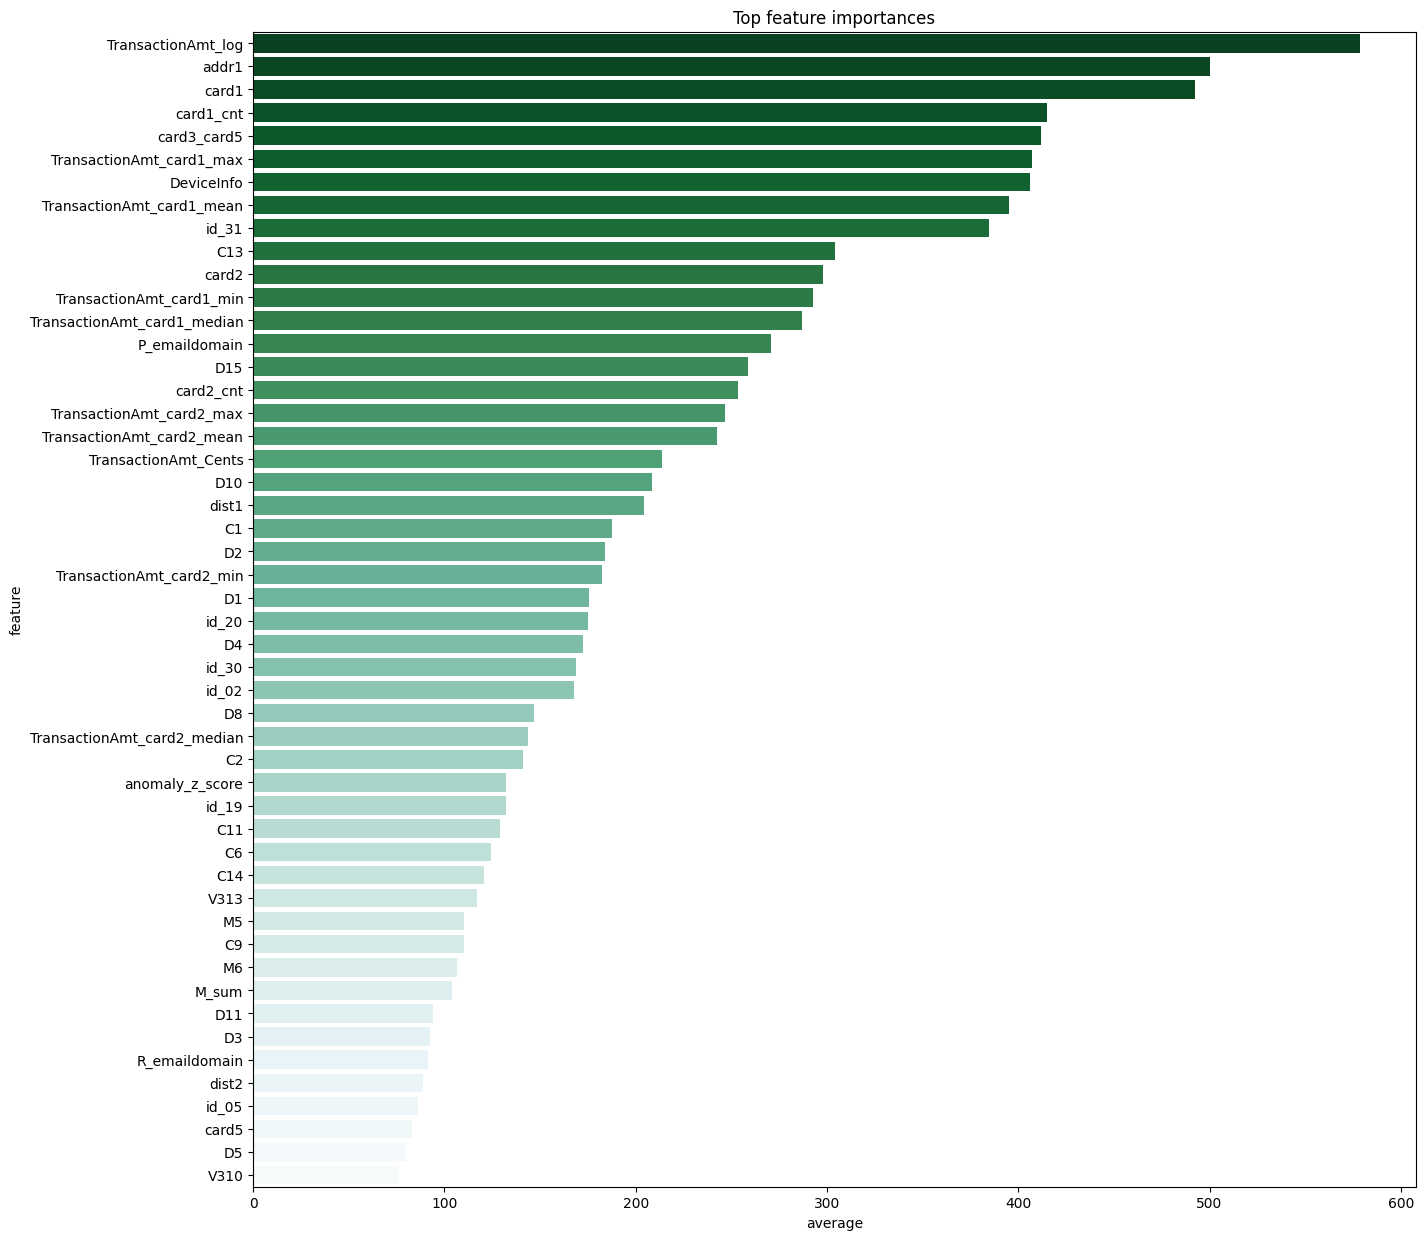

In [ ]:
plt.figure(figsize=(15, 15))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature', palette="BuGn_r")
plt.title('Top feature importances')
plt.show()

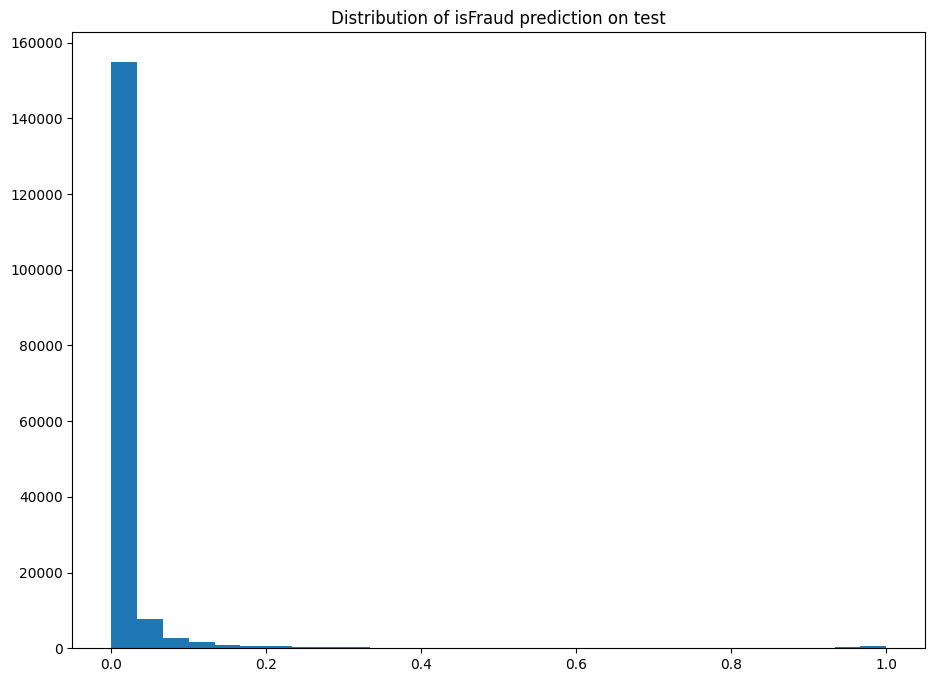

In [ ]:
final_pred = np.average(test_preds, axis=0)
sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': final_pred})
sub.to_csv('submission_baseline_fe_0_iso_forest_z.csv', index=False)

plt.figure(figsize=(11, 8))
plt.hist(sub['isFraud'], bins=30)
plt.title('Distribution of isFraud prediction on test')
plt.show()

# **Задание 4 (1 балл)**

Сделайте кластеризацию различными способами. Результаты кластеризации используйте для улучшения ML-решений:

1) Номера кластеров закодируйте (OHE или target-encoding) и добавьте как новые признаки

2) При использовании DBSCAN / HDBSCAN предсказанный шум можно трактовать как найденную аномалию и также добавить ее как новый признак

Проведите различные эксперименты. Проверьте как эти подходы влияют на качество прогнозов по кросс-валидации и на лидерборде, сделайте выводы.

In [ ]:
df_train = df_train_final.copy()
df_test = df_test_final.copy()

In [ ]:
num_cols = df_train.select_dtypes(include=['number']).columns.drop('isFraud', errors='ignore')

X_train_num = df_train[num_cols].copy()
X_test_num = df_test[num_cols].copy()

In [ ]:
%%time

from sklearn.cluster import KMeans

n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=777, n_init='auto')
df_train['cluster_kmeans'] = kmeans.fit_predict(X_train_num)
df_test['cluster_kmeans'] = kmeans.predict(X_test_num)

train_distances = kmeans.transform(X_train_num)
test_distances = kmeans.transform(X_test_num)

for i in range(n_clusters):
    df_train[f'kmeans_distance_{i}'] = train_distances[:, i]
    df_test[f'kmeans_distance_{i}'] = test_distances[:, i]

<timed exec>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


CPU times: user 37.5 s, sys: 4.25 s, total: 41.8 s
Wall time: 38.9 s


<timed exec>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

In [ ]:
df_train[['cluster_kmeans'] + [f'kmeans_distance_{i}' for i in range(n_clusters)]].head()

cluster_kmeans  kmeans_distance_0  kmeans_distance_1  kmeans_distance_2  \
0               6       3.229395e+06       6.616320e+06       1.989397e+06   
1               6       3.229410e+06       6.616328e+06       1.989426e+06   
2               6       3.229381e+06       6.616263e+06       1.989371e+06   
3               6       3.229359e+06       6.616228e+06       1.989322e+06   
4               0       1.687958e+06       7.026395e+06       2.966111e+06   

   kmeans_distance_3  kmeans_distance_4  kmeans_distance_5  kmeans_distance_6  \
0       9.723632e+06       5.080775e+06       1.203476e+07       6.740895e+05   
1       9.723637e+06       5.080786e+06       1.203477e+07       6.741777e+05   
2       9.723572e+06       5.080721e+06       1.203475e+07       6.741408e+05   
3       9.723538e+06       5.080686e+06       1.203474e+07       6.740612e+05   
4       9.998828e+06       5.589260e+06       9.727000e+06       2.374083e+06   

   kmeans_distance_7  kmeans_distance_8  kmeans_distance_9  
0       3.473509e+06       8.019717e+06       8.146835e+06  
1       3.473526e+06       8.019723e+06       8.146841e+06  
2       3.473462e+06       8.019663e+06       8.146776e+06  
3       3.473424e+06       8.019631e+06       8.146742e+06  
4       4.195714e+06       7.475183e+06       8.486843e+06

По традиции...

In [ ]:
import sys
vars_in_memory = {name: sys.getsizeof(value) for name, value in globals().items()}
df_memory = pd.DataFrame(vars_in_memory.items(), columns=['Variable', 'Size (bytes)'])
df_memory = df_memory.sort_values(by='Size (bytes)', ascending=False)
df_memory['Size (MB)'] = df_memory['Size (bytes)'] / (1024 * 1024)

In [ ]:
df_memory.head(15)

Variable  Size (bytes)    Size (MB)
35   train_transaction    1552337821  1480.424710
57            df_train    1301057832  1240.785439
180     df_train_final    1265982876  1207.335354
76         df_combined    1253655955  1195.579486
85             X_train    1064775727  1015.449264
37    test_transaction     649023609   618.957147
169                 df     536150901   511.313344
58             df_test     536150901   511.313344
181      df_test_final     521620497   497.456071
191        X_train_num     338640513   322.952760
192         X_test_num     140287755   133.788829
36      train_identity     127112436   121.223866
38       test_identity      38178982    36.410315
194    train_distances      33404848    31.857346
114          df_sample      20678160    19.720230

In [ ]:
del train_transaction, df_combined, X_train, test_transaction, train_identity, test_identity, df_sample, df

In [ ]:
import gc
gc.collect()

31

In [ ]:
import hdbscan
from sklearn.decomposition import PCA

pca = PCA(n_components=20, random_state=777)
X_train_pca = pca.fit_transform(X_train_num)
X_test_pca = pca.transform(X_test_num)

In [ ]:
%%time

hdb = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=10, prediction_data=True)
df_train['cluster_hdbscan'] = hdb.fit_predict(X_train_pca)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CPU times: user 52.5 s, sys: 1.48 s, total: 54 s
Wall time: 2min 2s


<timed exec>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


In [ ]:
%%time

df_test['cluster_hdbscan'], _ = hdbscan.approximate_predict(hdb, X_test_pca)

df_train['hdbscan_anomaly'] = (df_train['cluster_hdbscan'] == -1).astype(int)
df_test['hdbscan_anomaly'] = (df_test['cluster_hdbscan'] == -1).astype(int)

CPU times: user 5min 5s, sys: 440 ms, total: 5min 5s
Wall time: 6min 10s


<timed exec>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


In [ ]:
df_train[['cluster_hdbscan', 'hdbscan_anomaly']].head()

cluster_hdbscan  hdbscan_anomaly
0              658                0
1              658                0
2              568                0
3               -1                1
4               25                0

Теперь возьмем стандартную модель Елены с нашими новыми кластер-фичами

In [ ]:
for col in tqdm(df_train.columns.drop('isFraud')):
    if df_train[col].dtype == 'O':
        le = LabelEncoder()
        le.fit(list(df_train[col]) + list(df_test[col]))
        df_train[col] = le.transform(df_train[col])
        df_test[col] = le.transform(df_test[col])
        df_train[col] = df_train[col].astype('category')
        df_test[col] = df_test[col].astype('category')

# выделяем фолды
month_length = 3600 * 24 * 30
fold0_idx = df_train[df_train['TransactionDT'] < df_train['TransactionDT'].min() + month_length].index
fold1_idx = df_train[(df_train['TransactionDT'].min() + month_length <= df_train['TransactionDT']) & (df_train['TransactionDT'] < df_train['TransactionDT'].min() + 2 * month_length)].index
fold2_idx = df_train[(df_train['TransactionDT'].min() + 2 * month_length <= df_train['TransactionDT']) & (df_train['TransactionDT'] < df_train['TransactionDT'].min() + 3 * month_length)].index
fold3_idx = df_train[df_train['TransactionDT'].min() + 3 * month_length <= df_train['TransactionDT']].index
folds_idx = [fold0_idx, fold1_idx, fold2_idx, fold3_idx]

# выделяем идентификационный и временной признаки
df_train.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_test.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)

100%|██████████| 464/464 [01:00<00:00,  7.70it/s]


In [ ]:
df_train = df_train.copy()
df_test = df_test.copy()
df_train.shape, df_test.shape

((417559, 463), (172981, 462))

In [ ]:
%%time

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'n_jobs': -1,
    'n_estimators': 2000,
    'seed': 777,
    'early_stopping_rounds': 200,
}

scores = []

feature_importances = pd.DataFrame()
feature_importances['feature'] = df_train.columns.drop('isFraud')

test_preds = []

for i in range(len(folds_idx)):
    X_train = df_train.drop(folds_idx[i], axis=0)
    y_train = X_train['isFraud'].values
    X_val = df_train.iloc[folds_idx[i]]
    y_val = X_val['isFraud'].values
    X_train = X_train.drop('isFraud', axis=1)
    X_val = X_val.drop('isFraud', axis=1)

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    #lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_eval, verbose_eval=100)

    lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_eval,
    callbacks=[
        lgb.early_stopping(stopping_rounds=200),
        lgb.log_evaluation(100)])

    feature_importances['fold_{}'.format(i)] = lgb_model.feature_importance()

    y_pred = lgb_model.predict(X_val)
    score_fold = roc_auc_score(y_val, y_pred)
    scores.append(score_fold)
    y_test_pred = lgb_model.predict(df_test)
    test_preds.append(y_test_pred)

for i in range(len(scores)):
    print('Fold {}, AUC-ROC: {:.5f}'.format(i, scores[i]))
print('CV AUC-ROC: {:.5f}'.format(np.mean(scores)))

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 11320, number of negative: 271900
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.643799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37236
[LightGBM] [Info] Number of data points in the train set: 283220, number of used features: 460
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.039969 -> initscore=-3.178863
[LightGBM] [Info] Start training from score -3.178863
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.889073
[200]	valid_0's auc: 0.897411
[300]	valid_0's auc: 0.

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 11144, number of negative: 317016
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.005338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40188
[LightGBM] [Info] Number of data points in the train set: 328160, number of used features: 460
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033959 -> initscore=-3.348051
[LightGBM] [Info] Start training from score -3.348051
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.915316
[200]	valid_0's auc: 0.923056
[300]	valid_0's auc: 0.

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 10997, number of negative: 314373
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.621226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40089
[LightGBM] [Info] Number of data points in the train set: 325370, number of used features: 460
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033798 -> initscore=-3.352958
[LightGBM] [Info] Start training from score -3.352958
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.921448
[200]	valid_0's auc: 0.925204
[300]	valid_0's auc: 0.

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 10702, number of negative: 305225
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.770022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 40196
[LightGBM] [Info] Number of data points in the train set: 315927, number of used features: 460
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033875 -> initscore=-3.350619
[LightGBM] [Info] Start training from score -3.350619
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.902048
[200]	valid_0's auc: 0.904884
[300]	valid_0's auc: 0.

CV AUC-ROC: 0.91661  
Kaggle Score: 0.91592

Ээх. Снова без улучшений.

In [ ]:
fold_cols = [col for col in feature_importances.columns if col.startswith('fold_')]
feature_importances['average'] = feature_importances[fold_cols].mean(axis=1)
feature_importances.head()

feature  fold_0  fold_1  fold_2  fold_3  average
0  ProductCD      25      38      35      29    31.75
1      card1     383     757     548     132   455.00
2      card2     292     483     316      82   293.25
3      card3       7       9       9       6     7.75
4      card4       6      11       1       1     4.75

<ipython-input-93-38e95bf7c8d0>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature', palette="BuGn_r")


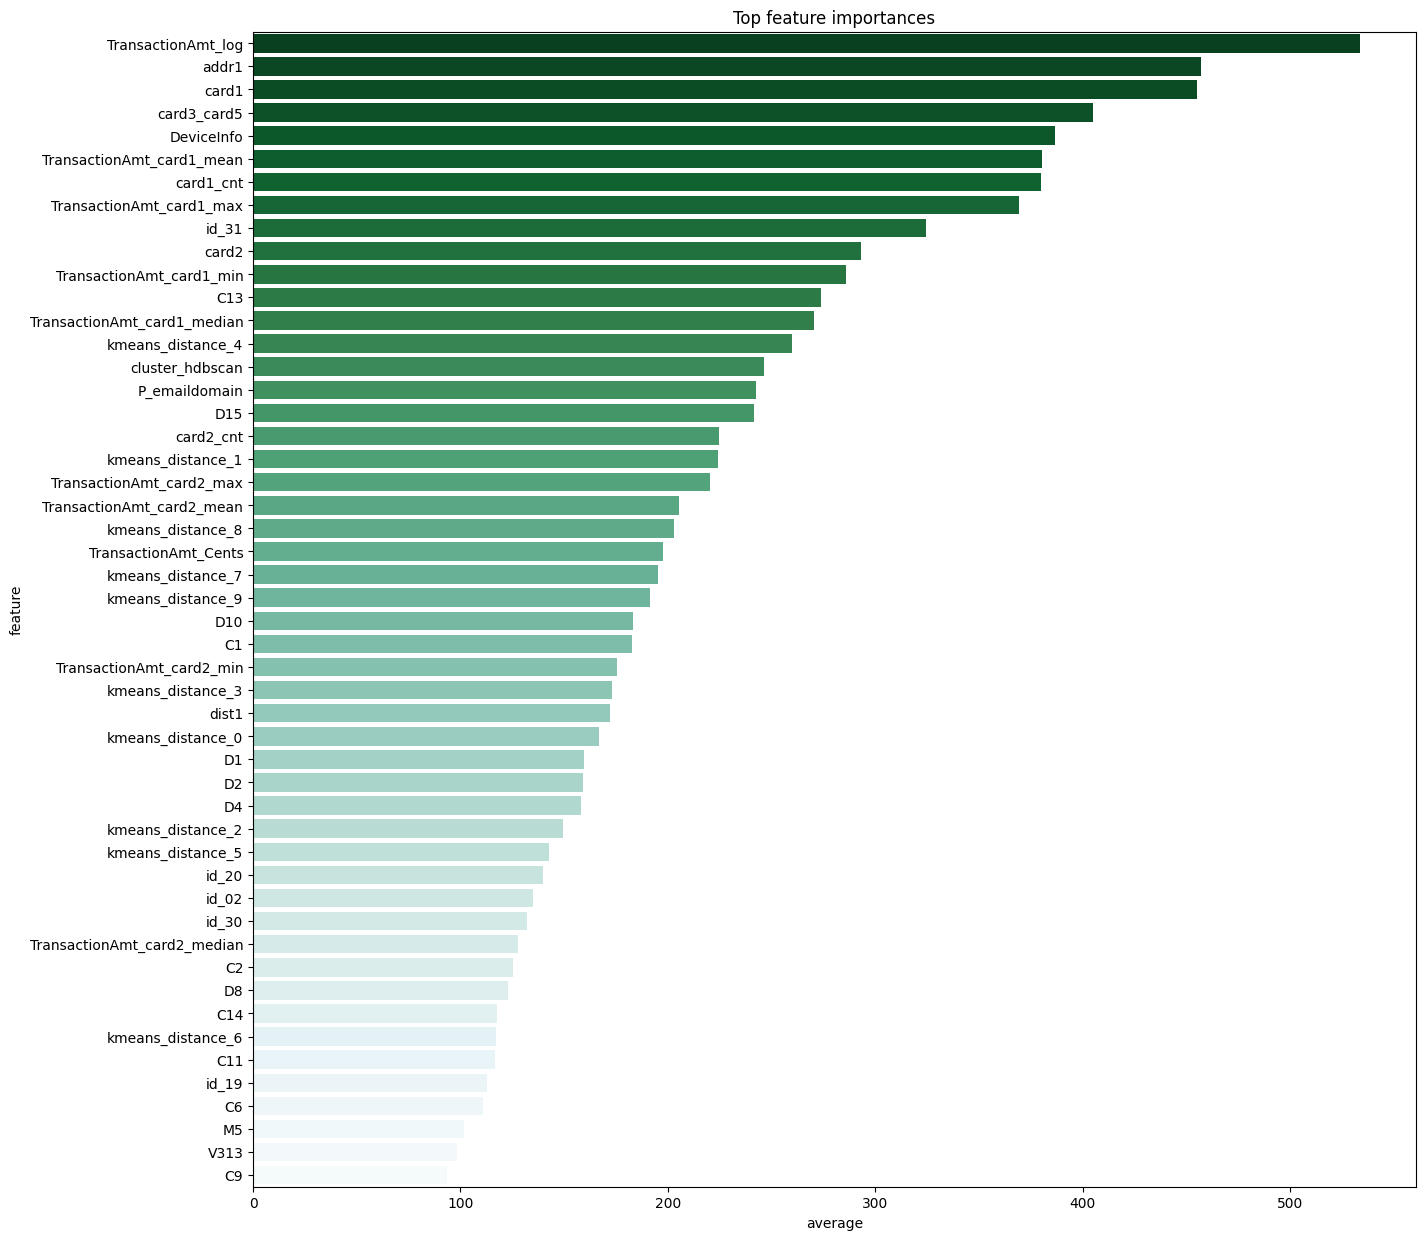

In [ ]:
plt.figure(figsize=(15, 15))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature', palette="BuGn_r")
plt.title('Top feature importances')
plt.show()

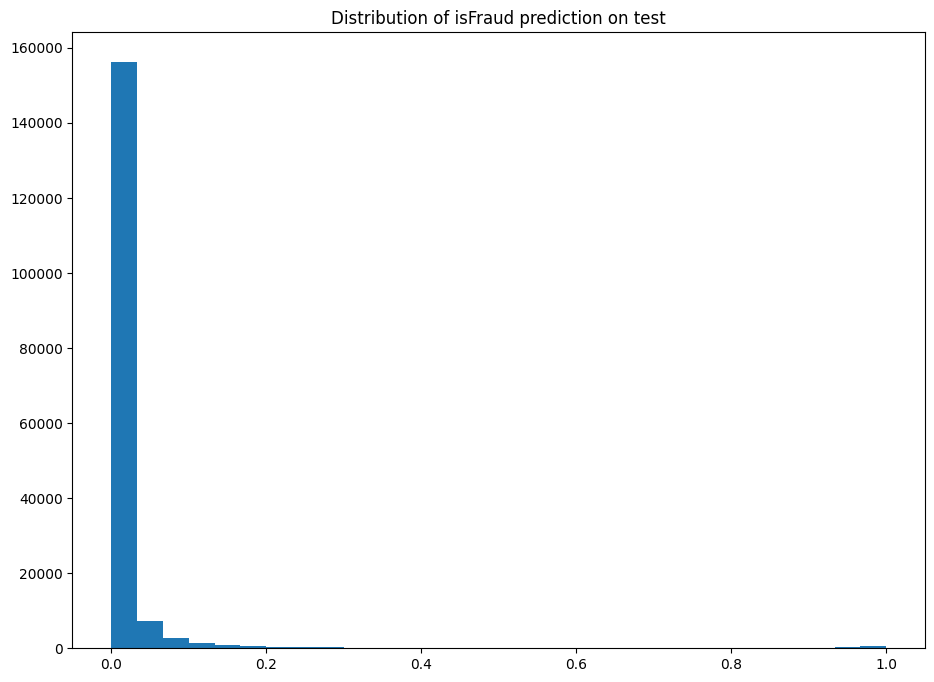

In [ ]:
final_pred = np.average(test_preds, axis=0)
sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': final_pred})
sub.to_csv('submission_baseline_fe_0_hdbscan_kmeans.csv', index=False)

plt.figure(figsize=(11, 8))
plt.hist(sub['isFraud'], bins=30)
plt.title('Distribution of isFraud prediction on test')
plt.show()

## **Задание 5 (1 балл)**

Примените какой-нибудь (один любой) AutoML фреймворк для решения поставленной задачи.

Отправьте AutoML-прогноз на kaggle и посмотрите на качество модели. Сделайте текстовые выводы.

In [ ]:
df_train = df_train_final.copy()
df_test = df_test_final.copy()

In [ ]:
!pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


Возьмем lightautoml, недаром же коллеги из Сбера так над ним трудились)

In [ ]:
!pip install --no-cache-dir lightautoml -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 205.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 177.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 250.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 184.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 106.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 243.2 MB/s eta 0:00

In [ ]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

In [ ]:
target_col = "isFraud"
features = [col for col in df_train.columns if col != target_col]

automl = TabularAutoML(task=Task("binary"), timeout=3600, cpu_limit=-1, memory_limit=4)

In [ ]:
df_train.head()

TransactionID  isFraud  TransactionDT ProductCD  card1  card2  card3  \
0        2987000        0          86400         W  13926     99    150   
1        2987001        0          86401         W   2755    404    150   
2        2987002        0          86469         W   4663    490    150   
3        2987003        0          86499         W  18132    567    150   
4        2987004        0          86506         H   4497    514    150   

        card4  card5   card6  addr1  addr2  dist1  dist2    P_emaildomain  \
0    discover    142  credit    315     87     19     -1  unseen_category   
1  mastercard    102  credit    325     87     -1     -1        gmail.com   
2        visa    166   debit    330     87    287     -1      outlook.com   
3  mastercard    117   debit    476     87     -1     -1        yahoo.com   
4  mastercard    102  credit    420     87     -1     -1        gmail.com   

     R_emaildomain  C1  C2  C3  C4  C5  C6  C7  C8  C9  C10  C11  C12  C13  \
0  unseen_category   1   1   0   0   0   1   0   0   1    0    2    0    1   
1  unseen_category   1   1   0   0   0   1   0   0   0    0    1    0    1   
2  unseen_category   1   1   0   0   0   1   0   0   1    0    1    0    1   
3  unseen_category   2   5   0   0   0   4   0   0   1    0    1    0   25   
4  unseen_category   1   1   0   0   0   1   0   1   0    1    1    0    1   

   C14   D1   D2  D3   D4  D5  D6  D7   D8   D9  D10  D11  D12  D13  D14  D15  \
0    1   14   -1  13 -123  -1 -84  -1 -1.0 -1.0   13   13  -84   -1 -194    0   
1    1    0   -1  -1    0  -1 -84  -1 -1.0 -1.0    0  -54  -84   -1 -194    0   
2    1    0   -1  -1    0  -1 -84  -1 -1.0 -1.0    0  315  -84   -1 -194  315   
3    1  112  112   0   94   0 -84  -1 -1.0 -1.0   84  -54  -84   -1 -194  111   
4    1    0   -1  -1 -123  -1 -84  -1 -1.0 -1.0   -1  -54  -84   -1 -194  -84   

                M1               M2               M3               M4  \
0                T                T                T               M2   
1  unseen_category  unseen_category  unseen_category               M0   
2                T                T                T               M0   
3  unseen_category  unseen_category  unseen_category               M0   
4  unseen_category  unseen_category  unseen_category  unseen_category   

                M5               M6               M7               M8  \
0                F                T  unseen_category  unseen_category   
1                T                T  unseen_category  unseen_category   
2                F                F                F                F   
3                T                F  unseen_category  unseen_category   
4  unseen_category  unseen_category  unseen_category  unseen_category   

                M9  V1  V2  V3  V4  V5  V6  V7  V8  V9  V10  V11  V12  V13  \
0  unseen_category   1   1   1   1   1   1   1   1   1    0    0    1    1   
1  unseen_category  -1  -1  -1  -1  -1  -1  -1  -1  -1   -1   -1    0    0   
2                F   1   1   1   1   1   1   1   1   1    0    0    1    1   
3  unseen_category  -1  -1  -1  -1  -1  -1  -1  -1  -1   -1   -1    1    1   
4  unseen_category  -1  -1  -1  -1  -1  -1  -1  -1  -1   -1   -1   -1   -1   

   V14  V15  V16  V17  V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  \
0    1    0    0    0    0    1    1    0    0    1    1    1    1    0    0   
1    1    0    0    0    0    1    1    0    0    1    1    1    1    0    0   
2    1    0    0    0    0    1    1    0    0    1    1    1    1    0    0   
3    1    0    0    0    0    1    1    0    0    1    1    1    1    0    0   
4   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   

   V29  V30  V31  V32  V33  V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  \
0    0    0    0    0    0    0   -1   -1   -1   -1   -1   -1   -1   -1   -1   
1    0    0    0    0    0    0    0    0    1    1    0    0    1    0    0   
2    0    0    0    0    0    0    1    1    1    1    0    0    

In [ ]:
print(df_train.columns)

Index(['TransactionID', 'isFraud', 'TransactionDT', 'ProductCD', 'card1',
       'card2', 'card3', 'card4', 'card5', 'card6',
       ...
       'TransactionAmt_card1_min', 'TransactionAmt_card1_max',
       'TransactionAmt_card2_mean', 'TransactionAmt_card2_median',
       'TransactionAmt_card2_min', 'TransactionAmt_card2_max', 'id_33_width',
       'id_33_height', 'id_33_pixels', 'M_sum'],
      dtype='object', length=452)


In [ ]:
df_train.shape

(417559, 452)

In [ ]:
df_test.shape

(172981, 451)

почистим память

In [ ]:
import sys
vars_in_memory = {name: sys.getsizeof(value) for name, value in globals().items()}
df_memory = pd.DataFrame(vars_in_memory.items(), columns=['Variable', 'Size (bytes)'])
df_memory = df_memory.sort_values(by='Size (bytes)', ascending=False)
df_memory['Size (MB)'] = df_memory['Size (bytes)'] / (1024 * 1024)

In [ ]:
df_memory.head(15)

Variable  Size (bytes)    Size (MB)
34   train_transaction    1552337821  1480.424710
169     df_train_final    1265982876  1207.335354
56            df_train    1265982876  1207.335354
73         df_combined    1253655955  1195.579486
82             X_train    1064775727  1015.449264
36    test_transaction     649023609   618.957147
170      df_test_final     521620497   497.456071
57             df_test     521620497   497.456071
159                 df     521620497   497.456071
35      train_identity     127112436   121.223866
37       test_identity      38178982    36.410315
111          df_sample      20678160    19.720230
164            temp_df      11070948    10.558079
38   sample_submission       2767860     2.639637
88                 sub       2767860     2.639637

In [ ]:
del train_transaction, df_combined, X_train, test_transaction, df, train_identity, test_identity, df_sample
import gc
gc.collect()

0

In [ ]:
%%time

automl.fit_predict(df_train, roles={"target": target_col})

INFO:lightautoml.automl.presets.base:Stdout logging level is ERROR.
INFO:lightautoml.automl.presets.base:Task: binary

INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:
INFO:lightautoml.automl.presets.base:- time: 3600.00 seconds
INFO:lightautoml.automl.presets.base:- CPU: 2 cores
INFO:lightautoml.automl.presets.base:- memory: 4 GB

INFO:lightautoml.reader.base:Train data shape: (417559, 452)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []
INFO:lightautoml.automl.base:Layer 1 train process start. Time left 3479.16 secs
INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 2

CPU times: user 1h 30s, sys: 1min 19s, total: 1h 1min 49s
Wall time: 39min 6s


array([[0.05590603],
       [0.00025575],
       [       nan],
       ...,
       [       nan],
       [       nan],
       [       nan]], dtype=float32)

lightautoml.automl.blend:Blending: best score = 0.9650310
Kaggle Score: 0.89217

Странно. Такие хорошие рок-ауки в логах и такой плохой на каггл лидерборде =(

In [ ]:
test_preds = automl.predict(df_test)

sub = pd.DataFrame({'TransactionID': sample_submission['TransactionID'], 'isFraud': test_preds.data[:, 0]})
sub.to_csv('submission_baseline_automl.csv', index=False)

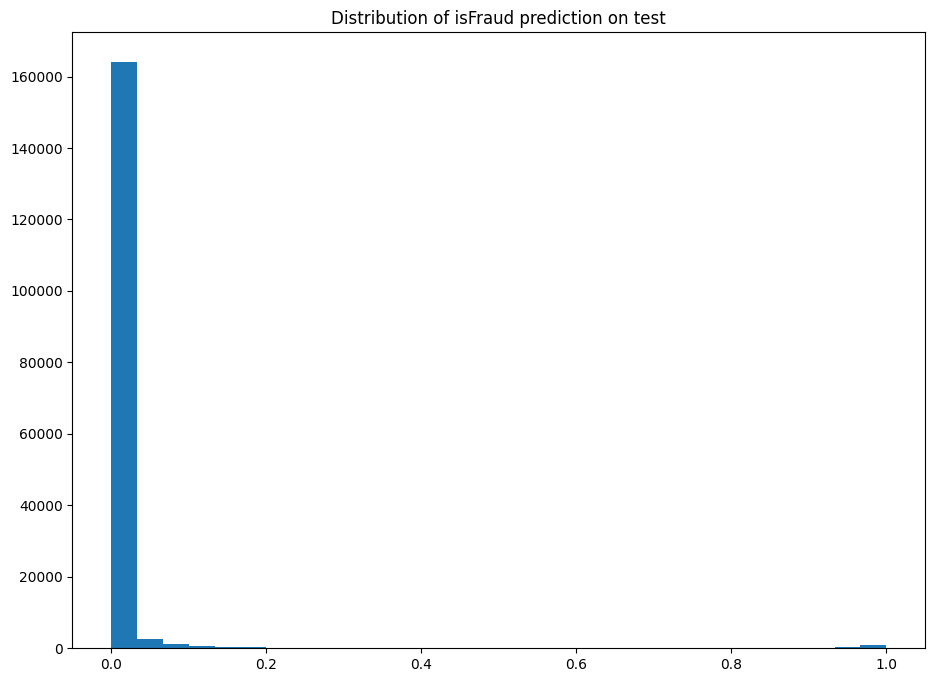

In [ ]:
plt.figure(figsize=(11, 8))
plt.hist(sub['isFraud'], bins=30)
plt.title('Distribution of isFraud prediction on test')
plt.show()

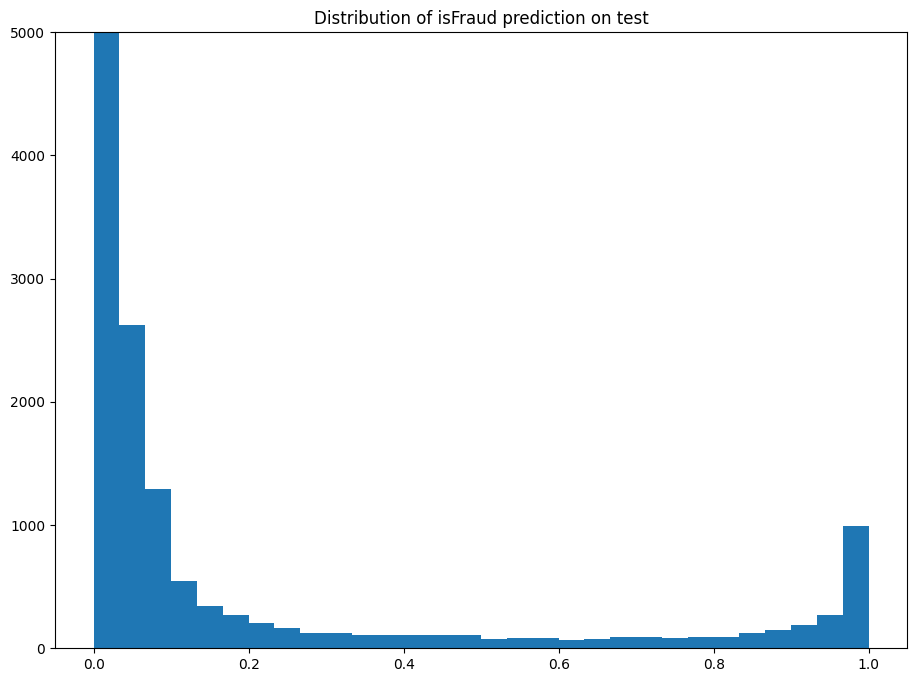

In [ ]:
plt.figure(figsize=(11, 8))
plt.hist(sub['isFraud'], bins=30)
plt.title('Distribution of isFraud prediction on test')
plt.ylim(0,5000)
plt.show()

# **Задание 6 (1 балл)**

Весь курс мы работали в Google Colab. Но всегда должны быть запасные варианты, где Вы будете обучать модели.

Среди вариантов есть:
* ваша локальная машина
* kaggle notebooks
* yandex cloud
и другие.

Кроме привычного Google Colab выберите из списка выше один любой альтернативный вариант и проведите эксперимент:

* Прогоните ваш лучший по качеству по результатам заданий 2-4 ML-пайплайн заново в Google Colab и с помощью библиотек (например, при помощи библиотеки time) замерьте время обучения и отдельно время инференса на тестовых данных

* Прогоните этот пайплайн на выбранном альтернативном сервисе/локальной машине и также замерьте время обучения и инференса.

Текстом напишите выводы: опишите, какое альтернативное место для обучения моделей Вы использовали? Прикрепите прямо в ноутбук скриншот с экраном кода в альтернативном сервисе/на локальной машине. Также в виде таблицы приведите сравнение времени обучения и инференса в колабе и в альтернативном месте. Сделайте выводы.

**Итак.** Лучший-лучший пайплайн я обучить в колабе не смогу, он точно упадет по памяти, да и занимает он 5 каггл-ноутбуков: минимизация данных, фиче-инжиниринг, xgboost, lightgbm, catboost, ансамблирование их с постпроцессингом. Про каждый пункт напишу ниже в бонусе.  
Так что давайте прогоним бейзлайн и посмотрим. Ставлю на kaggle =)

In [86]:
df_train = df_train_final.copy()
df_test = df_test_final.copy()

Сохраним данные в pickle, чтобы достать их на kaggle такими же.

In [82]:
df_train.to_pickle("df_train.pkl")
df_test.to_pickle("df_test.pkl")

In [87]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417559 entries, 0 to 417558
Columns: 452 entries, TransactionID to M_sum
dtypes: float32(89), float64(4), int16(53), int64(2), int8(230), object(33), uint16(22), uint32(3), uint8(16)
memory usage: 428.5+ MB


Инференс у lightgbm-a быстрый, да и на кроссвалидации его не померить отдельно, так что померяем время энкодинга, обучения и инференса сразу.

In [88]:
%%time

for col in tqdm(df_train.columns.drop('isFraud')):
    if df_train[col].dtype == 'O':
        le = LabelEncoder()
        le.fit(list(df_train[col]) + list(df_test[col]))
        df_train[col] = le.transform(df_train[col])
        df_test[col] = le.transform(df_test[col])
        df_train[col] = df_train[col].astype('category')
        df_test[col] = df_test[col].astype('category')

# выделяем фолды
month_length = 3600 * 24 * 30
fold0_idx = df_train[df_train['TransactionDT'] < df_train['TransactionDT'].min() + month_length].index
fold1_idx = df_train[(df_train['TransactionDT'].min() + month_length <= df_train['TransactionDT']) & (df_train['TransactionDT'] < df_train['TransactionDT'].min() + 2 * month_length)].index
fold2_idx = df_train[(df_train['TransactionDT'].min() + 2 * month_length <= df_train['TransactionDT']) & (df_train['TransactionDT'] < df_train['TransactionDT'].min() + 3 * month_length)].index
fold3_idx = df_train[df_train['TransactionDT'].min() + 3 * month_length <= df_train['TransactionDT']].index
folds_idx = [fold0_idx, fold1_idx, fold2_idx, fold3_idx]

# выделяем идентификационный и временной признаки
df_train.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_test.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'n_jobs': -1,
    'n_estimators': 2000,
    'seed': 777,
    'early_stopping_rounds': 200,
}

scores = []

feature_importances = pd.DataFrame()
feature_importances['feature'] = df_train.columns.drop('isFraud')

test_preds = []

for i in range(len(folds_idx)):
    X_train = df_train.drop(folds_idx[i], axis=0)
    y_train = X_train['isFraud'].values
    X_val = df_train.iloc[folds_idx[i]]
    y_val = X_val['isFraud'].values
    X_train = X_train.drop('isFraud', axis=1)
    X_val = X_val.drop('isFraud', axis=1)

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_eval,
    callbacks=[
        lgb.early_stopping(stopping_rounds=200),
        lgb.log_evaluation(100)])

    feature_importances['fold_{}'.format(i)] = lgb_model.feature_importance()

    y_pred = lgb_model.predict(X_val)
    score_fold = roc_auc_score(y_val, y_pred)
    scores.append(score_fold)
    y_test_pred = lgb_model.predict(df_test)
    test_preds.append(y_test_pred)

for i in range(len(scores)):
    print('Fold {}, AUC-ROC: {:.5f}'.format(i, scores[i]))
print('CV AUC-ROC: {:.5f}'.format(np.mean(scores)))

100%|██████████| 451/451 [00:25<00:00, 17.67it/s]
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 11320, number of negative: 271900
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.666816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 34436
[LightGBM] [Info] Number of data points in the train set: 283220, number of used features: 447
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.039969 -> initscore=-3.178863
[LightGBM] [Info] Start training from score -3.178863
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.891409
[200]	valid_0's auc: 0.90016
[300]	valid_0's auc: 0.9

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 11144, number of negative: 317016
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.505420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37382
[LightGBM] [Info] Number of data points in the train set: 328160, number of used features: 447
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033959 -> initscore=-3.348051
[LightGBM] [Info] Start training from score -3.348051
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.915296
[200]	valid_0's auc: 0.923497
[300]	valid_0's auc: 0.

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 10997, number of negative: 314373
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.110030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37282
[LightGBM] [Info] Number of data points in the train set: 325370, number of used features: 447
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033798 -> initscore=-3.352958
[LightGBM] [Info] Start training from score -3.352958
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.922312
[200]	valid_0's auc: 0.927685
[300]	valid_0's auc: 0.

/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 10702, number of negative: 305225
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.830504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37389
[LightGBM] [Info] Number of data points in the train set: 315927, number of used features: 447
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033875 -> initscore=-3.350619
[LightGBM] [Info] Start training from score -3.350619
Training until validation scores don't improve for 200 rounds
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.903238
[200]	valid_0's auc: 0.906677
[300]	valid_0's auc: 0.

13 минут, CV AUC-ROC: 0.91886. Неплохо. Теперь посмотрим, что нам ответил kaggle

In [89]:
import base64
from IPython.display import HTML


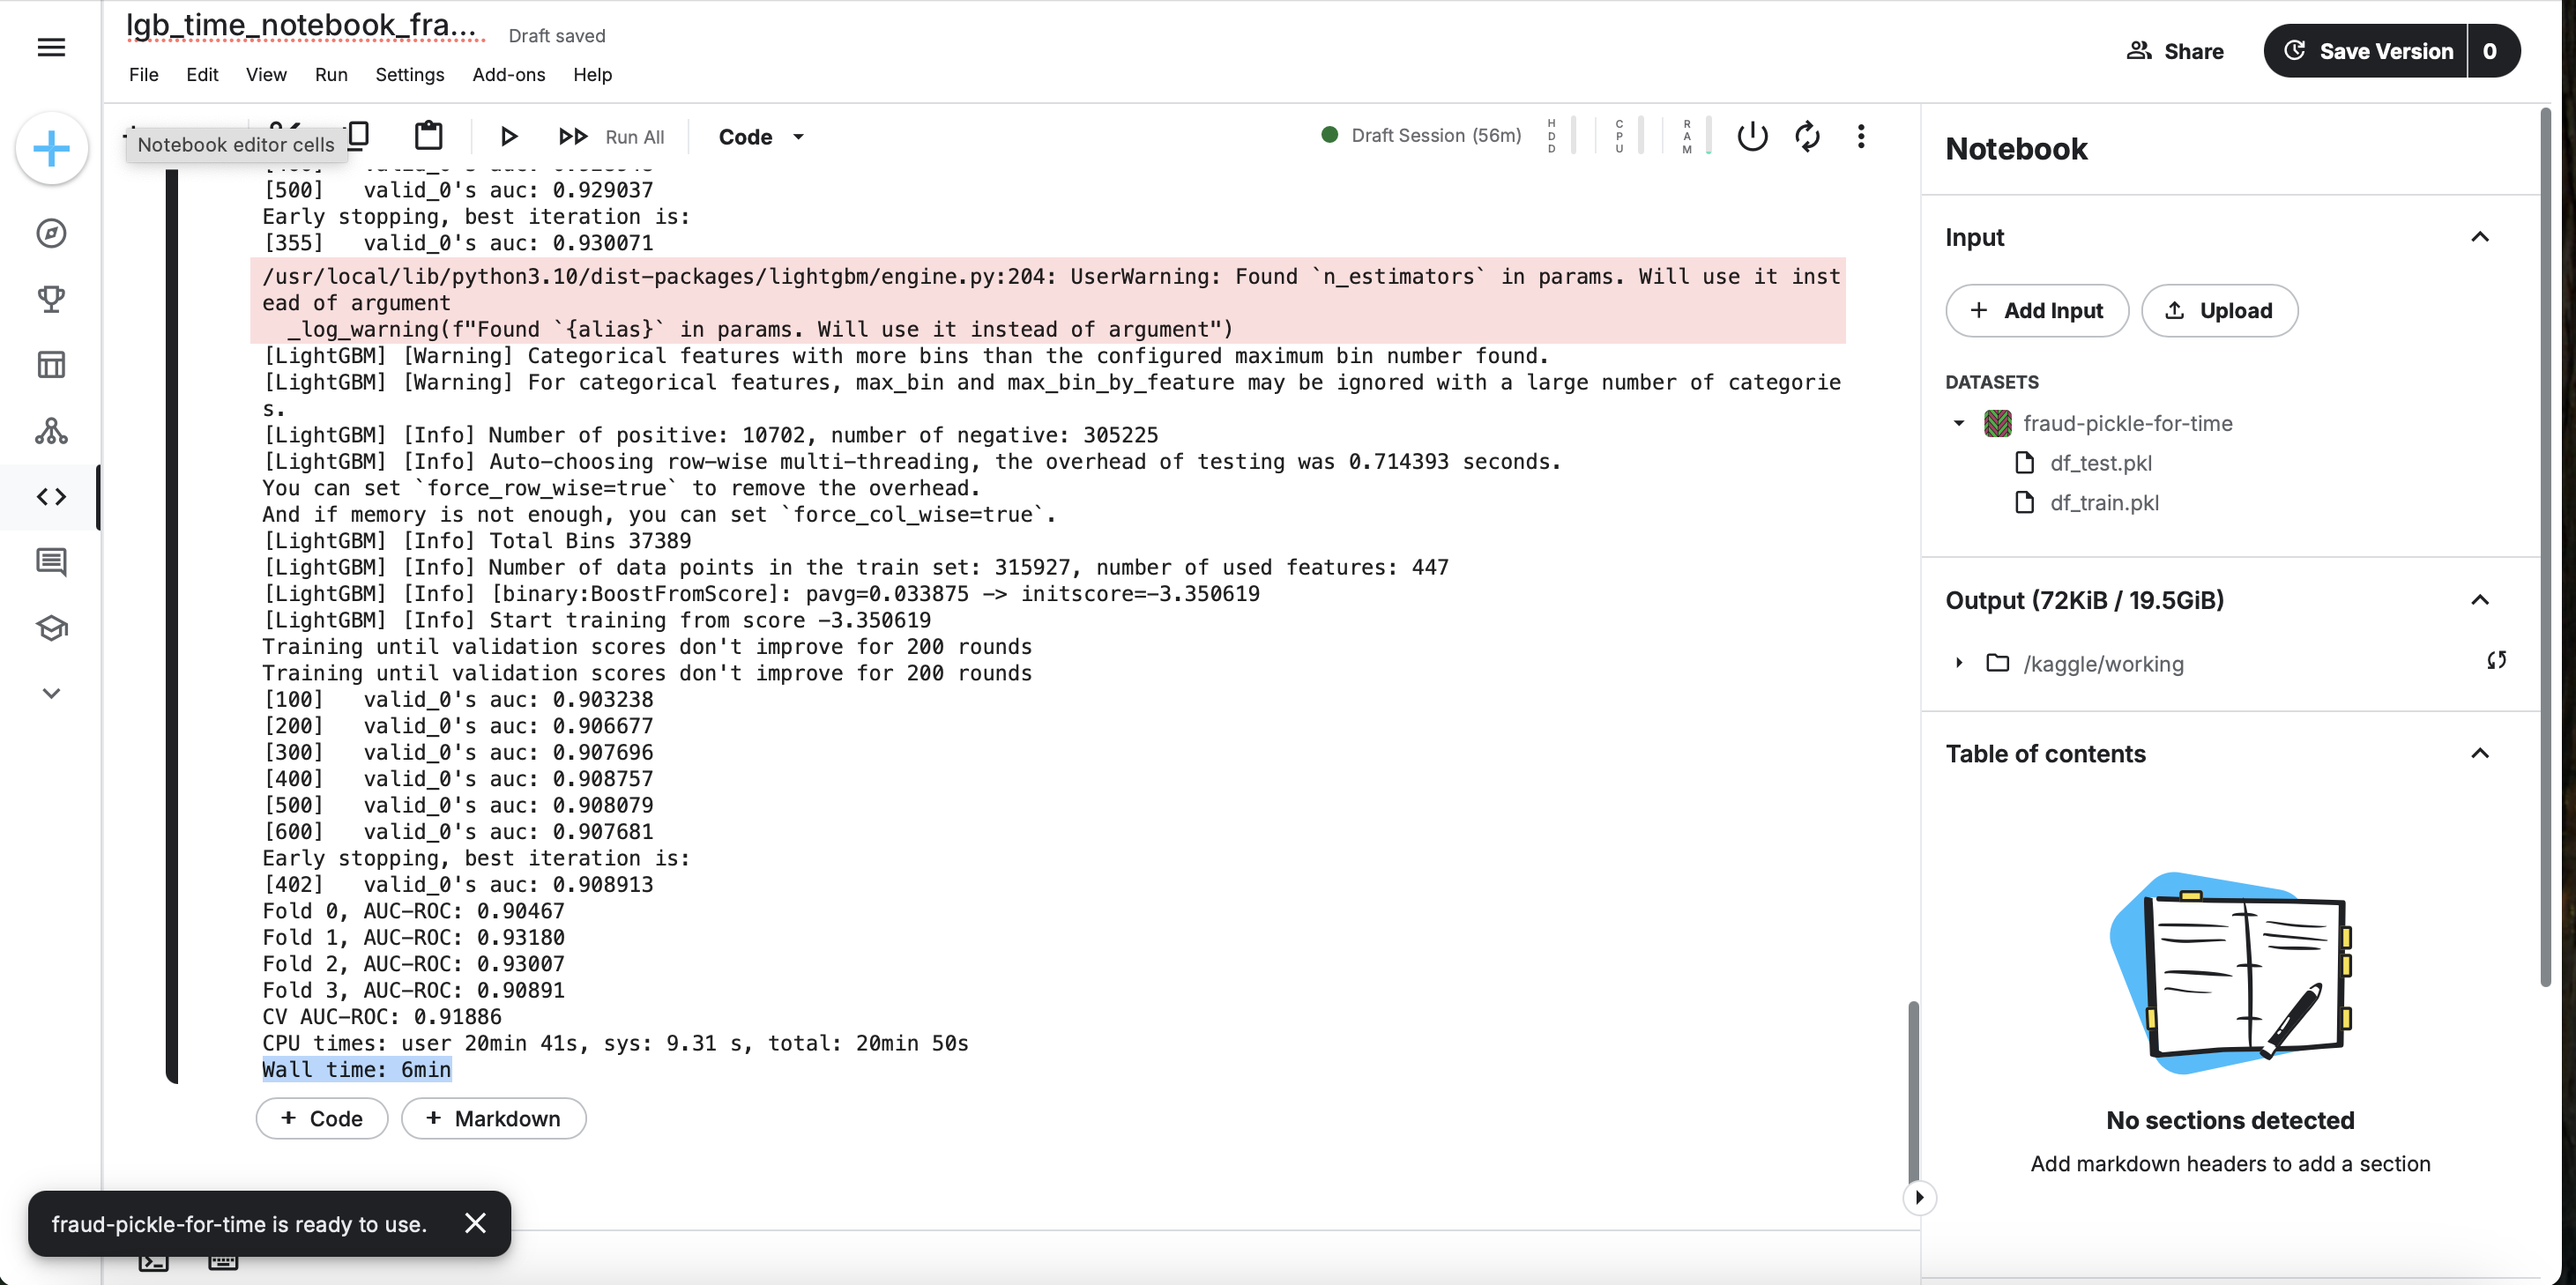

In [94]:
img_path = "/content/drive/My Drive/screenshots/fraud_detection_competition/kaggle_baseline_time.png"

with open(img_path, "rb") as img_file:
    encoded = base64.b64encode(img_file.read()).decode()

html_code = f'<img src="data:image/png;base64,{encoded}" width="600"/>'
display(HTML(html_code))

6 минут. Ееее! В 2 раза быстрее. Оно и понятно, на google colab оперативки 16 гб, на kaggle почти 30 гб. Да и процессоры на kaggle помощнее. А может просто народа там поменьше и больше ресурсов на каждого.

# **Бонус: за Kaggle и стремление к хорошим скорам (2 балла)**

В этом домашнем задании Ваша цель - не просто выполнить шаги выше, но и построить максимально хорошую по качеству модель.

**К 10 вы можете получить до двух дополнительных баллов:**

* За попадание в топ-20% на private leaderboard — +1 дополнительный балл к оценке
* За попадание в топ-5 мест на private leaderboard — + еще один дополнительный балл к оценке (то есть суммарно 2 дополнительных балла)

**ВАЖНО!!!**

Эти баллы ставятся до мягкого дедлайна по соревнованию. После мягкого дедлайна лидерборд не обновляется, и дополнительные баллы не ставятся.

Успехов!

**Итак. Расскажу, из чего состоит мое лучшее решение.**
1. Начнем с того, что после всех манипуляций в этом ноутбуке я не смог поднять скорр на лидерборде сильно свыше 0.92.  
Самый высокий скорр дало среднее геометрическое предсказаний lightGBM Елены и моего catboost-a в одном из этих пяти ноутбуков:  
submission_blend_geom.csv
Kaggle Score: 0.92286


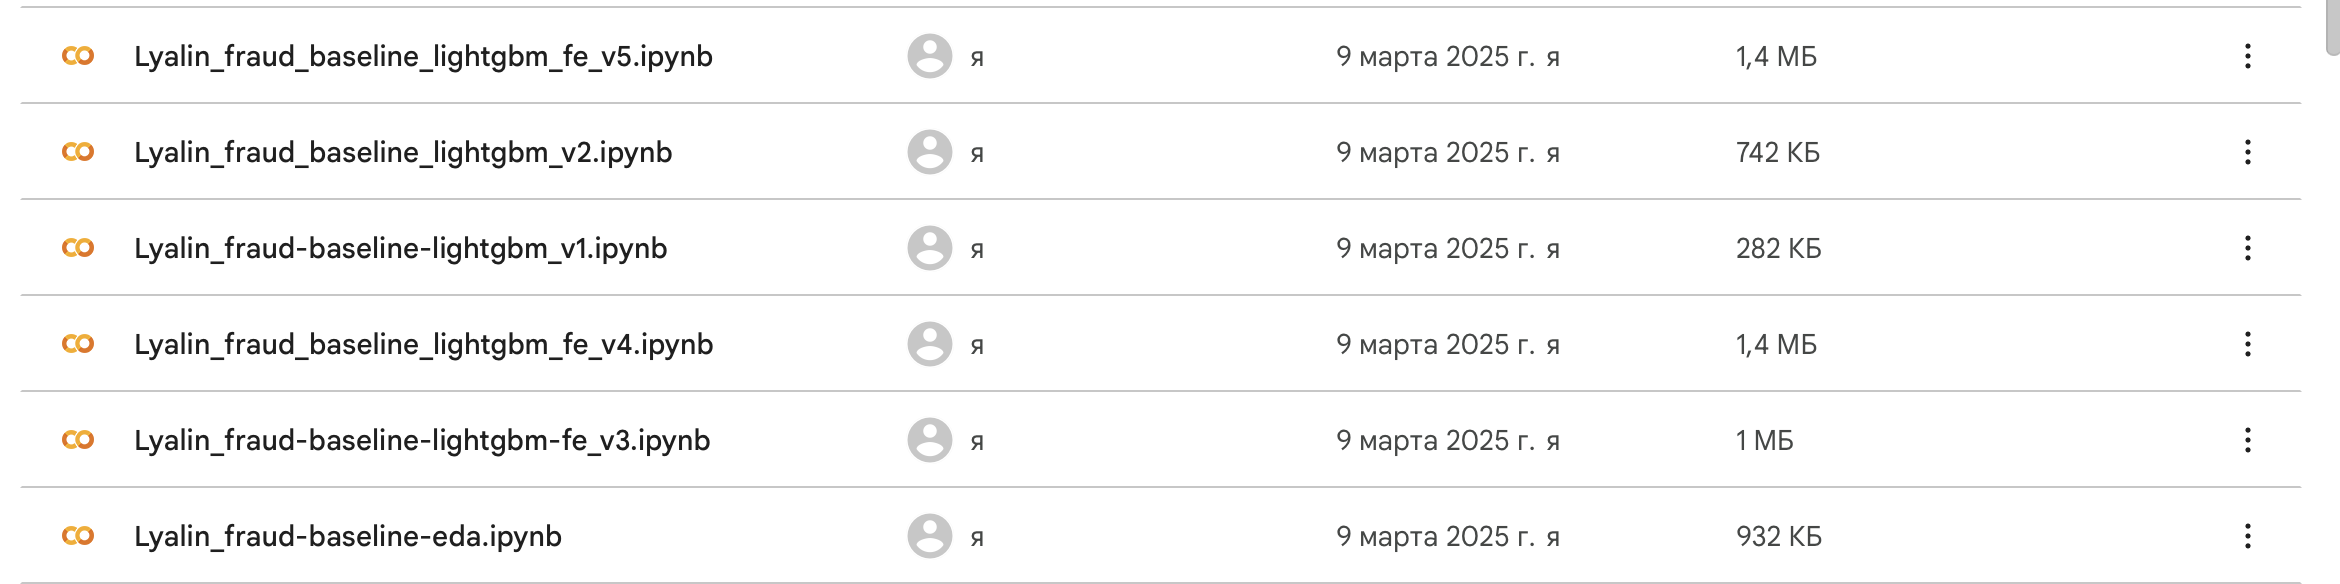

In [92]:
img_path = "/content/drive/My Drive/screenshots/fraud_detection_competition/google_colabs_more_ipynbs.png"

with open(img_path, "rb") as img_file:
    encoded = base64.b64encode(img_file.read()).decode()

html_code = f'<img src="data:image/png;base64,{encoded}" width="600"/>'
display(HTML(html_code))

2. Я начал искать новые схемы валидации и, возможно, cnn-ки на kaggle и наткнулся на интересное соревнование шестилетней давности, в которой мной любимый Chris Deotte взял свое единственное первое место с российским коллегой Константином:  
https://www.kaggle.com/competitions/ieee-fraud-detection

3. Изучив наши данные (4 месяца трейн и 2 месяца обрезанный тест)и данные в соревновании (6 месяцев трейн, далее пауза и 6 месяцев тест) я понял, что можно переиспользовать идеи грандмастеров с 1 и 2 места =)  
Изучив их подходы к финальному решению:  
https://www.kaggle.com/c/ieee-fraud-detection/discussion/111284  
https://www.kaggle.com/c/ieee-fraud-detection/discussion/111308  
https://www.kaggle.com/c/ieee-fraud-detection/discussion/111257  
https://www.kaggle.com/competitions/ieee-fraud-detection/discussion/111321  
я сделал следующие выводы:
- схема валидации, предложенная в бейзлайне Елены оптимальная (group kfold с 4-мя фолдами). Почему? А потому, что в соревновании мы ищем не фродовые транзакции, а фродовых клиентов банка, которые очень часто меняются, и тем более части клиентов теста нету в трейне.
- код я, конечно, заимствовал и тюнил (сам), за неделю я б точно не провел ту работу, которую коммьюнити (аж 6000 команд!) провело за 2.5 месяца. Да и за 2.5 месяца в одиночку б не догадался до многих идей.
- победили решения стекинга (этого пока я не умею хорошо) и блендинга (это я умею) с xgboost, lightgbm и catboost.  
- самыми голд фичами стали такие:  
```
# Из топ-1 решения:
X_train['day'] = X_train.TransactionDT / (24*60*60)
X_train['uid'] = X_train.card1_addr1.astype(str)+'_'+np.floor(X_train.day-X_train.D1).astype(str)
# Из топ-2 решения:
data['uid1']` =  (data.day - data.D1).astype(str) +'_' + \
            data.P_emaildomain.astype(str)
data['uid2'] =  (data.card1.astype(str) +'_' + \
            data.addr1.astype(str) +'_' + \
            (data.day - data.D1).astype(str) +'_' + \
            data.P_emaildomain.astype(str))
```
Причем в топ-2 решении грандмастер CPMP жалел, что удалил uid из трейна, опасаясь лика, и добавил его в последний день, что дало прирост в качестве.  
- Итак, что же такое uid? Это аналог одного клиента, правда, в него часто попадают 2-3 клиента, но модели их корректно находят и разделяют. И очень ценными фичами становятся фичи по каждому такому uid (средние, std и прочее-прочее).
- Сами uid я как удалял, так и оставлял в решениях, кодировал их target encoding-om по 4 фолдам. У меня это прироста не дало. Возможно, так как в xgboost-e у меня не зафиксированы сиды или из-за блендинга с разными версиями моделей.
- Я делал множество блендингов:  
a) cat + lgb + xgb по 0.33  
b) cat + lgb + xgb - 0.2 - 0.2 - 0.6 и прочие разные соотношения  
c) xgb + lgb по 0.5  
d) среднее геометрическое xgb + lgb  
e) и прочие разные соотношения xgb + lgb, победила версия 0.7 + 0.3  
- все блендинги улучшали качество сингл-моделей, как пояснили уважаемые грандмастера - это из-за того, что xgboost хорошо предсказывает клиентов, которых она видела в трейне, lgb - которых она не видела, а catboost и тех и тех.  
- последнее, что я сделал (позаимствовал) после блендинга - это построцессинг, где находил клиентов, у которых проставлен фрод (единичка), и доставлял им фрод в будущем.


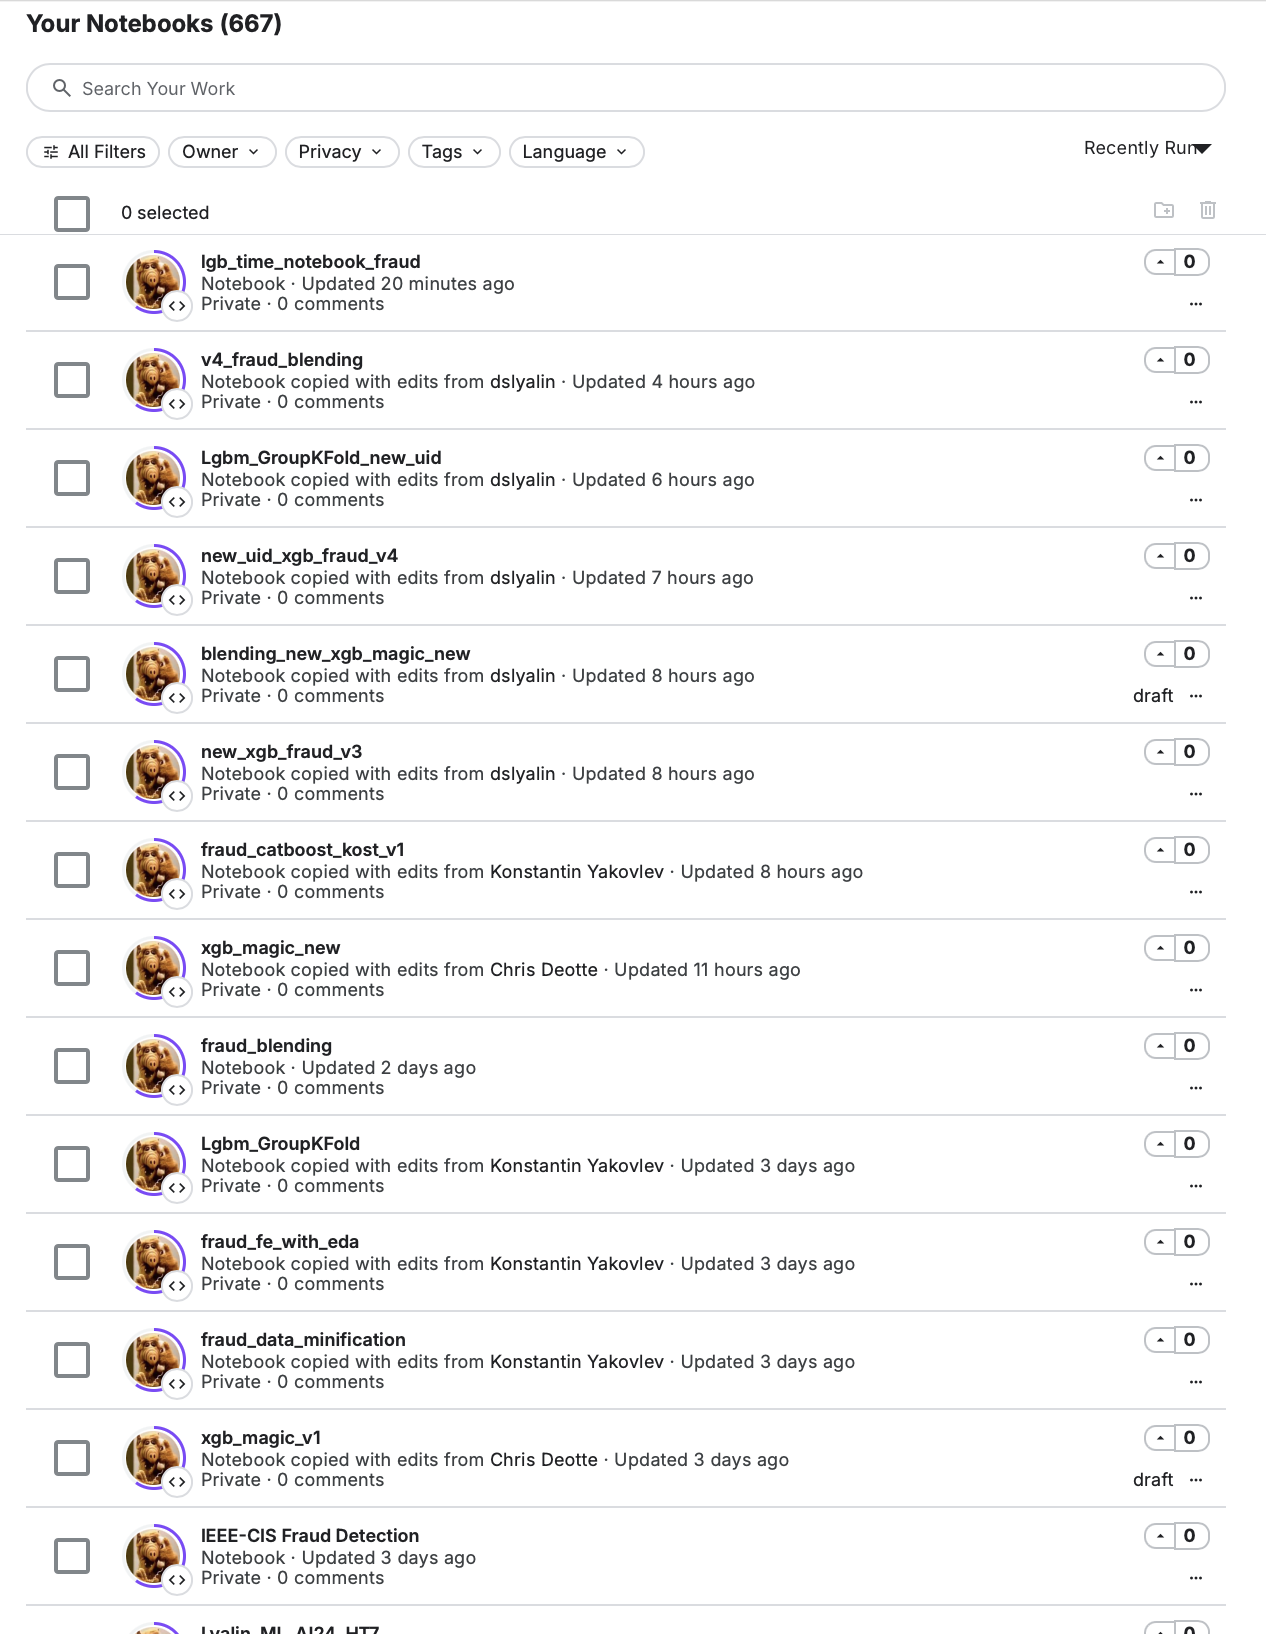

In [95]:
img_path = "/content/drive/My Drive/screenshots/fraud_detection_competition/kaggle_notebooks_fraud.png"

with open(img_path, "rb") as img_file:
    encoded = base64.b64encode(img_file.read()).decode()

html_code = f'<img src="data:image/png;base64,{encoded}" width="600"/>'
display(HTML(html_code))

**Лучшая локальная cv:**
1. XGboost CV = 0.9322058303179509
2. LightGBM OOF AUC: 0.9330179738723597
3. Catboost OOF AUC: 0.9315451783325991

Блендинг 1/3 всех моделей дал Score: **0.95233** на паблик лидерборде.  
Блендинг 0.7 xgboost и 0.3 lightgbm Score: **0.95321**.
Их я и выбрал в качестве финальных. Надеюсь, не слишком переобучился =)

Спасибо за задание! Было сложно, порой неожиданно и интересно!  
P. s. Теперь вот не хватает успокоительного котобонуса =)